In [149]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
import glob

sns.set_context("talk", font_scale=1.0)
sns.set_theme(font='serif')

In [165]:
# Replace 'your_file.csv' with the actual path to your CSV file
file_path = 'existing_relevant_combinations.csv'
model_list_kitti_top10 = ["liteflownet3_pseudoreg", "maskflownet", "flowformer++", "raft", "flow1d", "craft", "rpknet", "scopeflow", "gma", "ms_raft+"]
model_list_sintel_top10 = ["liteflownet3", "maskflownet", "flowformer++", "raft", "flow1d", "craft", "rpknet", "scopeflow", "gma", "ms_raft+"]
# Load the dataframe from CSV with comma as delimiter
df = pd.read_csv(file_path, delimiter=',')
model_names_mapping = {"raft": "RAFT", "gma": "GMA", "rpknet": "RPKNet", "ccmr": "CCMR", "craft": "CRAFT", "csflow":"CSFlow", "dicl": "DICL-Flow", "dip": "DIP", "fastflownet":"FastFlownet", "maskflownet":"MaskFlownet", "maskflownet_s": "MaskFlowNetS", "flow1d":"Flow1D", "flowformer": "FlowFormer", "flowformer++": "FlowFormer++", "gmflow": "GMFlow", "gmflownet": "GMFlowNet", "hd3": "HD3", "irr_pwc": "IRR", "liteflownet":"LiteFlowNet", "liteflownet2": "LiteFlowNet2", "liteflownet3": "LiteFlowNet3", "liteflownet3_pseudoreg": "LiteFlowNet3", "llaflow": "LLA-Flow", "ms_raft+": "MS-RAFT+", "rapidflow": "RAPIDFlow", "scopeflow": "ScopeFlow", "skflow": "SKFlow", "starflow": "STaRFlow", "videoflow_bof": "VideoFlow", "pwcnet": "PWCNet"}

marker_styles = {
    'raft': 'o',         # Circle
    'gma': 'X',          # Filled diamond
    'rpknet': 'v',       # Downward triangle
    'ccmr': 'h',         # Hexagon
    'craft': 's',        # Square
    'csflow': '^',       # Upward triangle
    'dicl': '<',         # Leftward triangle
    'dip': '>',          # Rightward triangle
    'fastflownet': 'o',  # Circle
    'maskflownet': 'v',  # Downward triangle
    'flow1d': '^',       # Upward triangle
    'flowformer': 'X',   # Filled diamond
    'flowformer++': 's', # Square
    'gmflow': '>',       # Rightward triangle
    'gmflownet': '<',    # Leftward triangle
    'hd3': 'h',          # Hexagon
    'irr_pwc': 's',      # Square
    'liteflownet': 'X',  # Filled diamond
    'liteflownet2': 'o', # Circle
    'liteflownet3': 'v', # Downward triangle
    'liteflownet3_pseudoreg': '^', # Upward triangle
    'llaflow': 'h',      # Hexagon
    'ms_raft+': '>',     # Rightward triangle
    'rapidflow': '<',     # Leftward triangle
    'scopeflow': 'X',    # Filled diamond
    'skflow': 'v',       # Plus (cross)
    'starflow': 's',     # Square
    'videoflow_bof': '^',# Upward triangle
    'pwcnet': 'o',       # Circle
}


line_styles = {
  'raft': '-',
  'gma': '--',
  'rpknet': '-.',
  'ccmr': ':',
  'craft': '-',
  'csflow': '--',
  'dicl': '-.',
  'dip': ':',
  'fastflownet': '-',
  'maskflownet': '--',
  'flow1d': '-.',
  'flowformer': ':',
  'flowformer++': '-',
  'gmflow': '--',
  'gmflownet': '-.',
  'hd3': ':',
  'irr_pwc': '-',
  'liteflownet': '--',
  'liteflownet2': '-.',
  'liteflownet3': ':',
  'liteflownet3_pseudoreg': '-',
  'llaflow': '--',
  'ms_raft+': '-.',
  'rapidflow': ':',
  'scopeflow': '-',
  'skflow': '--',
  'starflow': '-.',
  'videoflow_bof': ':',
  'pwcnet': '-'
}
# Use 'tab20' to get a larger set of distinct colors
color_palette = plt.get_cmap("tab10").colors
color_map = {}

for i in range(0, len(model_list_sintel_top10)):
    color_map[model_list_sintel_top10[i]] = color_palette[i]
    if model_list_sintel_top10[i] == "liteflownet3":
        color_map["liteflownet3_pseudoreg"]  = color_palette[i]

i = 0
for model in model_names_mapping.keys():
    if model not in color_map.keys():
        color_map[model] = color_palette[i]
        i = i + 1
    if i== 10:
      i = 0
  
#print(color_map)
# Create a color map by cycling through the larger 'tab20' palette
#color_map = {model: color_palette[i % len(color_palette)] for i, model in enumerate(marker_styles)}

In [166]:
df = df.replace(model_names_mapping)

### NARM TARM GM Plots Preprocessing

In [192]:
import pandas as pd

# Untargeted DataFrame

# Step 1: Filter the DataFrame by multiple conditions
filtered_df_untargeted = df[
    (df['targeted'] == False) & 
    (df['attack'].isin(['pgd', 'cospgd', 'bim'])) & 
    (df['norm'] == 'inf')
]

# Step 2: Sort by "model" and "epe_gt_i20" in descending order (max values)
filtered_df_untargeted_sorted = filtered_df_untargeted.sort_values(['model', 'epe_gt_i20'], ascending=[True, False])

# Step 3: Drop duplicates to keep the row with the max "epe_gt_i20" for each "model"
result_df_untargeted = filtered_df_untargeted_sorted.drop_duplicates(subset=['model'], keep='first')

# Step 4: Rename the epe_gt_i20 column to have a consistent name across DataFrames
result_df_untargeted.rename(columns={'epe_gt_i20': 'highest_epe'}, inplace=True)

# Step 5: Rearrange the columns to make "epe_value" the second column after "model"
columns_order = ['model', 'highest_epe'] + [col for col in result_df_untargeted.columns if col not in ['model', 'highest_epe']]
result_df_untargeted = result_df_untargeted[columns_order]


# Target 'zero' DataFrame

# Step 1: Filter the DataFrame by multiple conditions
filtered_df_zero = df[
    (df['targeted'] == True) & 
    (df['target'] == 'zero') & 
    (df['attack'].isin(['pgd', 'cospgd', 'bim'])) & 
    (df['norm'] == 'inf')
]

# Step 2: Sort by "model" and "epe_target_i20" in ascending order (to get min values)
filtered_df_zero_sorted = filtered_df_zero.sort_values(['model', 'epe_target_i20'], ascending=[True, True])

# Step 3: Drop duplicates to keep the row with the min "epe_target_i20" for each "model"
result_df_zero = filtered_df_zero_sorted.drop_duplicates(subset=['model'], keep='first')

# Step 4: Rename epe_target_i20 to the same name as in the untargeted dataset
result_df_zero.rename(columns={'epe_target_i20': 'highest_epe'}, inplace=True)

# Step 5: Rearrange the columns to make "epe_value" the second column after "model"
columns_order = ['model', 'highest_epe'] + [col for col in result_df_zero.columns if col not in ['model', 'highest_epe']]
result_df_zero = result_df_zero[columns_order]


# Target 'negative' DataFrame

# Step 1: Filter the DataFrame by multiple conditions
filtered_df_negative = df[
    (df['targeted'] == True) & 
    (df['target'] == 'negative') & 
    (df['attack'].isin(['pgd', 'cospgd', 'bim'])) & 
    (df['norm'] == 'inf')
]

# Step 2: Sort by "model" and "epe_target_i20" in ascending order (to get min values)
filtered_df_negative_sorted = filtered_df_negative.sort_values(['model', 'epe_target_i20'], ascending=[True, True])

# Step 3: Drop duplicates to keep the row with the min "epe_target_i20" for each "model"
result_df_negative = filtered_df_negative_sorted.drop_duplicates(subset=['model'], keep='first')

# Step 4: Rename epe_target_i20 to match the untargeted dataset
result_df_negative.rename(columns={'epe_target_i20': 'highest_epe'}, inplace=True)

# Step 5: Rearrange the columns to make "epe_value" the second column after "model"
columns_order = ['model', 'highest_epe'] + [col for col in result_df_negative.columns if col not in ['model', 'highest_epe']]
result_df_negative = result_df_negative[columns_order]




# Now, final_result_df contains all three datasets appended together with consistent column names





# Step 1: Filter the DataFrame by multiple conditions
filtered_df_cc = df[
    (df['attack'].isin(['common_corruptions', '3dcc']))
]

# Step 2: Sort by "model" and "epe_gt_i20" in descending order (max values)
filtered_df_cc_sorted = filtered_df_cc.sort_values(['model', 'epe'], ascending=[True, False])

# Step 3: Drop duplicates to keep the row with the max "epe_gt_i20" for each "model"
result_df_cc = filtered_df_cc_sorted.drop_duplicates(subset=['model'], keep='first')

# Step 4: Rename the epe_gt_i20 column to have a consistent name across DataFrames
result_df_cc.rename(columns={'epe': 'highest_epe'}, inplace=True)

# Step 5: Rearrange the columns to make "epe_value" the second column after "model"
columns_order = ['model', 'highest_epe'] + [col for col in result_df_cc.columns if col not in ['model', 'highest_epe']]
result_df_cc = result_df_cc[columns_order]



# Step 2: Sort by "model" and "epe_gt_i20" in descending order (max values)
filtered_df_clean_sorted = df.sort_values(['model', 'epe_ground_truth'], ascending=[True, False])

# Step 3: Drop duplicates to keep the row with the max "epe_gt_i20" for each "model"
filtered_df_clean_sorted = filtered_df_clean_sorted.drop_duplicates(subset=['model'], keep='first')

# Step 4: Rename the epe_gt_i20 column to have a consistent name across DataFrames
filtered_df_clean_sorted.rename(columns={'epe_ground_truth': 'highest_epe'}, inplace=True)

# Step 5: Rearrange the columns to make "epe_value" the second column after "model"
columns_order = ['model', 'highest_epe'] + [col for col in filtered_df_clean_sorted.columns if col not in ['model', 'highest_epe']]
filtered_df_clean_sorted = filtered_df_clean_sorted[columns_order]


# Final concatenation

# Step 1: Append all three DataFrames vertically using pd.concat
final_result_df = pd.concat([result_df_untargeted, result_df_zero, result_df_negative, result_df_cc], ignore_index=True)

# Step 2: Save the final combined DataFrame to a CSV
final_result_df.to_csv("max_epe.csv", index=False)

/tmp/ipykernel_21223/3499868330.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_untargeted.rename(columns={'epe_gt_i20': 'highest_epe'}, inplace=True)
/tmp/ipykernel_21223/3499868330.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_zero.rename(columns={'epe_target_i20': 'highest_epe'}, inplace=True)
/tmp/ipykernel_21223/3499868330.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_negative.renam

In [275]:
result_df_cc

,model,highest_epe,dataset,checkpoint,attack,norm,epsilon,iterations,alpha,targeted,...,weather_type,start_time,end_time,duration,epe_initial_to_zero,epe_initial_to_negative,model_parameters,point_matching_method,time,numeric
141,CCMR,29.074611,sintel-final,sintel,common_corruptions,NaN,NaN,NaN,NaN,False,...,NaN,2024-08-09 11:04:17,2024-08-09 11:44:59,00:40:42,NaN,NaN,10780884.0,attention,2024-01-01,1704067200000000000
308,CRAFT,20.676034,sintel-final,sintel,common_corruptions,NaN,NaN,NaN,NaN,False,...,NaN,2024-08-09 10:17:25,2024-08-09 10:40:18,00:22:53,NaN,NaN,6307435.0,attention,2022-03-01,1646092800000000000
379,CSFlow,15.038076,kitti-2015,kitti,common_corruptions,NaN,NaN,NaN,NaN,False,...,NaN,2024-07-24 10:29:00,2024-07-24 10:31:08,00:02:07,NaN,NaN,5604672.0,correlation,2022-02-01,1643673600000000000
447,DICL-Flow,30.160766,kitti-2015,kitti,common_corruptions,NaN,NaN,NaN,NaN,False,...,NaN,2024-07-24 11:23:11,2024-07-24 11:25:14,00:02:02,NaN,NaN,11226036.0,cnn,2020-10-01,1601510400000000000
731,DIP,18.868817,sintel-final,sintel,common_corruptions,NaN,NaN,NaN,NaN,False,...,NaN,2024-08-09 15:36:13,2024-08-09 15:58:54,00:22:40,NaN,NaN,5371968.0,correlation,2022-04-01,1648771200000000000
866,FastFlownet,33.573627,sintel-clean,sintel,common_corruptions,NaN,NaN,NaN,NaN,False,...,NaN,2024-08-08 06:56:38,2024-08-08 07:04:27,00:07:48,NaN,NaN,1366114.0,cnn,2021-03-01,1614556800000000000
1086,Flow1D,51.608198,sintel-final,sintel,common_corruptions,NaN,NaN,NaN,NaN,False,...,NaN,2024-08-09 15:56:31,2024-08-09 16:04:25,00:07:54,NaN,NaN,5734208.0,attention + correlation,2021-04-01,1617235200000000000
1219,FlowFormer,28.167091,sintel-final,sintel,common_corruptions,NaN,NaN,NaN,NaN,False,...,NaN,2024-08-09 18:01:05,2024-08-09 18:55:44,00:54:39,NaN,NaN,16168113.0,attention,2022-03-01,1646092800000000000
1367,FlowFormer++,33.249099,sintel-final,sintel,common_corruptions,NaN,NaN,NaN,NaN,False,...,NaN,2024-08-09 18:02:37,2024-08-09 18:57:02,00:54:24,NaN,NaN,16152338.0,attention,2023-03-01,1677628800000000000
1437,GMA,49.806348,kitti-2015,kitti,common_corruptions,NaN,NaN,NaN,NaN,False,...,NaN,2024-07-24 04:23:58,2024-07-24 04:26:23,00:02:25,NaN,NaN,5879873.0,attention,2021-04-01,1617235200000000000


In [175]:
untargeted_df

,model,highest_epe,dataset,checkpoint,attack,norm,epsilon,iterations,alpha,targeted,...,num,weather_type,start_time,end_time,duration,epe_initial_to_zero,epe_initial_to_negative,model_parameters,point_matching_method,time
16,CCMR,25.357672,kitti-2015,kitti,cospgd,inf,0.0314,20.0,0.01,False,...,NaN,NaN,2024-07-09 20:04:43,2024-07-09 21:47:32,01:42:49,31.192852,62.385703,10780884.0,attention,01/2024
197,CRAFT,109.174266,kitti-2015,kitti,pgd,inf,0.0314,20.0,0.01,False,...,NaN,NaN,2024-07-10 03:59:41,2024-07-10 05:59:28,01:59:47,31.445914,62.891828,6307435.0,attention,03/2022
366,CSFlow,140.201099,kitti-2015,kitti,pgd,inf,0.0314,20.0,0.01,False,...,NaN,NaN,2024-07-08 02:13:01,2024-07-08 02:54:21,00:41:20,30.985925,61.971850,5604672.0,correlation,02/2022
485,DICL-Flow,61.117323,sintel-clean,sintel,pgd,inf,0.0314,20.0,0.01,False,...,NaN,NaN,2024-07-25 10:40:34,2024-07-25 12:50:55,02:10:21,13.098189,26.196378,11226036.0,cnn,10/2020
584,DIP,35.477431,kitti-2015,kitti,pgd,inf,0.0314,20.0,0.01,False,...,NaN,NaN,2024-09-10 03:34:18,2024-09-10 04:55:23,01:21:05,31.125885,62.251770,5371968.0,correlation,04/2022
769,FastFlownet,465.661671,kitti-2015,kitti,cospgd,inf,0.0314,20.0,0.01,False,...,NaN,NaN,2024-07-08 01:52:59,2024-07-08 01:55:37,00:02:38,30.008889,60.017777,1366114.0,cnn,03/2021
1076,Flow1D,155.166349,sintel-final,sintel,pgd,inf,0.0314,20.0,0.01,False,...,NaN,NaN,2024-08-20 20:13:46,2024-08-20 22:55:37,02:41:51,13.286875,26.573750,5734208.0,attention + correlation,04/2021
1174,FlowFormer,223.841348,sintel-clean,sintel,pgd,inf,0.0314,20.0,0.01,False,...,NaN,NaN,2024-09-12 12:21:12,2024-09-13 05:10:10,16:48:58,13.443903,26.887807,16168113.0,attention,03/2022
1357,FlowFormer++,247.794810,sintel-final,sintel,pgd,inf,0.0314,20.0,0.01,False,...,NaN,NaN,2024-08-13 05:25:08,2024-08-13 21:41:55,16:16:46,13.423350,26.846700,16152338.0,attention,03/2023
1425,GMA,240.567841,kitti-2015,kitti,pgd,inf,0.0314,20.0,0.01,False,...,NaN,NaN,2024-07-06 13:55:19,2024-07-06 14:47:26,00:52:06,31.097545,62.195090,5879873.0,attention,04/2021


In [274]:
merged_zero

,model,highest_epe_attack,highest_epe_zero
0,CCMR,29.074611,10.739861
1,CRAFT,20.676034,2.160619
2,CSFlow,15.038076,9.299511
3,DICL-Flow,30.160766,5.721617
4,DIP,18.868817,6.111185
5,FastFlownet,33.573627,2.717824
6,Flow1D,51.608198,3.738581
7,FlowFormer,28.167091,1.942213
8,FlowFormer++,33.249099,1.059550
9,GMA,49.806348,2.441501


### PLOT GM - NARM TARM

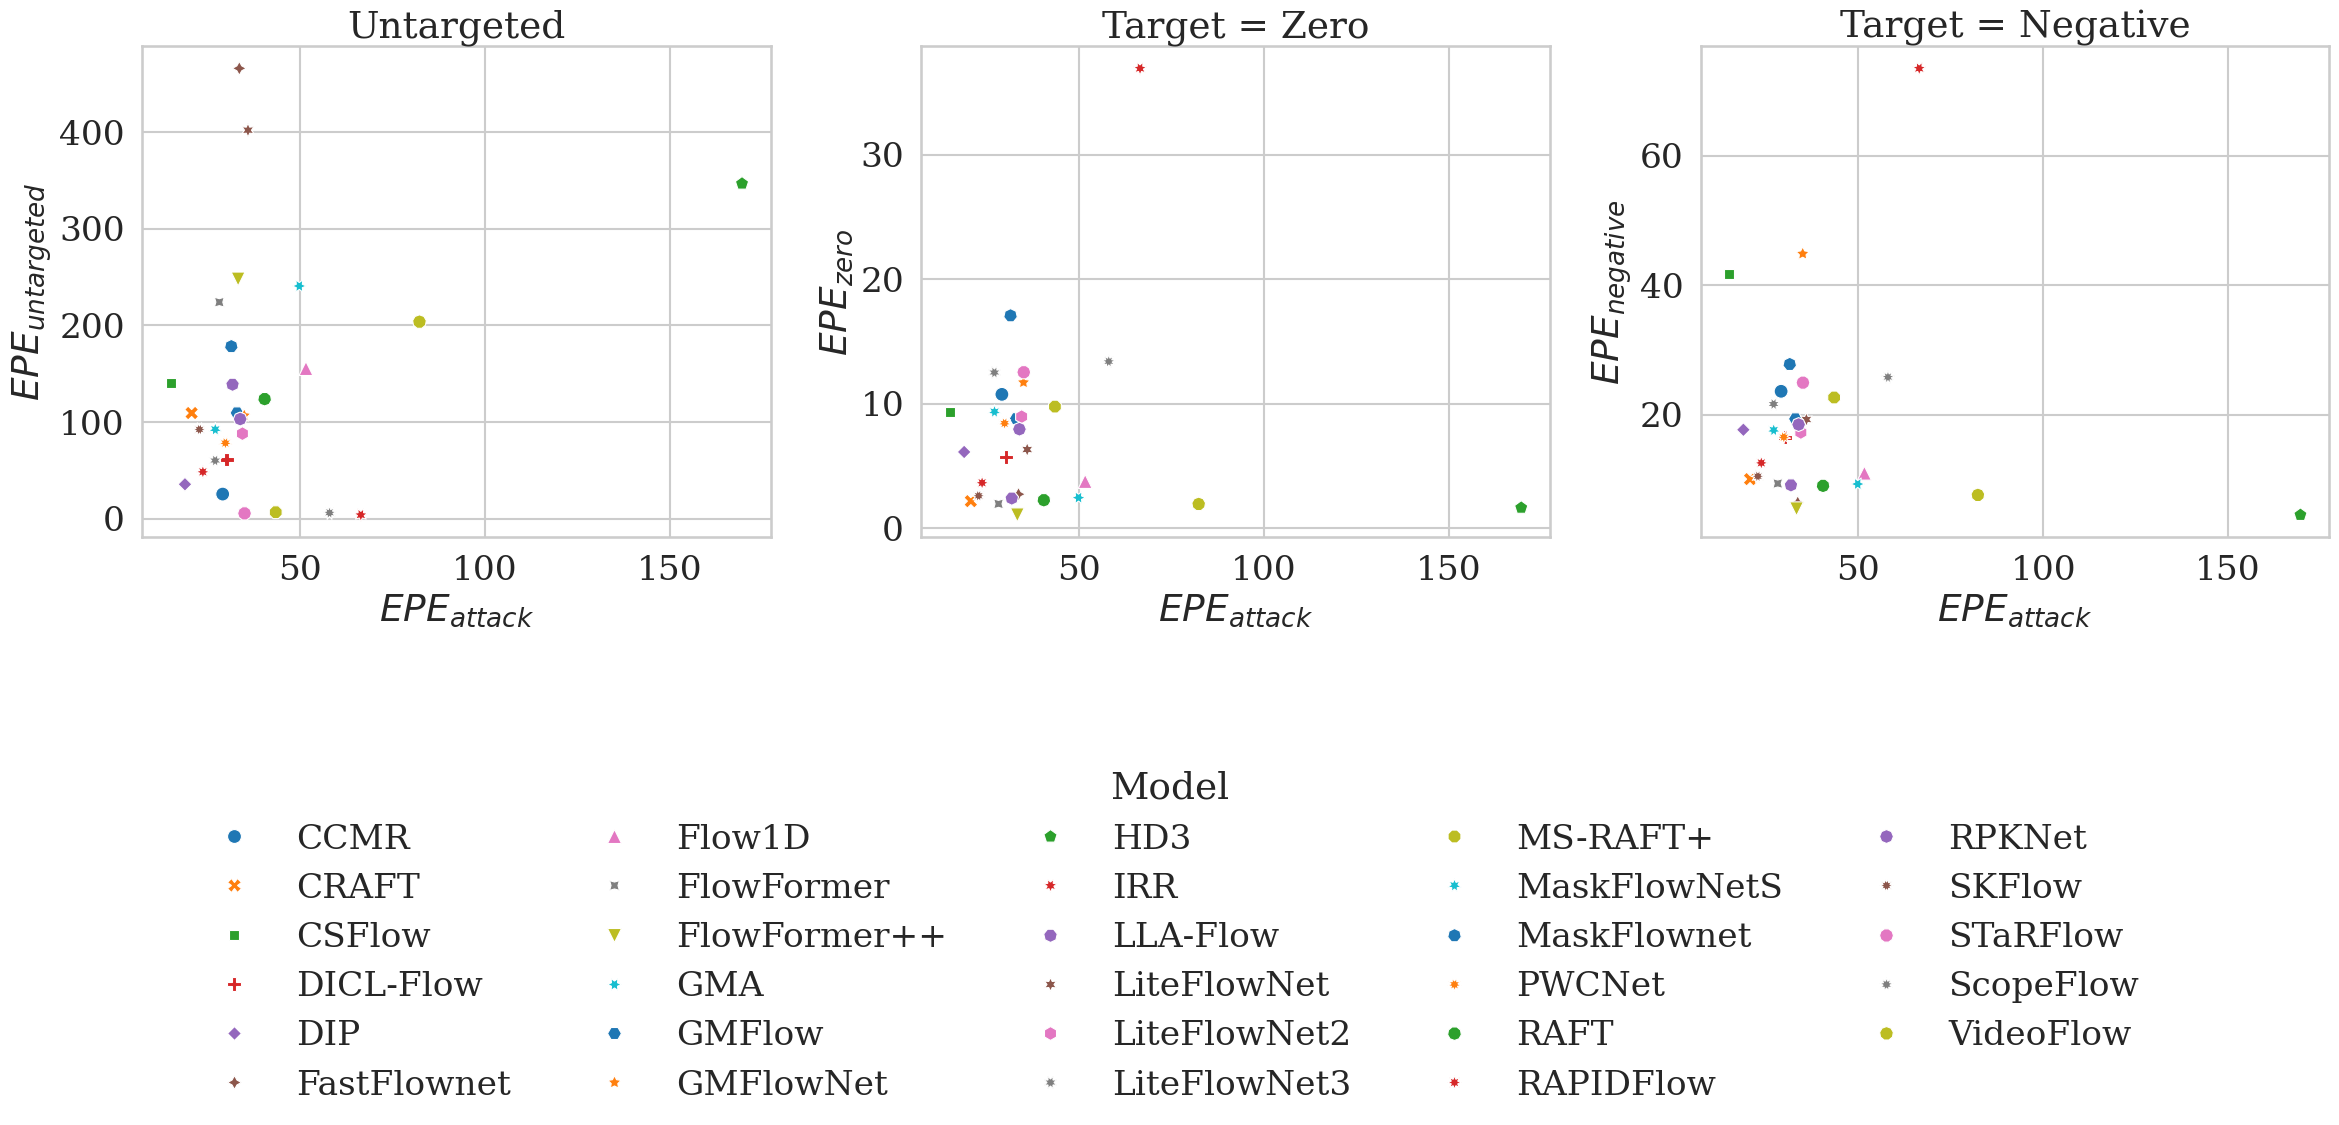

In [168]:
# Prepare the data for plotting

# DataFrame for attack == 'common_corruptions' or attack == '3dcc'
attack_df = final_result_df[final_result_df['attack'].isin(['common_corruptions', '3dcc'])]

# DataFrames for each scenario
untargeted_df = result_df_untargeted  # DataFrame for targeted == False
target_zero_df = result_df_zero  # DataFrame for target == 'zero'
target_negative_df = result_df_negative  # DataFrame for target == 'negative'

# Merge the attack DataFrame with untargeted, target == 'zero', and target == 'negative' on 'model'
merged_untargeted = pd.merge(attack_df[['model', 'highest_epe']], untargeted_df[['model', 'highest_epe']], on='model', suffixes=('_attack', '_untargeted'))
merged_zero = pd.merge(attack_df[['model', 'highest_epe']], target_zero_df[['model', 'highest_epe']], on='model', suffixes=('_attack', '_zero'))
merged_negative = pd.merge(attack_df[['model', 'highest_epe']], target_negative_df[['model', 'highest_epe']], on='model', suffixes=('_attack', '_negative'))



# Set up the seaborn plotting environment
sns.set_context("talk", font_scale=1.3)
sns.set_style("whitegrid")
sns.set_theme(context="talk", style="whitegrid", font='serif', font_scale=1.5)

# Create three subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(24, 7))

# Plot for untargeted (targeted == False)
scatter_untargeted = sns.scatterplot(
    data=merged_untargeted,
    x='highest_epe_attack',
    y='highest_epe_untargeted',
    hue='model',
    style='model',
    palette='tab10',
    ax=axes[0],
    s=100  # Marker size
)
axes[0].set_title("Untargeted")
axes[0].set_xlabel(r'$EPE_{attack}$')
axes[0].set_ylabel(r'$EPE_{untargeted}$')
axes[0].grid(True)

# Plot for target == 'zero'
scatter_zero = sns.scatterplot(
    data=merged_zero,
    x='highest_epe_attack',
    y='highest_epe_zero',
    hue='model',
    style='model',
    palette='tab10',
    ax=axes[1],
    s=100  # Marker size
)
axes[1].set_title("Target = Zero")
axes[1].set_xlabel(r'$EPE_{attack}$')
axes[1].set_ylabel(r'$EPE_{zero}$')
axes[1].grid(True)

# Plot for target == 'negative'
scatter_negative = sns.scatterplot(
    data=merged_negative,
    x='highest_epe_attack',
    y='highest_epe_negative',
    hue='model',
    style='model',
    palette='tab10',
    ax=axes[2],
    s=100  # Marker size
)
axes[2].set_title("Target = Negative")
axes[2].set_xlabel(r'$EPE_{attack}$')
axes[2].set_ylabel(r'$EPE_{negative}$')
axes[2].grid(True)

# Remove individual legends from the subplots
axes[0].legend_.remove()
axes[1].legend_.remove()
axes[2].legend_.remove()

# Adjust the layout and create a single legend below the plot
fig.legend(
    *scatter_untargeted.get_legend_handles_labels(),  # Use handles and labels from one of the plots
    title='Model',
    bbox_to_anchor=(0.5, -0.1),
    loc='upper center',
    ncol=5,
    frameon=False
)

fig.tight_layout()

# Save the plot
plt.savefig('attack_vs_untargeted_zero_negative_epe_plots.pdf', dpi=300, bbox_inches='tight')
plt.savefig('attack_vs_untargeted_zero_negative_epe_plots.png', dpi=300, bbox_inches='tight')
plt.show()



In [288]:
filtered_df_clean_sorted['time'] = pd.to_datetime(filtered_df_clean_sorted['time'], format="%m/%Y")
untargeted_df['time'] = pd.to_datetime(untargeted_df['time'], format="%m/%Y")
result_df_cc['time'] = pd.to_datetime(result_df_cc['time'], format="%m/%Y")

In [289]:
filtered_df_clean_sorted['numeric'] = pd.to_numeric(filtered_df_clean_sorted['time'])
untargeted_df['numeric'] = pd.to_numeric(untargeted_df['time'])
result_df_cc['numeric'] = pd.to_numeric(result_df_cc['time'])

In [216]:
def date_to_numeric(time):
    #return time.strftime('%Y%m%d')
    returning = []
    for item in time:
        returning.append(item.timestamp())
    return returning
    

In [209]:
result_df_cc['time'].iloc[0]

Timestamp('2024-01-01 00:00:00')

In [213]:
date_to_numeric(result_df_cc['time'].iloc[1])

1646092800.0

In [226]:
dates = filtered_df_clean_sorted.sort_values(by='time')['time'].to_numpy()

In [244]:
ticks= axes[0].get_xticks()
ticks[0] = 2018
ticks[-1]=2024

array([2.018e+03, 1.500e+18, 1.550e+18, 1.600e+18, 1.650e+18, 1.700e+18,
       2.024e+03])

In [241]:
def format_fn(tick_val, tick_pos):
    return filtered_df_clean_sorted.query("numeric == {}".format(tick_val))["time"].to_numpy[0]

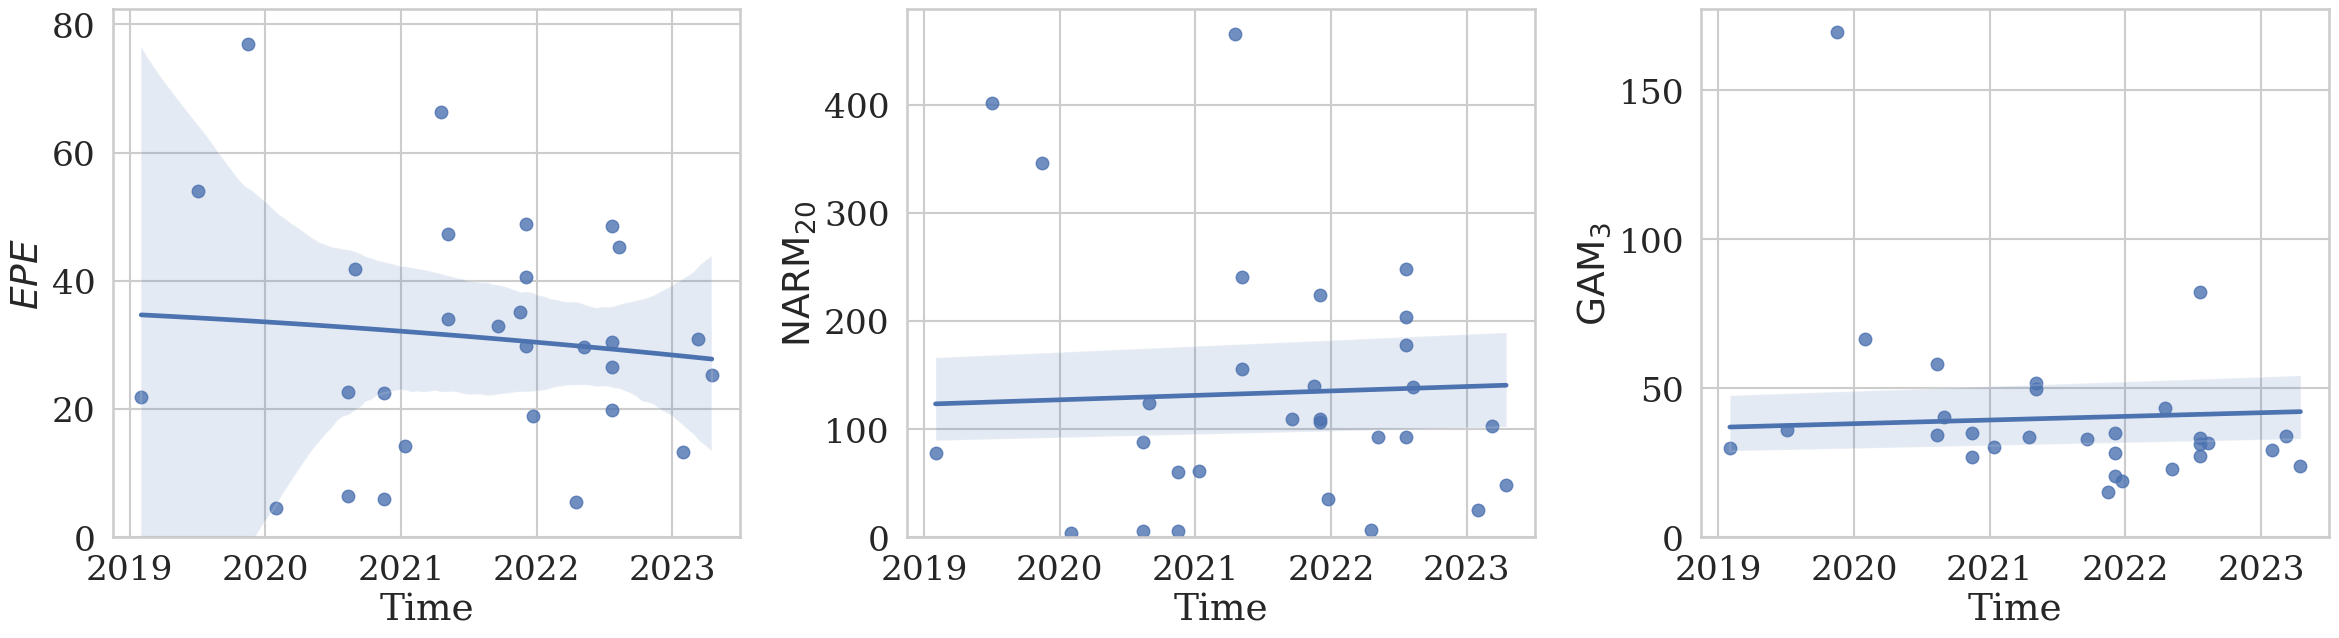

In [290]:
# Set up the seaborn plotting environment
sns.set_context("talk", font_scale=1.5)
sns.set_style("whitegrid")
sns.set_theme(context="talk", style="whitegrid", font='serif', font_scale=1.5)

# Create three subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(24, 7))

# Plot for untargeted (targeted == False)
"""
scatter_untargeted = sns.scatterplot(
    data=filtered_df_clean_sorted,
    y='highest_epe',
    x='numeric',
    hue='model',
    style='model',
    palette='tab10',
    ax=axes,
    s=100  # Marker size
)
axes[0].set_xticks(range(0,29), labels=dates)
"""

#
#"""
scatter_untargeted = sns.regplot(
    data=filtered_df_clean_sorted,
    y='highest_epe',
    x='numeric',
    #x_estimator= date_to_numeric,
    #hue='model',
    #style='model',
    #palette='tab10',
    ax=axes[0],
    order=2,
    #s=100  # Marker size
)
#"""
#axes[0].set_title("Untargeted")
axes[0].set_ylabel(r'$EPE$')
axes[0].set_xlabel('Time')
axes[0].grid(True)
axes[0].set_xticks(ticks=axes[0].get_xticks()[1:-1], labels=range(2019,2024))
axes[0].set_ylim(bottom=0)
#axes[0].xaxis.set_major_formatter(format_fn)



"""
scatter_untargeted = sns.scatterplot(
    data=untargeted_df,
    x='time',
    y='highest_epe',
    hue='model',
    style='model',
    palette='tab10',
    ax=axes[1],
    s=100  # Marker size
)
"""
scatter_untargeted = sns.regplot(
    data=untargeted_df,
    x='numeric',
    y='highest_epe',
    #hue='model',
    #style='model',
    #palette='tab10',
    ax=axes[1],
    order=1,
    #s=100  # Marker size
)
#axes[1].set_title("Target = Zero")
axes[1].set_ylabel(r'$\mathrm{NARM}_{20}$')
axes[1].set_xlabel('Time')
axes[1].grid(True)
axes[1].set_xticks(ticks=axes[1].get_xticks()[1:-1], labels=range(2019,2024))
axes[1].set_ylim(bottom=0)

# Plot for target == 'negative'
"""
scatter_negative = sns.scatterplot(
    data=result_df_cc,
    x='time',
    y='highest_epe',
    hue='model',
    style='model',
    palette='tab10',
    ax=axes[2],
    s=100  # Marker size
)
"""
scatter_negative = sns.regplot(
    data=result_df_cc,
    x='numeric',
    y='highest_epe',
    #hue='model',
    #style='model',
    #palette='tab10',
    ax=axes[2],
    order=1,
    #s=100  # Marker size
)
#axes[2].set_title("Target = Negative")
axes[2].set_xlabel('Time')
axes[2].set_ylabel(r'$\mathrm{GAM}_{3}$')
axes[2].grid(True)
axes[2].set_xticks(ticks=axes[2].get_xticks()[1:-1], labels=range(2019,2024))
axes[2].set_ylim(bottom=0)

"""
# Remove individual legends from the subplots
axes[0].legend_.remove()
axes[1].legend_.remove()
axes[2].legend_.remove()



# Adjust the layout and create a single legend below the plot
fig.legend(
    *scatter_untargeted.get_legend_handles_labels(),  # Use handles and labels from one of the plots
    title='Model',
    bbox_to_anchor=(0.5, -0.1),
    loc='upper center',
    ncol=5,
    frameon=False
)
"""

fig.tight_layout()

# Save the plot
plt.savefig('shashank_plots/teaser/teaser.pdf', dpi=300, bbox_inches='tight')
plt.savefig('shashank_plots/teaser/teaser.png', dpi=300, bbox_inches='tight')
plt.show()

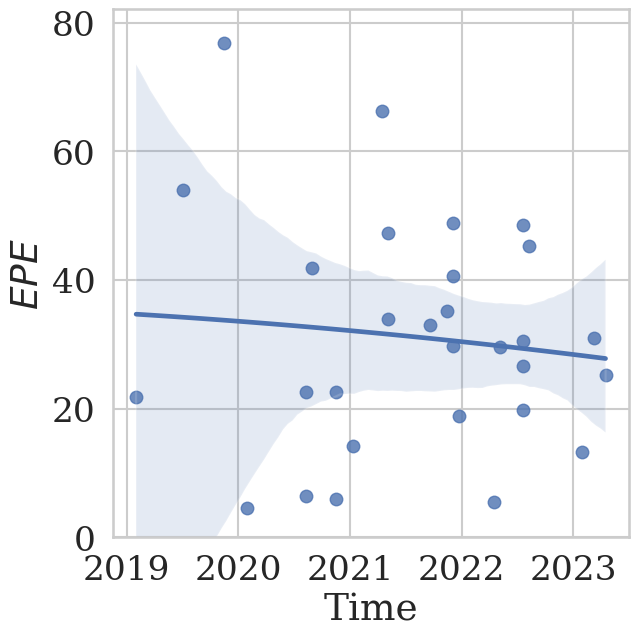

In [291]:
# Set up the seaborn plotting environment
sns.set_context("talk", font_scale=1.5)
sns.set_style("whitegrid")
sns.set_theme(context="talk", style="whitegrid", font='serif', font_scale=1.5)

# Create three subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 1, figsize=(7, 7))

#
#"""
scatter_untargeted = sns.regplot(
    data=filtered_df_clean_sorted,
    y='highest_epe',
    x='numeric',
    #x_estimator= date_to_numeric,
    #hue='model',
    #style='model',
    #palette='tab10',
    ax=axes,
    order=2,
    #s=100  # Marker size
)
#"""
#axes[0].set_title("Untargeted")
axes.set_ylabel(r'$EPE$')
axes.set_xlabel('Time')
axes.grid(True)
axes.set_xticks(ticks=axes.get_xticks()[1:-1], labels=range(2019,2024))
axes.set_ylim(bottom=0)
#axes[0].xaxis.set_major_formatter(format_fn)

fig.tight_layout()

# Save the plot
plt.savefig('shashank_plots/teaser/teaser_iid.pdf', dpi=300, bbox_inches='tight')
plt.savefig('shashank_plots/teaser/teaser_iid.png', dpi=300, bbox_inches='tight')
plt.show()



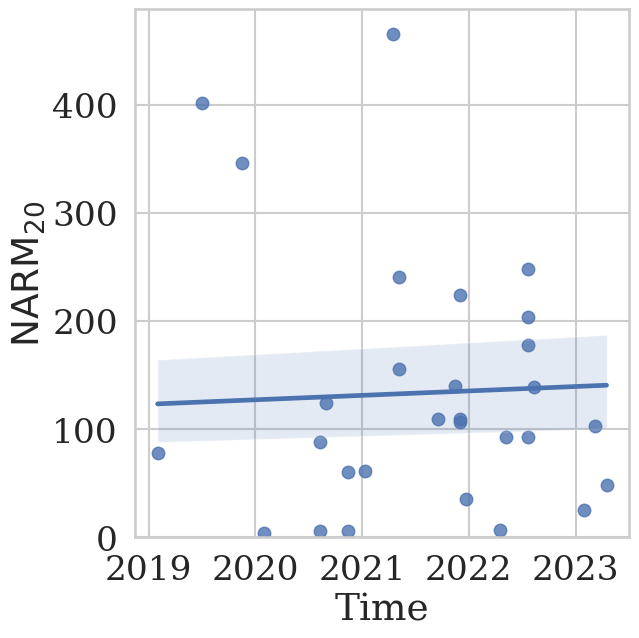

In [292]:

sns.set_context("talk", font_scale=1.5)
sns.set_style("whitegrid")
sns.set_theme(context="talk", style="whitegrid", font='serif', font_scale=1.5)

# Create three subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 1, figsize=(7, 7))

scatter_untargeted = sns.regplot(
    data=untargeted_df,
    x='numeric',
    y='highest_epe',
    #hue='model',
    #style='model',
    #palette='tab10',
    ax=axes,
    #s=100  # Marker size
)
#axes[1].set_title("Target = Zero")
axes.set_ylabel(r'$\mathrm{NARM}_{20}$')
axes.set_xlabel('Time')
axes.grid(True)
axes.set_xticks(ticks=axes.get_xticks()[1:-1], labels=range(2019,2024))
axes.set_ylim(bottom=0)

fig.tight_layout()

# Save the plot
plt.savefig('shashank_plots/teaser/teaser_adv.pdf', dpi=300, bbox_inches='tight')
plt.savefig('shashank_plots/teaser/teaser_adv.png', dpi=300, bbox_inches='tight')
plt.show()


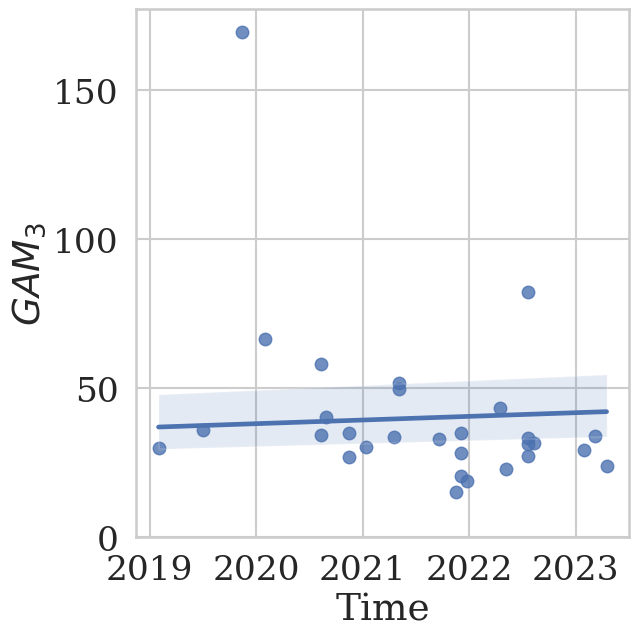

In [259]:
sns.set_context("talk", font_scale=1.5)
sns.set_style("whitegrid")
sns.set_theme(context="talk", style="whitegrid", font='serif', font_scale=1.5)

# Create three subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 1, figsize=(7, 7))
scatter_negative = sns.regplot(
    data=result_df_cc,
    x='numeric',
    y='highest_epe',
    #hue='model',
    #style='model',
    #palette='tab10',
    ax=axes,
    #s=100  # Marker size
)
#axes[2].set_title("Target = Negative")
axes.set_xlabel('Time')
axes.set_ylabel(r'$\mathrm{GAM}_{3}$')
axes.grid(True)
axes.set_xticks(ticks=axes.get_xticks()[1:-1], labels=range(2019,2024))
axes.set_ylim(bottom=0)


fig.tight_layout()

# Save the plot
plt.savefig('shashank_plots/teaser/teaser_ood.pdf', dpi=300, bbox_inches='tight')
plt.savefig('shashank_plots/teaser/teaser_ood.png', dpi=300, bbox_inches='tight')
plt.show()

In [304]:
merge_nontarget_cc = pd.merge(untargeted_df[['model', 'highest_epe', 'point_matching_method', 'model_parameters']],  
                              result_df_cc[['model', 'highest_epe', 'point_matching_method', 'model_parameters']],
                              on=['model', 'point_matching_method', 'model_parameters'], suffixes=('_untargeted',  '_cc'))

merge_target_zero_cc = pd.merge(target_zero_df[['model', 'highest_epe', 'point_matching_method', 'model_parameters']], 
                              result_df_cc[['model', 'highest_epe', 'point_matching_method', 'model_parameters']],
                              on=['model', 'point_matching_method', 'model_parameters'], suffixes=('_target_zero',  '_cc'))

merge_target_negative_cc = pd.merge(target_negative_df[['model', 'highest_epe', 'point_matching_method', 'model_parameters']],
                              result_df_cc[['model', 'highest_epe', 'point_matching_method', 'model_parameters']],
                              on=['model', 'point_matching_method', 'model_parameters'], suffixes=('_target_negative',  '_cc'))

merge_target_negative_zero = pd.merge(target_negative_df[['model', 'highest_epe', 'point_matching_method', 'model_parameters']],
                              target_zero_df[['model', 'highest_epe', 'point_matching_method', 'model_parameters']],
                              on=['model', 'point_matching_method', 'model_parameters'], suffixes=('_target_negative',  '_target_zero'))

merge_clean_cc = pd.merge(filtered_df_clean_sorted[['model', 'highest_epe', 'point_matching_method', 'model_parameters']], 
                              result_df_cc[['model', 'highest_epe', 'point_matching_method', 'model_parameters']],
                              on=['model', 'point_matching_method', 'model_parameters'], suffixes=('_clean',  '_cc'))

merge_clean_nontarget = pd.merge(filtered_df_clean_sorted[['model', 'highest_epe', 'point_matching_method', 'model_parameters']], 
                              untargeted_df[['model', 'highest_epe', 'point_matching_method', 'model_parameters']], 
                              on=['model', 'point_matching_method', 'model_parameters'] , suffixes=('_clean',  '_untargeted'))

merge_clean_target_zero = pd.merge(filtered_df_clean_sorted[['model', 'highest_epe', 'point_matching_method', 'model_parameters']], 
                              target_zero_df[['model', 'highest_epe', 'point_matching_method', 'model_parameters']],
                              on=['model', 'point_matching_method', 'model_parameters'], suffixes=('_clean',  '_target_zero'))

merge_clean_target_negative = pd.merge(filtered_df_clean_sorted[['model', 'highest_epe', 'point_matching_method', 'model_parameters']], 
                              target_negative_df[['model', 'highest_epe', 'point_matching_method', 'model_parameters']],
                              on=['model', 'point_matching_method', 'model_parameters'], suffixes=('_clean',  '_target_negative'))

### NARM TARM Plotting

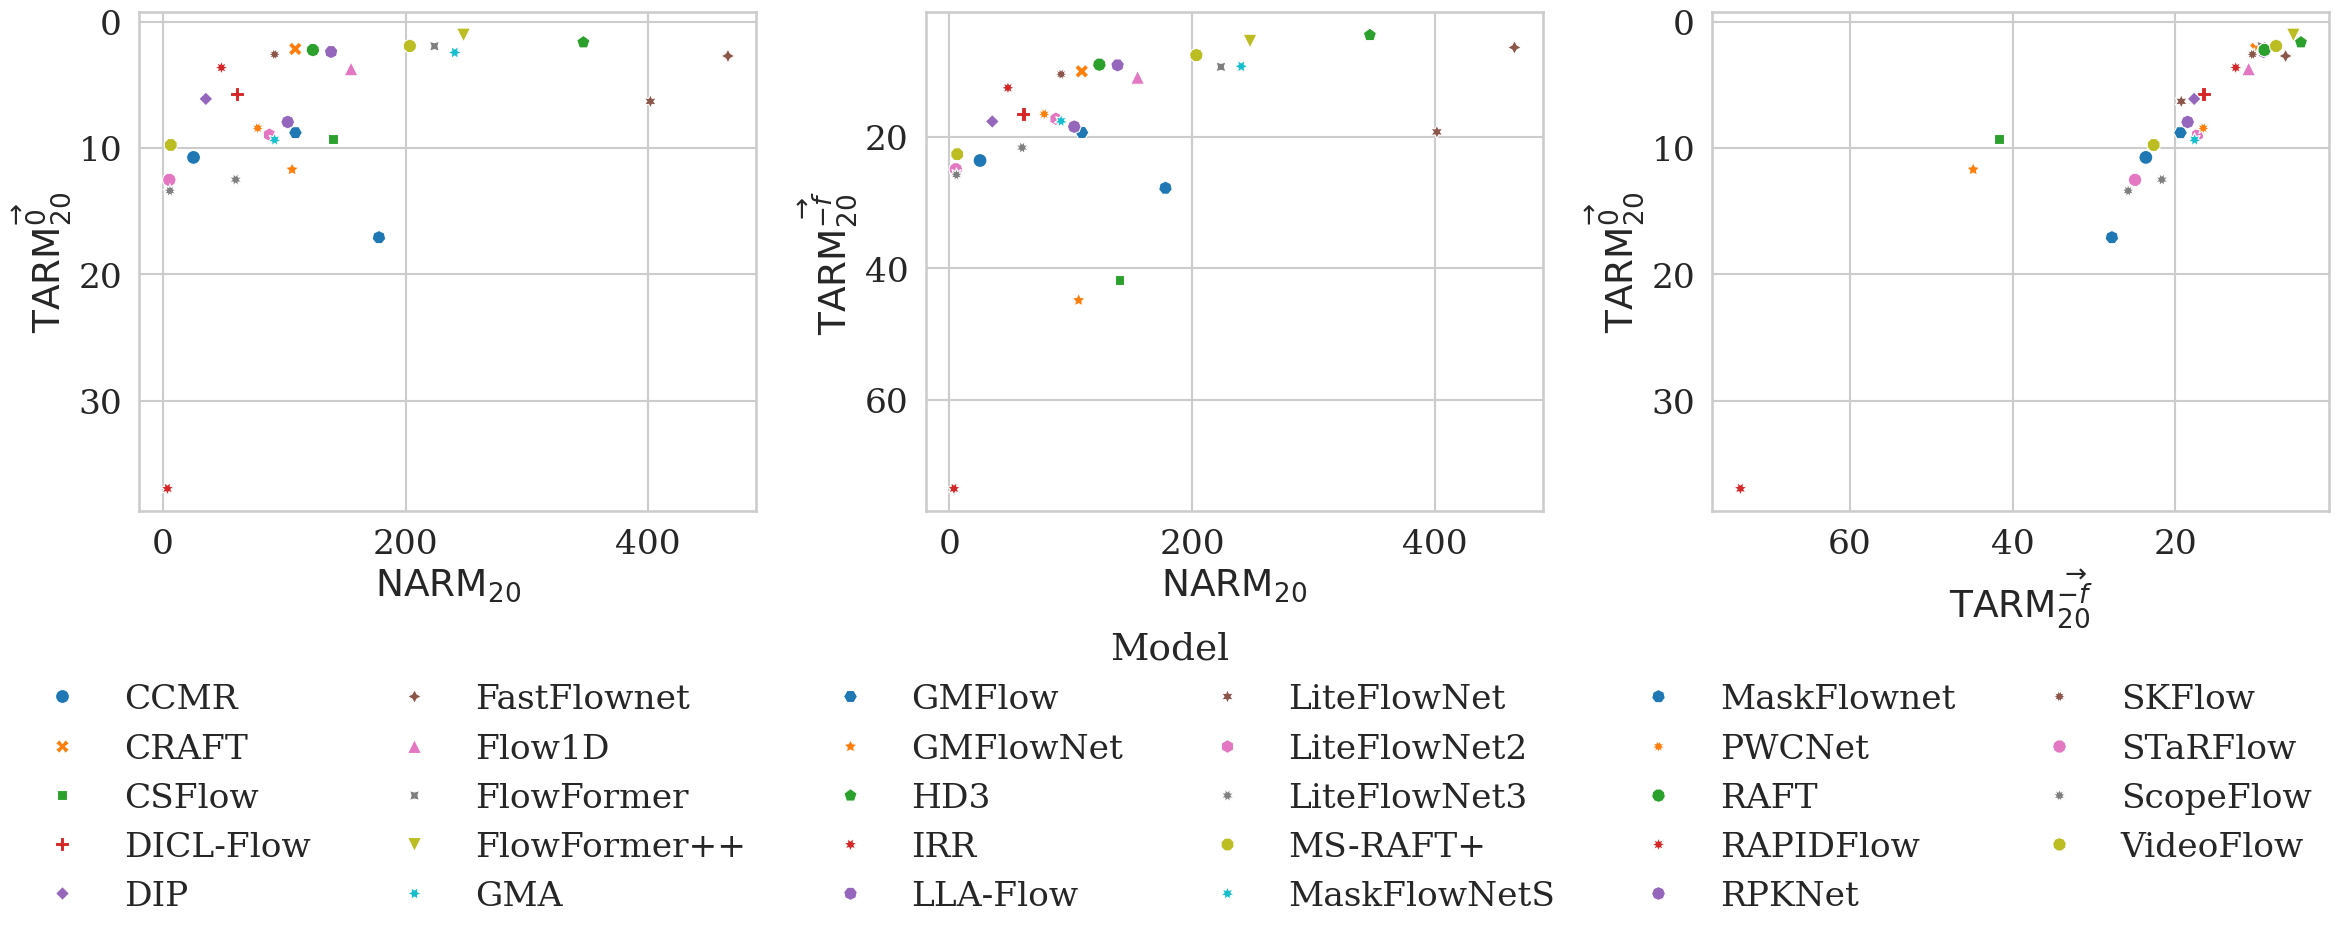

In [298]:
# Prepare the data for plotting
untargeted_df = result_df_untargeted  # DataFrame for targeted == False
target_zero_df = result_df_zero  # DataFrame for target == 'zero'
target_negative_df = result_df_negative  # DataFrame for target == 'negative'

# Merge untargeted with target == 'zero' and target == 'negative' DataFrames on 'model'
merged_zero_df = pd.merge(untargeted_df[['model', 'highest_epe']], target_zero_df[['model', 'highest_epe']], on='model', suffixes=('_untargeted', '_zero'))
merged_negative_df = pd.merge(untargeted_df[['model', 'highest_epe']], target_negative_df[['model', 'highest_epe']], on='model', suffixes=('_untargeted', '_negative'))

# Set up the seaborn plotting environment
sns.set_context("talk", font_scale=1.3)
sns.set_style("whitegrid")
sns.set_theme(context="talk", style="whitegrid", font='serif', font_scale=1.5)

# Create two subplots (1 row, 3 columns) without shared y-axis
fig, axes = plt.subplots(1, 3, figsize=(24, 7))



# Plot for target == 'zero'
scatter_zero = sns.scatterplot(
    data=merged_zero_df,
    x='highest_epe_untargeted',
    y='highest_epe_zero',
    hue='model',
    style='model',
    palette='tab10',
    ax=axes[0],
    s=100  # Marker size
)
#axes[0].set_title("Target = Zero")

# Set X and Y axis labels in LaTeX format for the first plot
axes[0].set_xlabel(r'$\mathrm{NARM}_{20}$')  # LaTeX formatting for NARM with subscript 20
axes[0].set_ylabel(r'$\mathrm{TARM}_{20}^{\overrightarrow{0}}$')  # LaTeX formatting for TARM with subscript 20 and superscript -f
axes[0].grid(True)

# Plot for target == 'negative'
scatter_negative = sns.scatterplot(
    data=merged_negative_df,
    x='highest_epe_untargeted',
    y='highest_epe_negative',
    hue='model',
    style='model',
    palette='tab10',
    ax=axes[1],
    #label=model_names_mapping.get(model, model),
    s=100  # Marker size
)
#axes[1].set_title("Target = Negative")

# Set X and Y axis labels in LaTeX format for the second plot
axes[1].set_xlabel(r'$\mathrm{NARM}_{20}$')  # LaTeX formatting for NARM with subscript 20
axes[1].set_ylabel(r'$\mathrm{TARM}_{20}^{\overrightarrow{-f}}$')  # LaTeX formatting for TARM with subscript 20 and superscript 0
axes[1].grid(True)


scatter_zero = sns.scatterplot(
    data=merge_target_negative_zero,
    x='highest_epe_target_negative',
    y='highest_epe_target_zero',
    hue='model',
    style='model',
    palette='tab10',
    ax=axes[2],
    s=100  # Marker size
)
#axes[0].set_title("Target = Zero")

# Set X and Y axis labels in LaTeX format for the first plot
axes[2].set_xlabel(r'$\mathrm{TARM}_{20}^{\overrightarrow{-f}}$')  # LaTeX formatting for NARM with subscript 20
axes[2].set_ylabel(r'$\mathrm{TARM}_{20}^{\overrightarrow{0}}$')  # LaTeX formatting for TARM with subscript 20 and superscript -f
axes[2].grid(True)

# Remove individual legends from the subplots
axes[0].legend_.remove()
axes[1].legend_.remove()
axes[2].legend_.remove()



axes[0].invert_yaxis()
axes[1].invert_yaxis()
axes[2].invert_yaxis()
axes[2].invert_xaxis()

# Adjust the layout and create a single legend below the plot
fig.legend(
    *scatter_zero.get_legend_handles_labels(),  # Use handles and labels from one of the plots
    title='Model',
    bbox_to_anchor=(0.5, 0.1),
    loc='upper center',
    ncol=6,
    frameon=False
)

fig.tight_layout()

# Save the plot
plt.savefig('shashank_plots/tarm_narm/tarm_narm.pdf', dpi=300, bbox_inches='tight')
plt.savefig('shashank_plots/tarm_narm/tarm_narm.png', dpi=300, bbox_inches='tight')
plt.show()


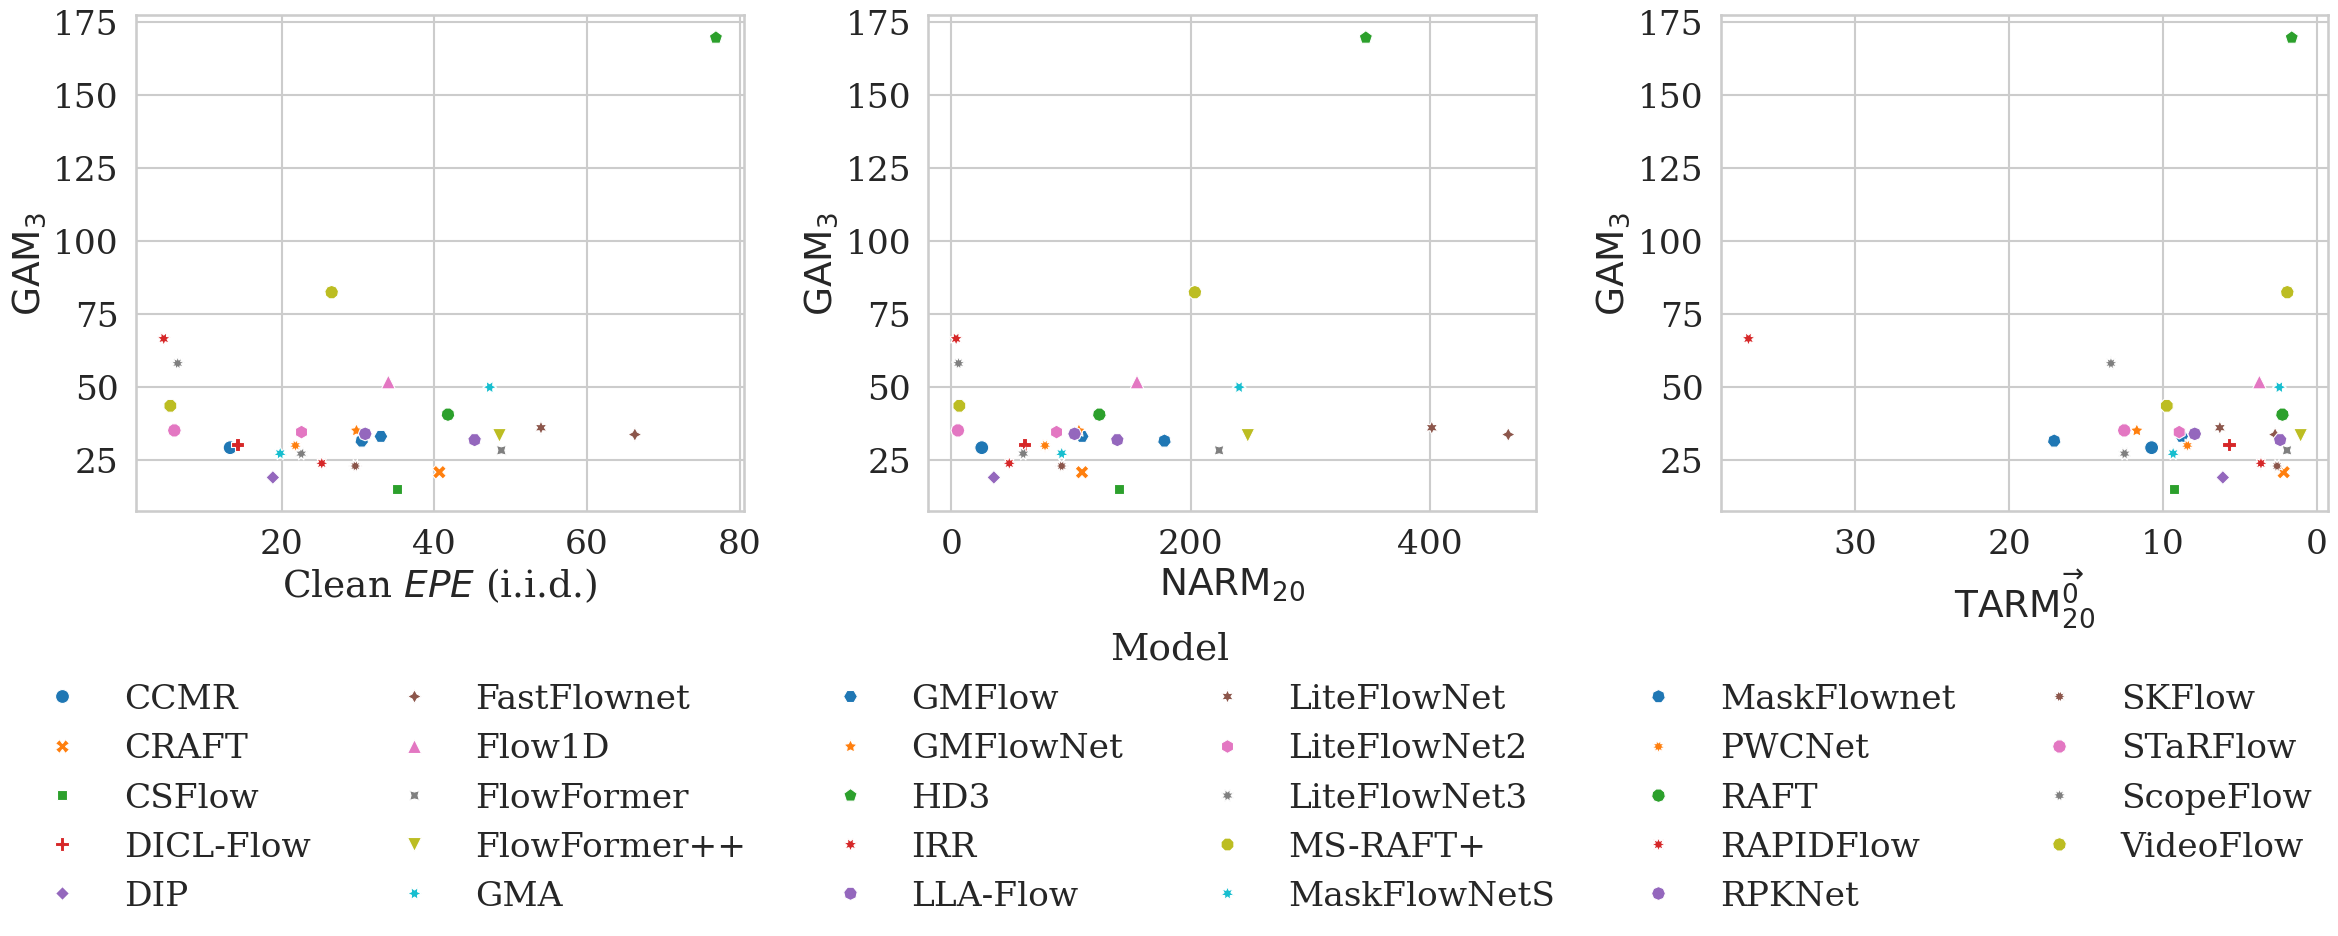

In [299]:
sns.set_theme(context="talk", style="whitegrid", font='serif', font_scale=1.5)

# Create two subplots (1 row, 3 columns) without shared y-axis
fig, axes = plt.subplots(1, 3, figsize=(24, 7))



# Plot for target == 'zero'
scatter_zero = sns.scatterplot(
    data=merge_clean_cc,
    x='highest_epe_clean',
    y='highest_epe_cc',
    hue='model',
    style='model',
    palette='tab10',
    ax=axes[0],
    s=100  # Marker size
)
#axes[0].set_title("Target = Zero")

# Set X and Y axis labels in LaTeX format for the first plot
axes[0].set_xlabel(r'Clean $EPE$ (i.i.d.)')  # LaTeX formatting for NARM with subscript 20
axes[0].set_ylabel(r'$\mathrm{GAM}_{3}$')  # LaTeX formatting for TARM with subscript 20 and superscript -f
axes[0].grid(True)

# Plot for target == 'negative'
scatter_negative = sns.scatterplot(
    data=merge_nontarget_cc,
    x='highest_epe_untargeted',
    y='highest_epe_cc',
    hue='model',
    style='model',
    palette='tab10',
    ax=axes[1],
    #label=model_names_mapping.get(model, model),
    s=100  # Marker size
)
#axes[1].set_title("Target = Negative")

# Set X and Y axis labels in LaTeX format for the second plot
axes[1].set_xlabel(r'$\mathrm{NARM}_{20}$')  # LaTeX formatting for NARM with subscript 20
axes[1].set_ylabel(r'$\mathrm{GAM}_{3}$')  # LaTeX formatting for TARM with subscript 20 and superscript 0
axes[1].grid(True)


scatter_zero = sns.scatterplot(
    data=merge_target_zero_cc,
    x='highest_epe_target_zero',
    y='highest_epe_cc',
    hue='model',
    style='model',
    palette='tab10',
    ax=axes[2],
    s=100  # Marker size
)
#axes[0].set_title("Target = Zero")

# Set X and Y axis labels in LaTeX format for the first plot
axes[2].set_xlabel(r'$\mathrm{TARM}_{20}^{\overrightarrow{0}}$')  # LaTeX formatting for NARM with subscript 20
axes[2].set_ylabel(r'$\mathrm{GAM}_{3}$')  # LaTeX formatting for TARM with subscript 20 and superscript -f
axes[2].grid(True)

# Remove individual legends from the subplots
axes[0].legend_.remove()
axes[1].legend_.remove()
axes[2].legend_.remove()

axes[2].invert_xaxis()

# Adjust the layout and create a single legend below the plot
fig.legend(
    *scatter_zero.get_legend_handles_labels(),  # Use handles and labels from one of the plots
    title='Model',
    bbox_to_anchor=(0.5, 0.1),
    loc='upper center',
    ncol=6,
    frameon=False
)

fig.tight_layout()

# Save the plot
plt.savefig('shashank_plots/reliability_generalization/reliability_generalization.pdf', dpi=300, bbox_inches='tight')
plt.savefig('shashank_plots/reliability_generalization/reliability_generalization.png', dpi=300, bbox_inches='tight')
plt.show()

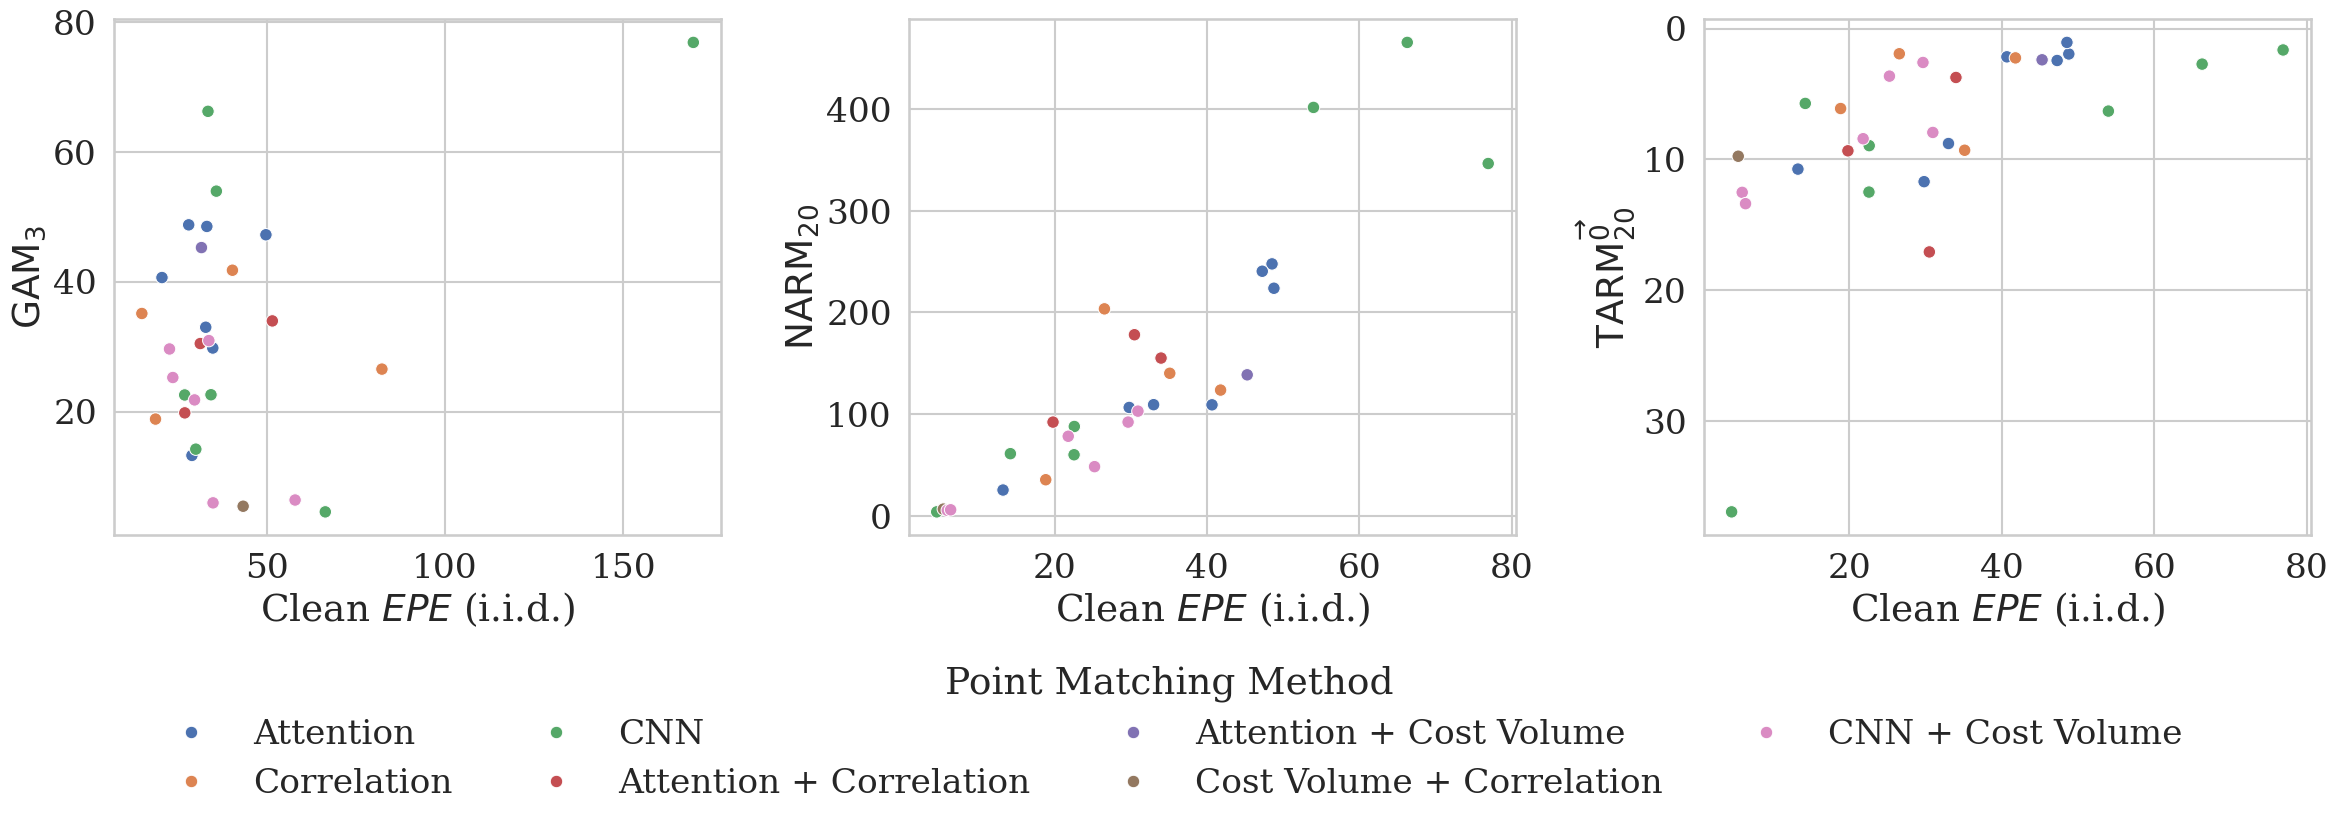

In [326]:
sns.set_theme(context="talk", style="whitegrid", font='serif', font_scale=1.5)

# Create two subplots (1 row, 3 columns) without shared y-axis
fig, axes = plt.subplots(1, 3, figsize=(24, 7))



# Plot for target == 'zero'
scatter_zero = sns.scatterplot(
    data=merge_clean_cc,
    y='highest_epe_clean',
    x='highest_epe_cc',    
    ax=axes[0],    
    #style='model',
    hue='point_matching_method'
)
#axes[0].set_title("Target = Zero")

# Set X and Y axis labels in LaTeX format for the first plot
axes[0].set_xlabel(r'Clean $EPE$ (i.i.d.)')  # LaTeX formatting for NARM with subscript 20
axes[0].set_ylabel(r'$\mathrm{GAM}_{3}$')  # LaTeX formatting for TARM with subscript 20 and superscript -f
axes[0].grid(True)

# Plot for target == 'negative'
scatter_negative = sns.scatterplot(
    data=merge_clean_nontarget,
    y='highest_epe_untargeted',
    x='highest_epe_clean',
    ax=axes[1],    
    #style='model',
    hue='point_matching_method'
    #label=model_names_mapping.get(model, model),
)
#axes[1].set_title("Target = Negative")

# Set X and Y axis labels in LaTeX format for the second plot
axes[1].set_ylabel(r'$\mathrm{NARM}_{20}$')  # LaTeX formatting for NARM with subscript 20
axes[1].set_xlabel(r'Clean $EPE$ (i.i.d.)')  # LaTeX formatting for TARM with subscript 20 and superscript 0
axes[1].grid(True)


scatter_zero = sns.scatterplot(
    data=merge_clean_target_zero,
    y='highest_epe_target_zero',
    x='highest_epe_clean',
    ax=axes[2],    
    #style='model',
    hue='point_matching_method'
)
#axes[0].set_title("Target = Zero")

# Set X and Y axis labels in LaTeX format for the first plot
axes[2].set_ylabel(r'$\mathrm{TARM}_{20}^{\overrightarrow{0}}$')  # LaTeX formatting for NARM with subscript 20
axes[2].set_xlabel(r'Clean $EPE$ (i.i.d.)')  # LaTeX formatting for TARM with subscript 20 and superscript -f
axes[2].grid(True)

# Remove individual legends from the subplots
axes[0].legend_.remove()
axes[1].legend_.remove()
axes[2].legend_.remove()

axes[2].invert_yaxis()

# Adjust the layout and create a single legend below the plot
fig.legend(
    *(scatter_zero.get_legend_handles_labels()[0], ["Attention", "Correlation", "CNN", "Attention + Correlation", "Attention + Cost Volume", "Cost Volume + Correlation", "CNN + Cost Volume"]),  # Use handles and labels from one of the plots
    title='Point Matching Method',
    bbox_to_anchor=(0.5, 0.05),
    loc='upper center',
    ncol=4,
    frameon=False
)

fig.tight_layout()

# Save the plot
plt.savefig('shashank_plots/point_matching/point_matching.pdf', dpi=300, bbox_inches='tight')
plt.savefig('shashank_plots/point_matching/point_matching.png', dpi=300, bbox_inches='tight')
plt.show()

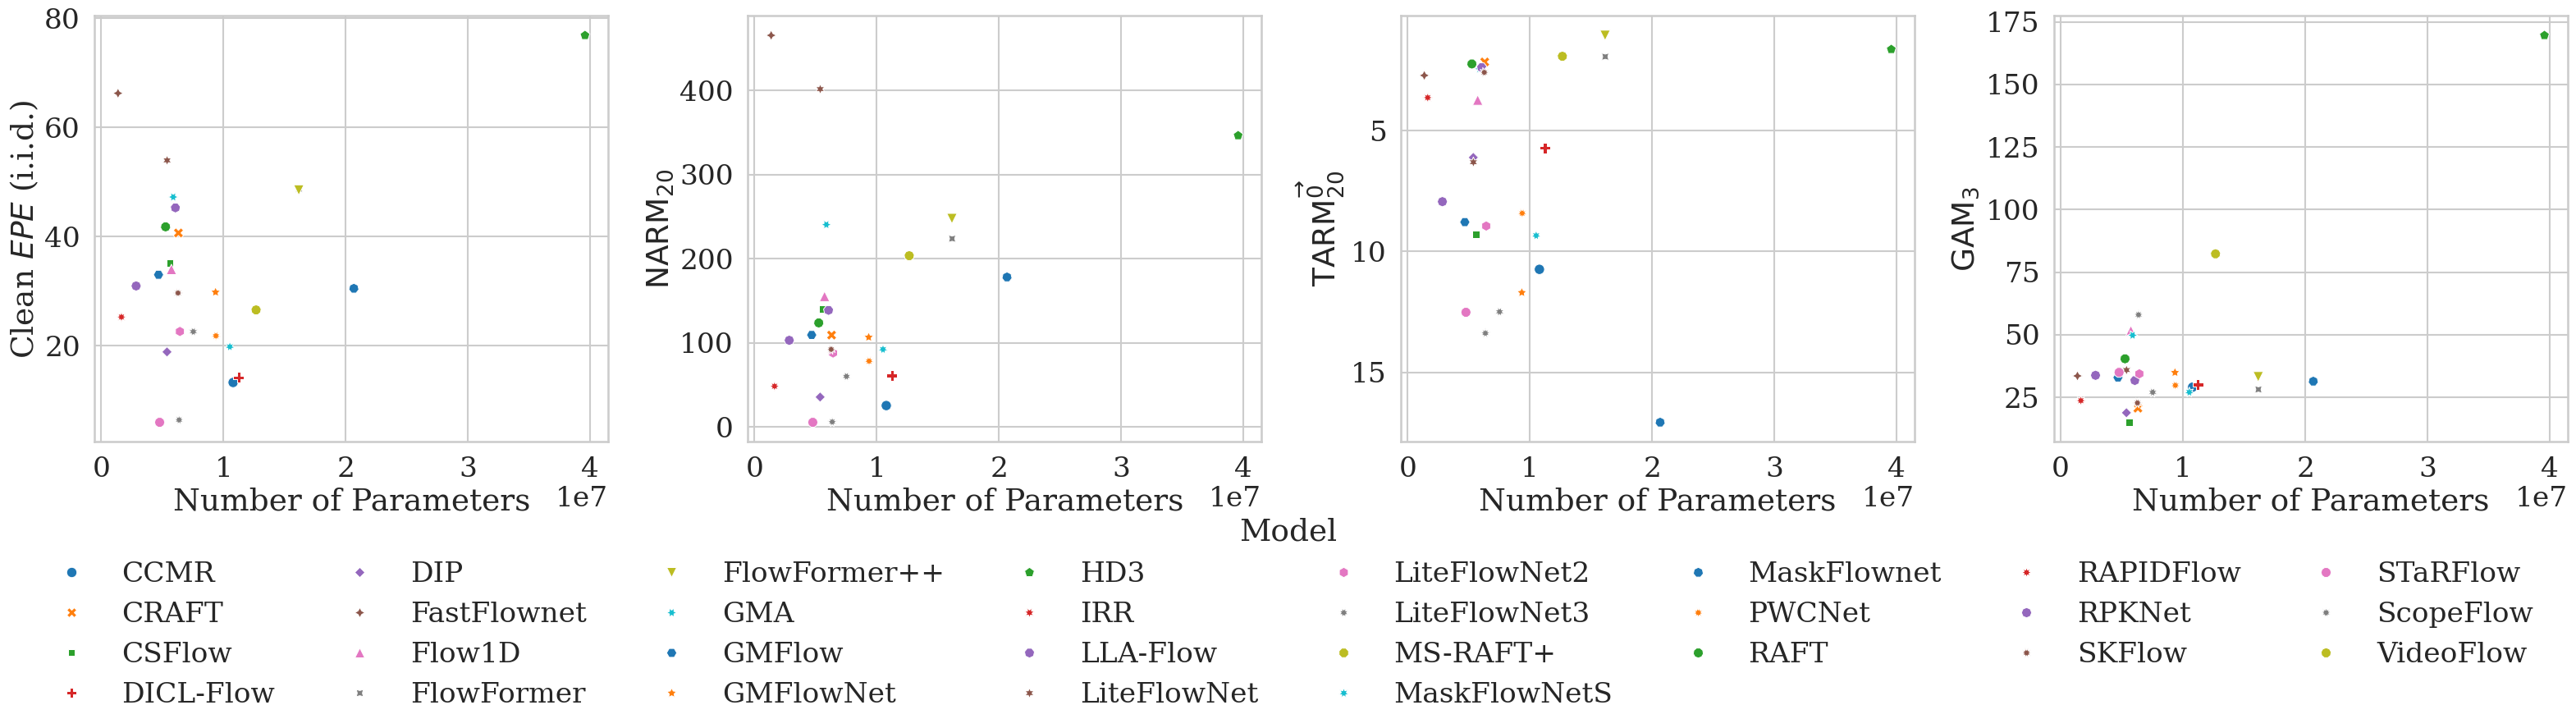

In [331]:
sns.set_theme(context="talk", style="whitegrid", font='serif', font_scale=1.5)

# Create two subplots (1 row, 3 columns) without shared y-axis
fig, axes = plt.subplots(1, 4, figsize=(32, 7))



# Plot for target == 'zero'
scatter_zero = sns.scatterplot(
    data=merge_clean_cc,
    y='highest_epe_clean',
    x='model_parameters',    
    ax=axes[0],    
    style='model',
    palette='tab10',
    hue='model'
)
#axes[0].set_title("Target = Zero")

# Set X and Y axis labels in LaTeX format for the first plot
axes[0].set_ylabel(r'Clean $EPE$ (i.i.d.)')  # LaTeX formatting for NARM with subscript 20
axes[0].set_xlabel('Number of Parameters')  # LaTeX formatting for TARM with subscript 20 and superscript -f
axes[0].grid(True)

# Plot for target == 'negative'
scatter_negative = sns.scatterplot(
    data=merge_clean_nontarget,
    y='highest_epe_untargeted',
    x='model_parameters',
    ax=axes[1],    
    style='model',
    palette='tab10',
    hue='model'
    #label=model_names_mapping.get(model, model),
)
#axes[1].set_title("Target = Negative")

# Set X and Y axis labels in LaTeX format for the second plot
axes[1].set_ylabel(r'$\mathrm{NARM}_{20}$')  # LaTeX formatting for NARM with subscript 20
axes[1].set_xlabel('Number of Parameters')  # LaTeX formatting for TARM with subscript 20 and superscript 0
axes[1].grid(True)


scatter_zero = sns.scatterplot(
    data=merge_clean_target_zero,
    y='highest_epe_target_zero',
    x='model_parameters',
    ax=axes[2],    
    style='model',
    palette='tab10',
    hue='model'
)
#axes[0].set_title("Target = Zero")

# Set X and Y axis labels in LaTeX format for the first plot
axes[2].set_ylabel(r'$\mathrm{TARM}_{20}^{\overrightarrow{0}}$')  # LaTeX formatting for NARM with subscript 20
axes[2].set_xlabel('Number of Parameters')  # LaTeX formatting for TARM with subscript 20 and superscript -f
axes[2].grid(True)

scatter_zero = sns.scatterplot(
    data=merge_clean_cc,
    y='highest_epe_cc',
    x='model_parameters',    
    ax=axes[3],    
    style='model',
    palette='tab10',
    hue='model'
)
#axes[0].set_title("Target = Zero")

# Set X and Y axis labels in LaTeX format for the first plot
axes[3].set_xlabel('Number of Parameters')  # LaTeX formatting for NARM with subscript 20
axes[3].set_ylabel(r'$\mathrm{GAM}_{3}$')  # LaTeX formatting for TARM with subscript 20 and superscript -f
axes[3].grid(True)

# Remove individual legends from the subplots
axes[0].legend_.remove()
axes[1].legend_.remove()
axes[2].legend_.remove()
axes[3].legend_.remove()

axes[2].invert_yaxis()

# Adjust the layout and create a single legend below the plot
fig.legend(
    *scatter_zero.get_legend_handles_labels(),  # Use handles and labels from one of the plots
    title='Model',
    bbox_to_anchor=(0.5, 0.1),
    loc='upper center',
    ncol=8,
    frameon=False
)

fig.tight_layout()

# Save the plot
plt.savefig('shashank_plots/num_params/num_params.pdf', dpi=300, bbox_inches='tight')
plt.savefig('shashank_plots/num_params/num_params.png', dpi=300, bbox_inches='tight')
plt.show()

In [317]:
scatter_zero.get_legend_handles_labels()

([<matplotlib.lines.Line2D at 0x7f17361b4a90>,
 ['attention',
  'correlation',
  'cnn',
  'attention + correlation',
  'attention + cost volume',
  'cost volume + correlation',
  'cnn + cost volume'])

In [323]:
(scatter_zero.get_legend_handles_labels()[0], ["Attention", "Correlation", "CNN", "Attention + Correlation", "Attention + Cost Volume", "Cost Volume + Correlation", "CNN + Cost Volume"])

([<matplotlib.lines.Line2D at 0x7f17361b4a90>,
 ['Attention',
  'Correlation',
  'CNN',
  'Attention + Correlation',
  'Attention + Cost Volume',
  'Cost Volume + Correlation',
  'CNN + Cost Volume'])

In [ ]:
figure_6_df = df.query("epsilon==0.0314 & targeted==False & (optim=='ground_truth' or optim=='initial_flow')")
wrt = 'gt'
figure_6_df = figure_6_df.melt(id_vars=['model', 'epsilon', 'attack', 'optim', 'dataset'], value_vars=[f'epe_{wrt}_i{i}' for i in range(0, 21)], var_name='iterations_type', value_name='epes')
figure_6_df['iterations_type'] = figure_6_df['iterations_type'].str.extract('(\d+)').astype(int)
figure_6_df

In [ ]:
attacks = ['cospgd', 'cospgd', 'pgd', 'pgd']
attack_names = {'cospgd': 'CosPGD', 'pgd':'PGD'}
optimization_names = {'initial_flow': 'Initial Flow', 'ground_truth': 'Ground Truth'}
datasets = ['kitti-2015', 'sintel-clean', 'sintel-final']
datasets_keys = {'kitti-2015': 'KITTI2015', 'sintel-clean': 'MPI Sintel (clean)', 'sintel-final': 'MPI Sintel (final)'}
sns.set_context("talk", font_scale=1.3)
sns.set_style("whitegrid")
sns.set_theme(context="talk", style="whitegrid", font='serif', font_scale=1.5)
fig, axes = plt.subplots(1, 4, figsize=(36, 7), sharey=True)
    # Create a color palette using the color_map, matching models to their colors
palette = {model: color_map.get(model, 'black') for model in figure_6_df['model'].unique()}

    # Iterate over each model to plot with specific marker and line styles
count = 0
for ax, attack in zip(axes.flatten(), attacks):
    #model_data = figure_6_df[figure_4_df['model'] == model]
    count += 1
    for model in figure_6_df['model'].unique():           
        # Get the marker and line style for the current model, with a default fallback
        marker = marker_styles.get(model, 'o')  # Default marker is 'o'
        linestyle = line_styles.get(model, '-')  # Default line style is solid
        # Plot the continuous line for all data points (with markers but only for every 5th iteration)
        moment_df = figure_6_df.query("attack == '{}' & model == '{}' & optim == '{}'".format(
                attack, model, 'ground_truth' if count%2==1 else 'initial_flow'))
        moment_df.to_csv('{}_Attack_Optmized_wrt_{}.csv'.format(attack_names[attack], optimization_names['ground_truth' if count%2==1 else 'initial_flow']))
        sns.lineplot(
            data=figure_6_df.query("attack == '{}' & model == '{}' & optim == '{}'".format(
                attack, model, 'ground_truth' if count%2==1 else 'initial_flow')),
            x='iterations_type',
            y='epes',
            ax=ax,
            linestyle=linestyle,
            color=palette[model],  # Use the color for the current model from the palette
            marker=marker,  # Use the marker style from global marker_styles
            markers=True,
            dashes=False,  # Keep solid lines
            markevery=5,  # Show marker only on every 5th point
            label=model_names_mapping.get(model, model),  # Map to pretty name if available
            errorbar=None
        )

    ax.set_xlabel('Num. of Attack Iterations')    
    ax.set_ylabel('EPE w.r.t. Ground Truth')
    #ax.set_title('{} {}'.format(attack, 'ground_truth' if count%2==1 else 'initial_flow'))
    #ax.set_title('{} Attack Optmized wrt {}'.format(attack_names[attack], optimization_names['ground_truth' if count%2==1 else 'initial_flow']))
    ax.grid(True)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend('', frameon=False)

# Adjust legend
fig.legend(handles, labels,title='Model', bbox_to_anchor=(0.5, -0.36), loc='lower center', ncol=10, frameon=False)
fig.tight_layout()


#plt.legend(title='Model', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=6, frameon=False)

# Adjust layout to give more space to the legend
# plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust rect to move the bottom margin
plt.savefig('shashank_plots/without_title_attack_optim_wrt_initial.pdf', dpi=300, bbox_inches='tight')
plt.savefig('shashank_plots/without_title_attack_optim_wrt_initial.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
attacks = ['cospgd', 'cospgd', 'pgd', 'pgd']
attack_names = {'cospgd': 'CosPGD', 'pgd':'PGD'}
optimization_names = {'initial_flow': 'Initial Flow', 'ground_truth': 'Ground Truth'}

datasets = ['kitti-2015', 'sintel-clean', 'sintel-final']
datasets_keys = {'kitti-2015': 'KITTI2015', 'sintel-clean': 'MPI Sintel (clean)', 'sintel-final': 'MPI Sintel (final)'}
sns.set_context("talk", font_scale=1.3)
sns.set_style("whitegrid")
sns.set_theme(context="talk", style="whitegrid", font='serif', font_scale=1.5)
fig, axes = plt.subplots(1, 4, figsize=(36, 7), sharey=True)
    # Create a color palette using the color_map, matching models to their colors
palette = {model: color_map.get(model, 'black') for model in figure_6_df['model'].unique()}

    # Iterate over each model to plot with specific marker and line styles
count = 0
for ax, attack in zip(axes.flatten(), attacks):
    #model_data = figure_6_df[figure_4_df['model'] == model]
    count += 1
    for model in figure_6_df['model'].unique():
        if model in model_list_kitti_top10:
            
            # Get the marker and line style for the current model, with a default fallback
            marker = marker_styles.get(model, 'o')  # Default marker is 'o'
            linestyle = line_styles.get(model, '-')  # Default line style is solid
            # Plot the continuous line for all data points (with markers but only for every 5th iteration)
            sns.lineplot(
                data=figure_6_df.query("attack == '{}' & model == '{}' & optim == '{}'".format(
                    attack, model, 'ground_truth' if count%2==1 else 'initial_flow')),
                x='iterations_type',
                y='epes',
                ax=ax,
                linestyle=linestyle,
                color=palette[model],  # Use the color for the current model from the palette
                marker=marker,  # Use the marker style from global marker_styles
                markers=True,
                dashes=False,  # Keep solid lines
                markevery=5,  # Show marker only on every 5th point
                label=model_names_mapping.get(model, model),  # Map to pretty name if available
                errorbar=None
            )
        else:
            continue

    ax.set_xlabel('Num. of Attack Iterations')    
    ax.set_ylabel('EPE w.r.t. Ground Truth')
    ax.set_title('{} Attack Optmized wrt {}'.format(attack_names[attack], optimization_names['ground_truth' if count%2==1 else 'initial_flow']))
    ax.grid(True)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend('', frameon=False)

# Adjust legend
fig.legend(handles, labels,title='Model', bbox_to_anchor=(0.5, -0.136), loc='lower center', ncol=10, frameon=False)
fig.tight_layout()


#plt.legend(title='Model', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=6, frameon=False)

# Adjust layout to give more space to the legend
# plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust rect to move the bottom margin
plt.savefig('shashank_plots/with_title_attack_optim_wrt_initial_top10.pdf', dpi=300, bbox_inches='tight')
plt.savefig('shashank_plots/with_title_attack_optim_wrt_initial_top10.png', dpi=300, bbox_inches='tight')
plt.show()

# WASTE

In [139]:
cospgd_gt = figure_6_df.query("dataset == 'kitti-2015' & optim=='ground_truth' & attack=='cospgd' & iterations_type==20").sort_values(by=['model', 'iterations_type', 'epes'])
cospgd_init = figure_6_df.query("dataset == 'kitti-2015' & optim=='inital_flow' & attack=='cospgd' & iterations_type==20").sort_values(by=['model', 'iterations_type', 'epes'])
pgd_gt = figure_6_df.query("dataset == 'kitti-2015' & optim=='ground_truth' & attack=='pgd' & iterations_type==20").sort_values(by=['model', 'iterations_type', 'epes'])
pgd_init = figure_6_df.query("dataset == 'kitti-2015' & optim=='inital_flow' & attack=='pgd' & iterations_type==20").sort_values(by=['model', 'iterations_type', 'epes'])

cospgd_both = figure_6_df.query("dataset == 'kitti-2015' & attack=='cospgd' & iterations_type==20").sort_values(by=['model', 'iterations_type', 'epes'])
pgd_both = figure_6_df.query("dataset == 'kitti-2015' & attack=='pgd' & iterations_type==20").sort_values(by=['model', 'iterations_type', 'epes'])

In [ ]:
cospgd_gt.dropna().corrwith(cospgd_init.dropna(), method='kendall')


# WASTE ENDS

In [39]:
figure_4_df = df.query("attack=='cospgd' & epsilon==0.0314 & targeted==True & target=='zero' & optim=='ground_truth'")

In [40]:
wrt = 'target'
figure_4_df = figure_4_df.melt(id_vars=['model', 'epsilon', 'attack', 'optim', 'dataset'], value_vars=[f'epe_{wrt}_i{i}' for i in range(0, 21)], var_name='iterations_type', value_name='epes')
figure_4_df['iterations_type'] = figure_4_df['iterations_type'].str.extract('(\d+)').astype(int)

In [ ]:
figure_4_df

In [ ]:
datasets = ['kitti-2015', 'sintel-clean', 'sintel-final']
datasets_keys = {'kitti-2015': 'KITTI2015', 'sintel-clean': 'MPI Sintel (clean)', 'sintel-final': 'MPI Sintel (final)'}
sns.set_context("talk", font_scale=1.3)
sns.set_style("whitegrid")
sns.set_theme(context="talk", style="whitegrid", font='serif', font_scale=1.5)
fig, axes = plt.subplots(1, 3, figsize=(36, 7))
    # Create a color palette using the color_map, matching models to their colors
palette = {model: color_map.get(model, 'black') for model in figure_4_df['model'].unique()}

    # Iterate over each model to plot with specific marker and line styles
for ax, dataset in zip(axes.flatten(), datasets):
    #model_data = figure_4_df[figure_4_df['model'] == model]
    for model in figure_4_df['model'].unique():
        # Get the marker and line style for the current model, with a default fallback
        marker = marker_styles.get(model, 'o')  # Default marker is 'o'
        linestyle = line_styles.get(model, '-')  # Default line style is solid
        # Plot the continuous line for all data points (with markers but only for every 5th iteration)
        sns.lineplot(
            data=figure_4_df.query("dataset == '{}' & model == '{}'".format(dataset, model)),
            x='iterations_type',
            y='epes',
            ax=ax,
            linestyle=linestyle,
            color=palette[model],  # Use the color for the current model from the palette
            marker=marker,  # Use the marker style from global marker_styles
            markers=True,
            dashes=False,  # Keep solid lines
            markevery=5,  # Show marker only on every 5th point
            label=model_names_mapping.get(model, model),  # Map to pretty name if available
            errorbar=None
        )

    ax.set_xlabel('Num. of Attack Iterations')    
    ax.set_ylabel('EPE w.r.t. Target Flow')
    #ax.set_title('{}'.format(datasets_keys[dataset]))
    ax.grid(True)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend('', frameon=False)

# Adjust legend
fig.legend(handles, labels,title='Model', bbox_to_anchor=(0.5, -0.36), loc='lower center', ncol=9, frameon=False)
fig.tight_layout()


#plt.legend(title='Model', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=6, frameon=False)

# Adjust layout to give more space to the legend
# plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust rect to move the bottom margin
plt.savefig('shashank_plots/without_title_cospgd_over_datasets.pdf', dpi=300, bbox_inches='tight')
plt.savefig('shashank_plots/without_title_cospgd_over_datasets.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
sns.set_theme(context="talk", style="whitegrid", font='serif', font_scale=1.5)
model_list = model_names_mapping.keys()
# Increase figure size
fig, axes = plt.subplots(1, 2, figsize=(36, 9))  # Adjust the figure size to increase the plot area

corruptions = ['common_corruptions', '3dcc']

for ax, corruption in zip(axes.flatten(), corruptions):
    data = df.query("(attack == '{}') and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list)".format(corruption))
    # Replace model names with pretty names
    data['pretty_model_name'] = data['model'].apply(lambda x: model_names_mapping.get(x, x))

    # Apply marker styles based on the model
    data['marker'] = data['model'].apply(lambda x: marker_styles.get(x, 'o'))  # Default marker is 'o'
    
    if corruption=='common_corruptions':
        # Apply pretty formatting to the 'name' column and handle non-string cases
        data['pretty_name'] = data['name'].apply(lambda x: x.replace('_', ' ').title() if isinstance(x, str) else x)
    else:
        model_mapping = {model: idx for idx, model in enumerate(data['pretty_model_name'].unique())}
        data['model_position'] = data['pretty_model_name'].map(model_mapping)
        
        data['pretty_name'] = data['3dcc_corruption'].apply(lambda x: x.replace('_', ' ').title() if isinstance(x, str) else x)
    
    

    # Create the scatter plot manually to apply custom markers and colors
    for model in data['model'].unique():
        model_data = data[data['model'] == model]
        pretty_model_name = model_names_mapping.get(model, model)
        marker = marker_styles.get(model, 'o')  # Get marker for the model
        color = color_map.get(model)  # Get color from the color map

        sns.scatterplot(
            data=model_data, 
            #x='pretty_name' if corruption=='common_corruptions' else 'model_position',         # Use formatted 'pretty_name' as the x-axis
            x='pretty_name',         # Use formatted 'pretty_name' as the x-axis
            y='epe',                 # 'epe' as the y-axis
            label=pretty_model_name, 
            marker=marker,           # Apply custom marker for each model
            color=color,             # Apply custom color for each model
            s=500,                    # Marker size
            ax=ax
        )

    # Customize the plot
    #ax.set_xticks(rotation=45, fontsize=8, ha='right')  # Rotate x-axis labels, smaller font, and right-align for better readability
    #plt.xticks(rotation=45, fontsize=12, ha='right')  # Rotate x-axis labels, smaller font, and right-align for better readability
    ax.xaxis.set_tick_params(rotation=45)
    ax.set_xlabel('Corruption Type', fontsize=24)  # X-axis label with smaller font size
    
    ax.set_ylabel('EPE', fontsize=24)  # Y-axis label with smaller font size
    ax.grid(True, axis='y')  # Show grid lines for the y-axis
    handles, labels = ax.get_legend_handles_labels()
    ax.legend('', frameon=False)

# Adjust legend
#plt.xticks(rotation=45, fontsize=8, ha='right')  # Rotate x-axis labels, smaller font, and right-align for better readability
fig.legend(handles, labels,title='Model', bbox_to_anchor=(0.5, -0.21), loc='lower center', ncol=9, frameon=False)
fig.tight_layout()
    #plt.title(title)  # Title with slightly larger font

# Scale down the legend font size and move it further down
'''
plt.legend(
    title='Model', 
    bbox_to_anchor=(0.5, -0.35),  # Adjust the second value to move the legend down
    loc='upper center', 
    ncol=4, 
    frameon=False, 
    fontsize='xx-small',      
    handletextpad=0.5,        # Reduce spacing between the legend icon and text
    labelspacing=0.4          # Reduce vertical space between legend entries
)
'''

# Save the plot with reduced padding
plt.tight_layout(pad=2)
plt.savefig('shashank_plots/2d_3d_cc.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
data

In [ ]:
value = 0
datasets = ['kitti-2015', 'sintel-clean', 'sintel-final']
datasets_keys = {'kitti-2015': 'KITTI2015', 'sintel-clean': 'MPI Sintel (clean)', 'sintel-final': 'MPI Sintel (final)'}
sns.set_context("talk", font_scale=1.3)
sns.set_style("whitegrid")
sns.set_theme(context="talk", style="whitegrid", font='serif', font_scale=1.5)
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    # Create a color palette using the color_map, matching models to their colors
palette = {model: color_map.get(model, 'black') for model in figure_4_df['model'].unique()}

    # Iterate over each model to plot with specific marker and line styles
dataset = datasets[value]
for model in figure_4_df['model'].unique():
    # Get the marker and line style for the current model, with a default fallback
    marker = marker_styles.get(model, 'o')  # Default marker is 'o'
    linestyle = line_styles.get(model, '-')  # Default line style is solid
    # Plot the continuous line for all data points (with markers but only for every 5th iteration)
    sns.lineplot(
        data=figure_4_df.query("dataset == '{}' & model == '{}'".format(dataset, model)),
        x='iterations_type',
        y='epes',
        ax=ax,
        linestyle=linestyle,
        color=palette[model],  # Use the color for the current model from the palette
        marker=marker,  # Use the marker style from global marker_styles
        markers=True,
        dashes=False,  # Keep solid lines
        markevery=5,  # Show marker only on every 5th point
        label=model_names_mapping.get(model, model),  # Map to pretty name if available
        errorbar=None
    )

ax.set_xlabel('Num. of Attack Iterations')    
ax.set_ylabel('EPE w.r.t. Target Flow')
#ax.set_title('{}'.format(datasets_keys[dataset]))
ax.grid(True)
handles, labels = ax.get_legend_handles_labels()
ax.legend('', frameon=False)

# Adjust legend


#plt.legend(title='Model', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=6, frameon=False)

# Adjust layout to give more space to the legend
# plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust rect to move the bottom margin
plt.savefig('shashank_plots/without_title_cospgd_over_datasets_{}.pdf'.format(dataset), dpi=300, bbox_inches='tight')
plt.savefig('shashank_plots/without_title_cospgd_over_datasets_{}.png'.format(dataset), dpi=300, bbox_inches='tight')
plt.show()


#### BIM/PGD/CosPGD init flow as optimization target -- Kitti: Functions


In [11]:

# colors = plt.get_cmap("tab10").colors

# Create a distinct color palette for each model
# model_palette_sintel_top10 = {model: color for model, color in zip(model_list_sintel_top10, colors)}
# model_palette_kitti_top10 ={model: color for model, color in zip(model_list_kitti_top10, colors)}


def plot_optim(data, title, filename, optim_targets):
    num_optim_target = len(optim_targets)
    fig, axes = plt.subplots(1, num_optim_target, figsize=(5 * num_optim_target, 10))
    fig.suptitle(title)

    if num_optim_target == 1:
        axes = [axes]

    # Collect handles and labels for the legend
    handles, labels = [], []

    # Initialize y-limits
    y_min, y_max = float('inf'), float('-inf')

    for ax, optim_target in zip(axes, optim_targets):
        # Filter the data for the current optimization target
        plot_data = data.query(f"optim == '{optim_target}' or epsilon == 0")
        print(plot_data[['model', 'iterations_type', 'epes']].head())
        # Create a color palette using the color_map, matching models to their colors
        palette = {model: color_map.get(model, 'black') for model in plot_data['model'].unique()}

        # Create the line plot with consistent color mapping
        sns.lineplot(
            data=plot_data,
            x='iterations_type',
            y='epes',
            hue='model',
            palette=palette,  # Apply the color map to each model
            ax=ax,
            errorbar=None
        )

        # Update global y-limits
        current_y_min, current_y_max = ax.get_ylim()
        y_min = min(y_min, current_y_min)
        y_max = max(y_max, current_y_max)

        # Collect legend handles and labels from each plot
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        # Map the raw model names to their pretty names
        labels.extend([model_names_mapping.get(label, label) for label in l])

        ax.set_title(f"Optimization Target: {optim_target.replace('ground_truth', 'Ground Truth').replace('initial_flow', 'Initial Flow')}")
        ax.set_xlabel('Num. of Attack Iterations')
        ax.set_ylabel('EPE w.r.t. Ground Truth')
        ax.grid(True)

    #Set the same y-limits for all axes
    for ax in axes:
        ax.set_ylim(y_min, y_max)

    # Remove individual legends from each subplot
    for ax in axes:
        ax.legend_.remove()

    # Create a unique legend for the entire figure using the mapped labels
    unique_handles_labels = dict(zip(labels, handles))
    fig.legend(unique_handles_labels.values(), unique_handles_labels.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.001), ncol=4, frameon=False, title='Model')

    # Adjust layout to fit title and legend
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()




def plot_iteration(data, title, filename, epe_to_gt=True):

    fig, ax = plt.subplots(figsize=(12, 7))
    fig.suptitle(title)

    # Filter the data for the 'ground_truth' optimization target
    plot_data = data.query("optim == 'ground_truth' or epsilon == 0")

    # Create a color palette using the color_map, matching models to their colors
    palette = {model: color_map.get(model, 'black') for model in plot_data['model'].unique()}

    # Iterate over each model to plot with specific marker and line styles
    for model in plot_data['model'].unique():
        model_data = plot_data[plot_data['model'] == model]

        # Get the marker and line style for the current model, with a default fallback
        marker = marker_styles.get(model, 'o')  # Default marker is 'o'
        linestyle = line_styles.get(model, '-')  # Default line style is solid

        # Plot the continuous line for all data points (with markers but only for every 5th iteration)
        sns.lineplot(
            data=model_data,
            x='iterations_type',
            y='epes',
            ax=ax,
            linestyle=linestyle,
            color=palette[model],  # Use the color for the current model from the palette
            marker=marker,  # Use the marker style from global marker_styles
            markers=True,
            dashes=False,  # Keep solid lines
            markevery=5,  # Show marker only on every 5th point
            label=model_names_mapping.get(model, model),  # Map to pretty name if available
            errorbar=None
        )

    ax.set_xlabel('Num. of Attack Iterations')
    if epe_to_gt:
        ax.set_ylabel('EPE w.r.t. Ground Truth')
    else:
        ax.set_ylabel('EPE w.r.t. Target Flow')
    ax.grid(True)

    # Adjust legend
    plt.legend(title='Model', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=4, frameon=False)

    # Adjust layout to give more space to the legend
    # plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust rect to move the bottom margin
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

def transform_data(df, model_list, query, wrt):
    filtered_df = df.query(query + " or (attack == 'none' and dataset == 'kitti-2015' and model in @model_list)")
    # Reshape the data
    melted_df = filtered_df.melt(id_vars=['model', 'epsilon', 'attack', 'optim'], value_vars=[f'epe_{wrt}_i{i}' for i in range(0, 21)], var_name='iterations_type', value_name='epes')
    melted_df['iterations_type'] = melted_df['iterations_type'].str.extract('(\d+)').astype(int)
    return melted_df



#### BIM/PGD/CosPGD init flow as optimization target -- Kitti

In [ ]:
### PGD ###

# Plot for untargeted attack
query = "attack == 'pgd' and norm == 'inf' and targeted == False and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_untargeted_inf = transform_data(df, model_list_kitti_top10, query, wrt="gt")
plot_optim(data_untargeted_inf, r'KITTI-2015 - PGD - Untargeted - $L_{\infty}$', 'graphs/PGD_kitti_init_flow.pdf', ["initial_flow", "ground_truth"])


### CosPGD ###

# Plot for untargeted attack
query = "attack == 'cospgd' and norm == 'inf' and targeted == False and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_untargeted_inf = transform_data(df, model_list_kitti_top10, query, wrt="gt")
plot_optim(data_untargeted_inf, r'KITTI-2015 - CosPGD - Untargeted - $L_{\infty}$', 'graphs/CosPGD_kitti_init_flow.pdf', ["initial_flow", "ground_truth"])


#### BIM/PGD/CosPGD top 10 models -- Kitti Inf


In [ ]:
### BIM ###

# Plot for untargeted attack
query = "attack == 'bim' and norm == 'inf' and targeted == False and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list_kitti_top10"
data_untargeted_inf = transform_data(df, model_list_kitti_top10, query, wrt="gt")
plot_iteration(data_untargeted_inf, r'KITTI-2015 - BIM - Untargeted - $L_{\infty}$', 'graphs/BIM_kitti_top_10_untargeted_inf_gt.pdf')

# Plot for targeted attack (Negative Target)
query = "attack == 'bim' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list_kitti_top10"
data_targeted_negative_inf = transform_data(df, model_list_kitti_top10, query, wrt="gt")
plot_iteration(data_targeted_negative_inf, r'KITTI-2015 - BIM - Negative Target - $L_{\infty}$', 'graphs/BIM_kitti_top_10_negative_inf_gt.pdf')

# Plot for targeted attack (Zero Target)
query = "attack == 'bim' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list_kitti_top10"
data_targeted_zero_inf = transform_data(df, model_list_kitti_top10, query, wrt="target")
plot_iteration(data_targeted_zero_inf, r'KITTI-2015 - BIM - Zero Target - $L_{\infty}$', 'graphs/BIM_kitti_top_10_zero_inf_gt.pdf', False)

# Plot for targeted attack (Negative Target) with respect to the target
query = "attack == 'bim' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list_kitti_top10"
data_targeted_negative_inf = transform_data(df, model_list_kitti_top10, query, wrt="target")
plot_iteration(data_targeted_negative_inf, r'KITTI-2015 - BIM - Negative Target - $L_{\infty}$', 'graphs/BIM_kitti_top_10_negative_inf_target.pdf', False)

# Plot for targeted attack (Zero Target) with respect to the ground truth
query = "attack == 'bim' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list_kitti_top10"
data_targeted_zero_inf = transform_data(df, model_list_kitti_top10, query, wrt="gt")
plot_iteration(data_targeted_zero_inf, r'KITTI-2015 - BIM - Zero Target - $L_{\infty}$', 'graphs/BIM_kitti_top_10_zero_inf_target.pdf')



### PGD ###

# Plot for untargeted attack
query = "attack == 'pgd' and norm == 'inf' and targeted == False and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list_kitti_top10"
data_untargeted_inf = transform_data(df, model_list_kitti_top10, query, wrt="gt")
plot_iteration(data_untargeted_inf, r'KITTI-2015 - PGD - Untargeted - $L_{\infty}$', 'graphs/PGD_kitti_top_10_untargeted_inf_gt.pdf')

# Plot for targeted attack (Negative Target)
query = "attack == 'pgd' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list_kitti_top10"
data_targeted_negative_inf = transform_data(df, model_list_kitti_top10, query, wrt="gt")
plot_iteration(data_targeted_negative_inf, r'KITTI-2015 - PGD - Negative Target - $L_{\infty}$', 'graphs/PGD_kitti_top_10_negative_inf_gt.pdf')

# Plot for targeted attack (Zero Target)
query = "attack == 'pgd' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list_kitti_top10"
data_targeted_zero_inf = transform_data(df, model_list_kitti_top10, query, wrt="gt")
plot_iteration(data_targeted_zero_inf, r'KITTI-2015 - PGD - Zero Target - $L_{\infty}$', 'graphs/PGD_kitti_top_10_zero_inf_gt.pdf')

# Plot for targeted attack (Negative Target) with respect to the target
query = "attack == 'pgd' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list_kitti_top10"
data_targeted_negative_inf = transform_data(df, model_list_kitti_top10, query, wrt="target")
plot_iteration(data_targeted_negative_inf, r'KITTI-2015 - PGD - Negative Target - $L_{\infty}$', 'graphs/PGD_kitti_top_10_negative_inf_target.pdf', False)

# Plot for targeted attack (Zero Target) with respect to the target
query = "attack == 'pgd' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list_kitti_top10"
data_targeted_zero_inf = transform_data(df, model_list_kitti_top10, query, wrt="target")
plot_iteration(data_targeted_zero_inf, r'KITTI-2015 - PGD - Zero Target - $L_{\infty}$', 'graphs/PGD_kitti_top_10_zero_inf_target.pdf', False)


### CosPGD ###

# Plot for untargeted attack
query = "attack == 'cospgd' and norm == 'inf' and targeted == False and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list_kitti_top10"
data_untargeted_inf = transform_data(df, model_list_kitti_top10, query, wrt="gt")
plot_iteration(data_untargeted_inf, r'KITTI-2015 - CosPGD - Untargeted - $L_{\infty}$', 'graphs/CosPGD_kitti_top_10_untargeted_inf_gt.pdf')

# Plot for targeted attack (Negative Target)
query = "attack == 'cospgd' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list_kitti_top10"
data_targeted_negative_inf = transform_data(df, model_list_kitti_top10, query, wrt="gt")
plot_iteration(data_targeted_negative_inf, r'KITTI-2015 - CosPGD - Negative Target - $L_{\infty}$', 'graphs/CosPGD_kitti_top_10_negative_inf_gt.pdf')

# Plot for targeted attack (Zero Target)
query = "attack == 'cospgd' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list_kitti_top10"
data_targeted_zero_inf = transform_data(df, model_list_kitti_top10, query, wrt="gt")
plot_iteration(data_targeted_zero_inf, r'KITTI-2015 - CosPGD - Zero Target - $L_{\infty}$', 'graphs/CosPGD_kitti_top_10_zero_inf_gt.pdf')

# Plot for targeted attack (Negative Target) with respect to the target
query = "attack == 'cospgd' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list_kitti_top10"
data_targeted_negative_inf = transform_data(df, model_list_kitti_top10, query, wrt="target")
plot_iteration(data_targeted_negative_inf, r'KITTI-2015 - CosPGD - Negative Target - $L_{\infty}$', 'graphs/CosPGD_kitti_top_10_negative_inf_target.pdf', False)

# Plot for targeted attack (Zero Target) with respect to the target
query = "attack == 'cospgd' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list_kitti_top10"
data_targeted_zero_inf = transform_data(df, model_list_kitti_top10, query, wrt="target")
plot_iteration(data_targeted_zero_inf, r'KITTI-2015 - CosPGD - Zero Target - $L_{\infty}$', 'graphs/CosPGD_kitti_top_10_zero_inf_target.pdf', False)



#### BIM/PGD/CosPGD all models -- Kitti Inf


In [ ]:
### BIM ###

# Plot for untargeted attack
query = "attack == 'bim' and norm == 'inf' and targeted == False and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_untargeted_inf = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_untargeted_inf, r'KITTI-2015 - BIM - Untargeted - $L_{\infty}$', 'graphs/BIM_kitti_untargeted_inf_gt.pdf')

# Plot for targeted attack (Negative Target)
query = "attack == 'bim' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_targeted_negative_inf = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_targeted_negative_inf, r'KITTI-2015 - BIM - Negative Target - $L_{\infty}$', 'graphs/BIM_kitti_negative_inf_gt.pdf')

# Plot for targeted attack (Zero Target)
query = "attack == 'bim' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_targeted_zero_inf = transform_data(df, model_names_mapping.keys(), query, wrt="target")
plot_iteration(data_targeted_zero_inf, r'KITTI-2015 - BIM - Zero Target - $L_{\infty}$', 'graphs/BIM_kitti_zero_inf_gt.pdf', False)

# Plot for targeted attack (Negative Target)
query = "attack == 'bim' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_targeted_negative_inf = transform_data(df, model_names_mapping.keys(), query, wrt="target")
plot_iteration(data_targeted_negative_inf, r'KITTI-2015 - BIM - Negative Target - $L_{\infty}$', 'graphs/BIM_kitti_negative_inf_target.pdf', False)

# Plot for targeted attack (Zero Target)
query = "attack == 'bim' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_targeted_zero_inf = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_targeted_zero_inf, r'KITTI-2015 - BIM - Zero Target - $L_{\infty}$', 'graphs/BIM_kitti_zero_inf_target.pdf')


### PGD ###

# Plot for untargeted attack
query = "attack == 'pgd' and norm == 'inf' and targeted == False and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_untargeted_inf = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_untargeted_inf, r'KITTI-2015 - PGD - Untargeted - $L_{\infty}$', 'graphs/PGD_kitti_untargeted_inf_gt.pdf')

# Plot for targeted attack (Negative Target)
query = "attack == 'pgd' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_targeted_negative_inf = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_targeted_negative_inf, r'KITTI-2015 - PGD - Negative Target - $L_{\infty}$', 'graphs/PGD_kitti_negative_inf_gt.pdf')

# Plot for targeted attack (Zero Target)
query = "attack == 'pgd' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_targeted_zero_inf = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_targeted_zero_inf, r'KITTI-2015 - PGD - Zero Target - $L_{\infty}$', 'graphs/PGD_kitti_zero_inf_gt.pdf')

# Plot for targeted attack (Negative Target)
query = "attack == 'pgd' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_targeted_negative_inf = transform_data(df, model_names_mapping.keys(), query, wrt="target")
plot_iteration(data_targeted_negative_inf, r'KITTI-2015 - PGD - Negative Target - $L_{\infty}$', 'graphs/PGD_kitti_negative_inf_target.pdf', False)

# Plot for targeted attack (Zero Target)
query = "attack == 'pgd' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_targeted_zero_inf = transform_data(df, model_names_mapping.keys(), query, wrt="target")
plot_iteration(data_targeted_zero_inf, r'KITTI-2015 - PGD - Zero Target - $L_{\infty}$', 'graphs/PGD_kitti_zero_inf_target.pdf', False)

### CosPGD ###

# Plot for untargeted attack
query = "attack == 'cospgd' and norm == 'inf' and targeted == False and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_untargeted_inf = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_untargeted_inf, r'KITTI-2015 - CosPGD - Untargeted - $L_{\infty}$', 'graphs/CosPGD_kitti_untargeted_inf_gt.pdf')

# Plot for targeted attack (Negative Target)
query = "attack == 'cospgd' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_targeted_negative_inf = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_targeted_negative_inf, r'KITTI-2015 - CosPGD - Negative Target - $L_{\infty}$', 'graphs/CosPGD_kitti_negative_inf_gt.pdf')

# Plot for targeted attack (Zero Target)
query = "attack == 'cospgd' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_targeted_zero_inf = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_targeted_zero_inf, r'KITTI-2015 - CosPGD - Zero Target - $L_{\infty}$', 'graphs/CosPGD_kitti_zero_inf_gt.pdf')

# Plot for targeted attack (Negative Target)
query = "attack == 'cospgd' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_targeted_negative_inf = transform_data(df, model_names_mapping.keys(), query, wrt="target")
plot_iteration(data_targeted_negative_inf, r'KITTI-2015 - CosPGD - Negative Target - $L_{\infty}$', 'graphs/CosPGD_kitti_negative_inf_target.pdf', False)

# Plot for targeted attack (Zero Target)
query = "attack == 'cospgd' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_targeted_zero_inf = transform_data(df, model_names_mapping.keys(), query, wrt="target")
plot_iteration(data_targeted_zero_inf, r'KITTI-2015 - CosPGD - Zero Target - $L_{\infty}$', 'graphs/CosPGD_kitti_zero_inf_target.pdf', False)


### BIM/PG/CosPGD Top 10 Models -- Kitti Two

In [ ]:
### BIM ###

# Plot for untargeted attack
query = "attack == 'bim' and norm == 'two' and targeted == False and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list_kitti_top10"
data_untargeted_two = transform_data(df, model_list_kitti_top10, query, wrt="gt")
plot_iteration(data_untargeted_two, r'KITTI-2015 - BIM - Untargeted - $L_{2}$', 'graphs/BIM_kitti_top_10_untargeted_two_gt.pdf')

# Plot for targeted attack (Negative Target)
query = "attack == 'bim' and norm == 'two' and targeted == True and target == 'negative' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list_kitti_top10"
data_targeted_negative_two = transform_data(df, model_list_kitti_top10, query, wrt="gt")
plot_iteration(data_targeted_negative_two, r'KITTI-2015 - BIM - Negative Target - $L_{2}$', 'graphs/BIM_kitti_top_10_negative_two_gt.pdf')

# Plot for targeted attack (Zero Target)
query = "attack == 'bim' and norm == 'two' and targeted == True and target == 'zero' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list_kitti_top10"
data_targeted_zero_two = transform_data(df, model_list_kitti_top10, query, wrt="target")
plot_iteration(data_targeted_zero_two, r'KITTI-2015 - BIM - Zero Target - $L_{2}$', 'graphs/BIM_kitti_top_10_zero_two_gt.pdf', False)

# Plot for targeted attack (Negative Target) with respect to the target
query = "attack == 'bim' and norm == 'two' and targeted == True and target == 'negative' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list_kitti_top10"
data_targeted_negative_two = transform_data(df, model_list_kitti_top10, query, wrt="target")
plot_iteration(data_targeted_negative_two, r'KITTI-2015 - BIM - Negative Target - $L_{2}$', 'graphs/BIM_kitti_top_10_negative_two_target.pdf', False)

# Plot for targeted attack (Zero Target) with respect to the ground truth
query = "attack == 'bim' and norm == 'two' and targeted == True and target == 'zero' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list_kitti_top10"
data_targeted_zero_two = transform_data(df, model_list_kitti_top10, query, wrt="gt")
plot_iteration(data_targeted_zero_two, r'KITTI-2015 - BIM - Zero Target - $L_{2}$', 'graphs/BIM_kitti_top_10_zero_two_target.pdf')


### PGD ###

# Plot for untargeted attack
query = "attack == 'pgd' and norm == 'two' and targeted == False and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list_kitti_top10"
data_untargeted_two = transform_data(df, model_list_kitti_top10, query, wrt="gt")
plot_iteration(data_untargeted_two, r'KITTI-2015 - PGD - Untargeted - $L_{2}$', 'graphs/PGD_kitti_top_10_untargeted_two_gt.pdf')

# Plot for targeted attack (Negative Target)
query = "attack == 'pgd' and norm == 'two' and targeted == True and target == 'negative' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list_kitti_top10"
data_targeted_negative_two = transform_data(df, model_list_kitti_top10, query, wrt="gt")
plot_iteration(data_targeted_negative_two, r'KITTI-2015 - PGD - Negative Target - $L_{2}$', 'graphs/PGD_kitti_top_10_negative_two_gt.pdf')

# Plot for targeted attack (Zero Target)
query = "attack == 'pgd' and norm == 'two' and targeted == True and target == 'zero' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list_kitti_top10"
data_targeted_zero_two = transform_data(df, model_list_kitti_top10, query, wrt="gt")
plot_iteration(data_targeted_zero_two, r'KITTI-2015 - PGD - Zero Target - $L_{2}$', 'graphs/PGD_kitti_top_10_zero_two_gt.pdf')

# Plot for targeted attack (Negative Target) with respect to the target
query = "attack == 'pgd' and norm == 'two' and targeted == True and target == 'negative' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list_kitti_top10"
data_targeted_negative_two = transform_data(df, model_list_kitti_top10, query, wrt="target")
plot_iteration(data_targeted_negative_two, r'KITTI-2015 - PGD - Negative Target - $L_{2}$', 'graphs/PGD_kitti_top_10_negative_two_target.pdf', False)

# Plot for targeted attack (Zero Target) with respect to the target
query = "attack == 'pgd' and norm == 'two' and targeted == True and target == 'zero' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list_kitti_top10"
data_targeted_zero_two = transform_data(df, model_list_kitti_top10, query, wrt="target")
plot_iteration(data_targeted_zero_two, r'KITTI-2015 - PGD - Zero Target - $L_{2}$', 'graphs/PGD_kitti_top_10_zero_two_target.pdf', False)


### CosPGD ###

# Plot for untargeted attack
query = "attack == 'cospgd' and norm == 'two' and targeted == False and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list_kitti_top10"
data_untargeted_two = transform_data(df, model_list_kitti_top10, query, wrt="gt")
plot_iteration(data_untargeted_two, r'KITTI-2015 - CosPGD - Untargeted - $L_{2}$', 'graphs/CosPGD_kitti_top_10_untargeted_two_gt.pdf')

# Plot for targeted attack (Negative Target)
query = "attack == 'cospgd' and norm == 'two' and targeted == True and target == 'negative' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list_kitti_top10"
data_targeted_negative_two = transform_data(df, model_list_kitti_top10, query, wrt="gt")
plot_iteration(data_targeted_negative_two, r'KITTI-2015 - CosPGD - Negative Target - $L_{2}$', 'graphs/CosPGD_kitti_top_10_negative_two_gt.pdf')

# Plot for targeted attack (Zero Target)
query = "attack == 'cospgd' and norm == 'two' and targeted == True and target == 'zero' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list_kitti_top10"
data_targeted_zero_two = transform_data(df, model_list_kitti_top10, query, wrt="gt")
plot_iteration(data_targeted_zero_two, r'KITTI-2015 - CosPGD - Zero Target - $L_{2}$', 'graphs/CosPGD_kitti_top_10_zero_two_gt.pdf')

# Plot for targeted attack (Negative Target) with respect to the target
query = "attack == 'cospgd' and norm == 'two' and targeted == True and target == 'negative' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list_kitti_top10"
data_targeted_negative_two = transform_data(df, model_list_kitti_top10, query, wrt="target")
plot_iteration(data_targeted_negative_two, r'KITTI-2015 - CosPGD - Negative Target - $L_{2}$', 'graphs/CosPGD_kitti_top_10_negative_two_target.pdf', False)

# Plot for targeted attack (Zero Target) with respect to the target
query = "attack == 'cospgd' and norm == 'two' and targeted == True and target == 'zero' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list_kitti_top10"
data_targeted_zero_two = transform_data(df, model_list_kitti_top10, query, wrt="target")
plot_iteration(data_targeted_zero_two, r'KITTI-2015 - CosPGD - Zero Target - $L_{2}$', 'graphs/CosPGD_kitti_top_10_zero_two_target.pdf', False)



#### BIM/PGD/CosPGD all models -- Kitti Two


In [ ]:
### BIM ###

# Plot for untargeted attack
query = "attack == 'bim' and norm == 'two' and targeted == False and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list"
data_untargeted_two = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_untargeted_two, r'KITTI-2015 - BIM - Untargeted - $L_{2}$', 'graphs/BIM_kitti_untargeted_two_gt.pdf')

# Plot for targeted attack (Negative Target)
query = "attack == 'bim' and norm == 'two' and targeted == True and target == 'negative' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list"
data_targeted_negative_two = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_targeted_negative_two, r'KITTI-2015 - BIM - Negative Target - $L_{2}$', 'graphs/BIM_kitti_negative_two_gt.pdf')

# Plot for targeted attack (Zero Target)
query = "attack == 'bim' and norm == 'two' and targeted == True and target == 'zero' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list"
data_targeted_zero_two = transform_data(df, model_names_mapping.keys(), query, wrt="target")
plot_iteration(data_targeted_zero_two, r'KITTI-2015 - BIM - Zero Target - $L_{2}$', 'graphs/BIM_kitti_zero_two_gt.pdf', False)

# Plot for targeted attack (Negative Target)
query = "attack == 'bim' and norm == 'two' and targeted == True and target == 'negative' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list"
data_targeted_negative_two = transform_data(df, model_names_mapping.keys(), query, wrt="target")
plot_iteration(data_targeted_negative_two, r'KITTI-2015 - BIM - Negative Target - $L_{2}$', 'graphs/BIM_kitti_negative_two_target.pdf', False)

# Plot for targeted attack (Zero Target)
query = "attack == 'bim' and norm == 'two' and targeted == True and target == 'zero' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list"
data_targeted_zero_two = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_targeted_zero_two, r'KITTI-2015 - BIM - Zero Target - $L_{2}$', 'graphs/BIM_kitti_zero_two_target.pdf')

### PGD ###

# Plot for untargeted attack
query = "attack == 'pgd' and norm == 'two' and targeted == False and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list"
data_untargeted_two = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_untargeted_two, r'KITTI-2015 - PGD - Untargeted - $L_{2}$', 'graphs/PGD_kitti_untargeted_two_gt.pdf')

# Plot for targeted attack (Negative Target)
query = "attack == 'pgd' and norm == 'two' and targeted == True and target == 'negative' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list"
data_targeted_negative_two = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_targeted_negative_two, r'KITTI-2015 - PGD - Negative Target - $L_{2}$', 'graphs/PGD_kitti_negative_two_gt.pdf')

# Plot for targeted attack (Zero Target)
query = "attack == 'pgd' and norm == 'two' and targeted == True and target == 'zero' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list"
data_targeted_zero_two = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_targeted_zero_two, r'KITTI-2015 - PGD - Zero Target - $L_{2}$', 'graphs/PGD_kitti_zero_two_gt.pdf')

# Plot for targeted attack (Negative Target)
query = "attack == 'pgd' and norm == 'two' and targeted == True and target == 'negative' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list"
data_targeted_negative_two = transform_data(df, model_names_mapping.keys(), query, wrt="target")
plot_iteration(data_targeted_negative_two, r'KITTI-2015 - PGD - Negative Target - $L_{2}$', 'graphs/PGD_kitti_negative_two_target.pdf', False)

# Plot for targeted attack (Zero Target)
query = "attack == 'pgd' and norm == 'two' and targeted == True and target == 'zero' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list"
data_targeted_zero_two = transform_data(df, model_names_mapping.keys(), query, wrt="target")
plot_iteration(data_targeted_zero_two, r'KITTI-2015 - PGD - Zero Target - $L_{2}$', 'graphs/PGD_kitti_zero_two_target.pdf', False)

### CosPGD ###

# Plot for untargeted attack
query = "attack == 'cospgd' and norm == 'two' and targeted == False and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list"
data_untargeted_two = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_untargeted_two, r'KITTI-2015 - CosPGD - Untargeted - $L_{2}$', 'graphs/CosPGD_kitti_untargeted_two_gt.pdf')

# Plot for targeted attack (Negative Target)
query = "attack == 'cospgd' and norm == 'two' and targeted == True and target == 'negative' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list"
data_targeted_negative_two = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_targeted_negative_two, r'KITTI-2015 - CosPGD - Negative Target - $L_{2}$', 'graphs/CosPGD_kitti_negative_two_gt.pdf')

# Plot for targeted attack (Zero Target)
query = "attack == 'cospgd' and norm == 'two' and targeted == True and target == 'zero' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list"
data_targeted_zero_two = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_targeted_zero_two, r'KITTI-2015 - CosPGD - Zero Target - $L_{2}$', 'graphs/CosPGD_kitti_zero_two_gt.pdf')

# Plot for targeted attack (Negative Target)
query = "attack == 'cospgd' and norm == 'two' and targeted == True and target == 'negative' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list"
data_targeted_negative_two = transform_data(df, model_names_mapping.keys(), query, wrt="target")
plot_iteration(data_targeted_negative_two, r'KITTI-2015 - CosPGD - Negative Target - $L_{2}$', 'graphs/CosPGD_kitti_negative_two_target.pdf', False)

# Plot for targeted attack (Zero Target)
query = "attack == 'cospgd' and norm == 'two' and targeted == True and target == 'zero' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list"
data_targeted_zero_two = transform_data(df, model_names_mapping.keys(), query, wrt="target")
plot_iteration(data_targeted_zero_two, r'KITTI-2015 - CosPGD - Zero Target - $L_{2}$', 'graphs/CosPGD_kitti_zero_two_target.pdf', False)


#### BIM/PGD/CosPGD init flow as optimization target -- Sintel-clean

In [ ]:
def transform_data(df, model_list, query, wrt):
    filtered_df = df.query(query + " or (attack == 'none' and dataset == 'sintel-clean' and model in @model_list)")
    # Reshape the data
    melted_df = filtered_df.melt(id_vars=['model', 'epsilon', 'attack', 'optim'], value_vars=[f'epe_{wrt}_i{i}' for i in range(0, 21)], var_name='iterations_type', value_name='epes')
    melted_df['iterations_type'] = melted_df['iterations_type'].str.extract('(\d+)').astype(int)
    return melted_df


### PGD ###

# Plot for untargeted attack
query = "attack == 'pgd' and norm == 'inf' and targeted == False and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_untargeted_inf = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot_optim(data_untargeted_inf, r'Sintel-Clean - PGD - Untargeted - $L_{\infty}$', 'graphs/PGD_sintel_clean_init_flow.pdf', ["initial_flow", "ground_truth"])


### CosPGD ###

# Plot for untargeted attack
query = "attack == 'cospgd' and norm == 'inf' and targeted == False and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_untargeted_inf = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot_optim(data_untargeted_inf, r'Sintel-Clean - CosPGD - Untargeted - $L_{\infty}$', 'graphs/CosPGD_sintel_clean_init_flow.pdf', ["initial_flow", "ground_truth"])


### BIM/PGD/CosPGD Top10 models -- SIntel-clean INf

In [ ]:
### BIM ###

# Plot for untargeted attack
query = "attack == 'bim' and norm == 'inf' and targeted == False and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list_sintel_top10"
data_untargeted_inf = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot_iteration(data_untargeted_inf, r'Sintel-Clean - BIM - Untargeted - $L_{\infty}$', 'graphs/BIM_sintel_clean_top_10_untargeted_inf_gt.pdf')

# Plot for targeted attack (Negative Target)
query = "attack == 'bim' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list_sintel_top10"
data_targeted_negative_inf = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot_iteration(data_targeted_negative_inf, r'Sintel-Clean - BIM - Negative Target - $L_{\infty}$', 'graphs/BIM_sintel_clean_top_10_negative_target_inf.pdf')

# Plot for targeted attack (Zero Target)
query = "attack == 'bim' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list_sintel_top10"
data_targeted_zero_inf = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot_iteration(data_targeted_zero_inf, r'Sintel-Clean - BIM - Zero Target - $L_{\infty}$', 'graphs/BIM_sintel_clean_top_10_zero_target_inf.pdf', False)

# Plot for targeted attack (Negative Target) with respect to 'target'
query = "attack == 'bim' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list_sintel_top10"
data_targeted_negative_inf = transform_data(df, model_list_sintel_top10, query, wrt="target")
plot_iteration(data_targeted_negative_inf, r'Sintel-Clean - BIM - Negative Target - $L_{\infty}$', 'graphs/BIM_sintel_clean_top_10_negative_target_inf_wrt_target.pdf', False)

# Plot for targeted attack (Zero Target) with respect to 'target'
query = "attack == 'bim' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list_sintel_top10"
data_targeted_zero_inf = transform_data(df, model_list_sintel_top10, query, wrt="target")
plot_iteration(data_targeted_zero_inf, r'Sintel-Clean - BIM - Zero Target - $L_{\infty}$', 'graphs/BIM_sintel_clean_top_10_zero_target_inf_wrt_target.pdf', False)



### PGD ###

# Plot for untargeted attack
query = "attack == 'pgd' and norm == 'inf' and targeted == False and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list_sintel_top10"
data_untargeted_inf = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot_iteration(data_untargeted_inf, r'Sintel-Clean - PGD - Untargeted - $L_{\infty}$', 'graphs/PGD_sintel_clean_top_10_untargeted_inf_gt.pdf')

# Plot for targeted attack (Negative Target)
query = "attack == 'pgd' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list_sintel_top10"
data_targeted_negative_inf = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot_iteration(data_targeted_negative_inf, r'Sintel-Clean - PGD - Negative Target - $L_{\infty}$', 'graphs/PGD_sintel_clean_top_10_negative_target_inf.pdf')

# Plot for targeted attack (Zero Target)
query = "attack == 'pgd' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list_sintel_top10"
data_targeted_zero_inf = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot_iteration(data_targeted_zero_inf, r'Sintel-Clean - PGD - Zero Target - $L_{\infty}$', 'graphs/PGD_sintel_clean_top_10_zero_target_inf.pdf')

# Plot for targeted attack (Negative Target) with respect to 'target'
query = "attack == 'pgd' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list_sintel_top10"
data_targeted_negative_inf = transform_data(df, model_list_sintel_top10, query, wrt="target")
plot_iteration(data_targeted_negative_inf, r'Sintel-Clean - PGD - Negative Target - $L_{\infty}$', 'graphs/PGD_sintel_clean_top_10_negative_target_inf_wrt_target.pdf', False)

# Plot for targeted attack (Zero Target) with respect to 'target'
query = "attack == 'pgd' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list_sintel_top10"
data_targeted_zero_inf = transform_data(df, model_list_sintel_top10, query, wrt="target")
plot_iteration(data_targeted_zero_inf, r'Sintel-Clean - PGD - Zero Target - $L_{\infty}$', 'graphs/PGD_sintel_clean_top_10_zero_target_inf_wrt_target.pdf', False)

### CosPGD ###

# Plot for untargeted attack
query = "attack == 'cospgd' and norm == 'inf' and targeted == False and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list_sintel_top10"
data_untargeted_inf = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot_iteration(data_untargeted_inf, r'Sintel-Clean - CosPGD - Untargeted - $L_{\infty}$', 'graphs/CosPGD_sintel_clean_top_10_untargeted_inf_gt.pdf')

# Plot for targeted attack (Negative Target)
query = "attack == 'cospgd' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list_sintel_top10"
data_targeted_negative_inf = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot_iteration(data_targeted_negative_inf, r'Sintel-Clean - CosPGD - Negative Target - $L_{\infty}$', 'graphs/CosPGD_sintel_clean_top_10_negative_target_inf.pdf')

# Plot for targeted attack (Zero Target)
query = "attack == 'cospgd' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list_sintel_top10"
data_targeted_zero_inf = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot_iteration(data_targeted_zero_inf, r'Sintel-Clean - CosPGD - Zero Target - $L_{\infty}$', 'graphs/CosPGD_sintel_clean_top_10_zero_target_inf.pdf')

# Plot for targeted attack (Negative Target) with respect to 'target'
query = "attack == 'cospgd' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list_sintel_top10"
data_targeted_negative_inf = transform_data(df, model_list_sintel_top10, query, wrt="target")
plot_iteration(data_targeted_negative_inf, r'Sintel-Clean - CosPGD - Negative Target - $L_{\infty}$', 'graphs/CosPGD_sintel_clean_top_10_negative_target_inf_wrt_target.pdf', False)

# Plot for targeted attack (Zero Target) with respect to 'target'
query = "attack == 'cospgd' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list_sintel_top10"
data_targeted_zero_inf = transform_data(df, model_list_sintel_top10, query, wrt="target")
plot_iteration(data_targeted_zero_inf, r'Sintel-Clean - CosPGD - Zero Target - $L_{\infty}$', 'graphs/CosPGD_sintel_clean_top_10_zero_target_inf_wrt_target.pdf', False)




#### BIM/PGD/CosPGD all models -- Sintel-clean Inf

In [ ]:
### BIM ###

# Plot for untargeted attack
query = "attack == 'bim' and norm == 'inf' and targeted == False and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_untargeted_inf = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_untargeted_inf, r'Sintel-Clean - BIM - Untargeted - $L_{\infty}$', 'graphs/BIM_sintel_clean_untargeted_inf_gt.pdf')

# Plot for targeted attack (Negative Target)
query = "attack == 'pgd' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_targeted_negative_inf = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_targeted_negative_inf, r'Sintel-Clean - PGD - Negative Target - $L_{\infty}$', 'graphs/PGD_sintel_clean_negative_target_inf.pdf')

# Plot for targeted attack (Zero Target)
query = "attack == 'pgd' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_targeted_zero_inf = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_targeted_zero_inf, r'Sintel-Clean - PGD - Zero Target - $L_{\infty}$', 'graphs/PGD_sintel_clean_zero_target_inf.pdf')

# Plot for targeted attack (Negative Target) with respect to 'target'
query = "attack == 'bim' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_targeted_negative_inf = transform_data(df, model_names_mapping.keys(), query, wrt="target")
plot_iteration(data_targeted_negative_inf, r'Sintel-Clean - BIM - Negative Target - $L_{\infty}$', 'graphs/BIM_sintel_clean_negative_target_inf_wrt_target.pdf', False)

# Plot for targeted attack (Zero Target) with respect to 'target'
query = "attack == 'bim' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_targeted_zero_inf = transform_data(df, model_names_mapping.keys(), query, wrt="target")
plot_iteration(data_targeted_zero_inf, r'Sintel-Clean - BIM - Zero Target - $L_{\infty}$', 'graphs/BIM_sintel_clean_zero_target_inf_wrt_target.pdf', False)



### PGD ###

# Plot for untargeted attack
query = "attack == 'pgd' and norm == 'inf' and targeted == False and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_untargeted_inf = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_untargeted_inf, r'Sintel-Clean - PGD - Untargeted - $L_{\infty}$', 'graphs/PGD_sintel_clean_untargeted_inf_gt.pdf')

# Plot for targeted attack (Negative Target)
query = "attack == 'pgd' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_targeted_negative_inf = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_targeted_negative_inf, r'Sintel-Clean - PGD - Negative Target - $L_{\infty}$', 'graphs/PGD_sintel_clean_negative_target_inf.pdf')

# Plot for targeted attack (Zero Target)
query = "attack == 'pgd' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_targeted_zero_inf = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_targeted_zero_inf, r'Sintel-Clean - PGD - Zero Target - $L_{\infty}$', 'graphs/PGD_sintel_clean_zero_target_inf.pdf')

# Plot for targeted attack (Negative Target) with respect to 'target'
query = "attack == 'pgd' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_targeted_negative_inf = transform_data(df, model_names_mapping.keys(), query, wrt="target")
plot_iteration(data_targeted_negative_inf, r'Sintel-Clean - PGD - Negative Target - $L_{\infty}$', 'graphs/PGD_sintel_clean_negative_target_inf_wrt_target.pdf', False)

# Plot for targeted attack (Zero Target) with respect to 'target'
query = "attack == 'pgd' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_targeted_zero_inf = transform_data(df, model_names_mapping.keys(), query, wrt="target")
plot_iteration(data_targeted_zero_inf, r'Sintel-Clean - PGD - Zero Target - $L_{\infty}$', 'graphs/PGD_sintel_clean_zero_target_inf_wrt_target.pdf', False)


### CosPGD ###

# Plot for untargeted attack
query = "attack == 'cospgd' and norm == 'inf' and targeted == False and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_untargeted_inf = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_untargeted_inf, r'Sintel-Clean - CosPGD - Untargeted - $L_{\infty}$', 'graphs/CosPGD_sintel_clean_untargeted_inf_gt.pdf')

# Plot for targeted attack (Negative Target)
query = "attack == 'cospgd' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_targeted_negative_inf = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_targeted_negative_inf, r'Sintel-Clean - CosPGD - Negative Target - $L_{\infty}$', 'graphs/CosPGD_sintel_clean_negative_target_inf.pdf')

# Plot for targeted attack (Zero Target)
query = "attack == 'cospgd' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_targeted_zero_inf = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_targeted_zero_inf, r'Sintel-Clean - CosPGD - Zero Target - $L_{\infty}$', 'graphs/CosPGD_sintel_clean_zero_target_inf.pdf')

# Plot for targeted attack (Negative Target) with respect to 'target'
query = "attack == 'cospgd' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_targeted_negative_inf = transform_data(df, model_names_mapping.keys(), query, wrt="target")
plot_iteration(data_targeted_negative_inf, r'Sintel-Clean - CosPGD - Negative Target - $L_{\infty}$', 'graphs/CosPGD_sintel_clean_negative_target_inf_wrt_target.pdf', False)

# Plot for targeted attack (Zero Target) with respect to 'target'
query = "attack == 'cospgd' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_targeted_zero_inf = transform_data(df, model_names_mapping.keys(), query, wrt="target")
plot_iteration(data_targeted_zero_inf, r'Sintel-Clean - CosPGD - Zero Target - $L_{\infty}$', 'graphs/CosPGD_sintel_clean_zero_target_inf_wrt_target.pdf', False)



#### BIM/PGD/CosPGD top10 models -- Sintel-clean Two

In [ ]:
### BIM ###

# Plot for untargeted attack
query = "attack == 'bim' and norm == 'two' and targeted == False and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list_sintel_top10"
data_untargeted_two = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot_iteration(data_untargeted_two, r'Sintel-Clean - BIM - Untargeted - $L_{2}$', 'graphs/BIM_sintel_clean_top_10_untargeted_two_gt.pdf')

# Plot for targeted attack (Negative Target)
query = "attack == 'bim' and norm == 'two' and targeted == True and target == 'negative' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list_sintel_top10"
data_targeted_negative_two = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot_iteration(data_targeted_negative_two, r'Sintel-Clean - BIM - Negative Target - $L_{2}$', 'graphs/BIM_sintel_clean_top_10_negative_target_two.pdf')

# Plot for targeted attack (Zero Target)
query = "attack == 'bim' and norm == 'two' and targeted == True and target == 'zero' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list_sintel_top10"
data_targeted_zero_two = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot_iteration(data_targeted_zero_two, r'Sintel-Clean - BIM - Zero Target - $L_{2}$', 'graphs/BIM_sintel_clean_top_10_zero_target_two.pdf', False)

# Plot for targeted attack (Negative Target) with respect to 'target'
query = "attack == 'bim' and norm == 'two' and targeted == True and target == 'negative' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list_sintel_top10"
data_targeted_negative_two = transform_data(df, model_list_sintel_top10, query, wrt="target")
plot_iteration(data_targeted_negative_two, r'Sintel-Clean - BIM - Negative Target - $L_{2}$', 'graphs/BIM_sintel_clean_top_10_negative_target_two_wrt_target.pdf', False)

# Plot for targeted attack (Zero Target) with respect to 'target'
query = "attack == 'bim' and norm == 'two' and targeted == True and target == 'zero' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list_sintel_top10"
data_targeted_zero_two = transform_data(df, model_list_sintel_top10, query, wrt="target")
plot_iteration(data_targeted_zero_two, r'Sintel-Clean - BIM - Zero Target - $L_{2}$', 'graphs/BIM_sintel_clean_top_10_zero_target_two_wrt_target.pdf', False)


### PGD ###

# Plot for untargeted attack
query = "attack == 'pgd' and norm == 'two' and targeted == False and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list_sintel_top10"
data_untargeted_two = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot_iteration(data_untargeted_two, r'Sintel-Clean - PGD - Untargeted - $L_{2}$', 'graphs/PGD_sintel_clean_top_10_untargeted_two_gt.pdf')

# Plot for targeted attack (Negative Target)
query = "attack == 'pgd' and norm == 'two' and targeted == True and target == 'negative' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list_sintel_top10"
data_targeted_negative_two = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot_iteration(data_targeted_negative_two, r'Sintel-Clean - PGD - Negative Target - $L_{2}$', 'graphs/PGD_sintel_clean_top_10_negative_target_two.pdf')

# Plot for targeted attack (Zero Target)
query = "attack == 'pgd' and norm == 'two' and targeted == True and target == 'zero' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list_sintel_top10"
data_targeted_zero_two = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot_iteration(data_targeted_zero_two, r'Sintel-Clean - PGD - Zero Target - $L_{2}$', 'graphs/PGD_sintel_clean_top_10_zero_target_two.pdf')

# Plot for targeted attack (Negative Target) with respect to 'target'
query = "attack == 'pgd' and norm == 'two' and targeted == True and target == 'negative' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list_sintel_top10"
data_targeted_negative_two = transform_data(df, model_list_sintel_top10, query, wrt="target")
plot_iteration(data_targeted_negative_two, r'Sintel-Clean - PGD - Negative Target - $L_{2}$', 'graphs/PGD_sintel_clean_top_10_negative_target_two_wrt_target.pdf', False)

# Plot for targeted attack (Zero Target) with respect to 'target'
query = "attack == 'pgd' and norm == 'two' and targeted == True and target == 'zero' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list_sintel_top10"
data_targeted_zero_two = transform_data(df, model_list_sintel_top10, query, wrt="target")
plot_iteration(data_targeted_zero_two, r'Sintel-Clean - PGD - Zero Target - $L_{2}$', 'graphs/PGD_sintel_clean_top_10_zero_target_two_wrt_target.pdf', False)


### CosPGD ###

# Plot for untargeted attack
query = "attack == 'cospgd' and norm == 'two' and targeted == False and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list_sintel_top10"
data_untargeted_two = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot_iteration(data_untargeted_two, r'Sintel-Clean - CosPGD - Untargeted - $L_{2}$', 'graphs/CosPGD_sintel_clean_top_10_untargeted_two_gt.pdf')

# Plot for targeted attack (Negative Target)
query = "attack == 'cospgd' and norm == 'two' and targeted == True and target == 'negative' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list_sintel_top10"
data_targeted_negative_two = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot_iteration(data_targeted_negative_two, r'Sintel-Clean - CosPGD - Negative Target - $L_{2}$', 'graphs/CosPGD_sintel_clean_top_10_negative_target_two.pdf')

# Plot for targeted attack (Zero Target)
query = "attack == 'cospgd' and norm == 'two' and targeted == True and target == 'zero' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list_sintel_top10"
data_targeted_zero_two = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot_iteration(data_targeted_zero_two, r'Sintel-Clean - CosPGD - Zero Target - $L_{2}$', 'graphs/CosPGD_sintel_clean_top_10_zero_target_two.pdf')

# Plot for targeted attack (Negative Target) with respect to 'target'
query = "attack == 'cospgd' and norm == 'two' and targeted == True and target == 'negative' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list_sintel_top10"
data_targeted_negative_two = transform_data(df, model_list_sintel_top10, query, wrt="target")
plot_iteration(data_targeted_negative_two, r'Sintel-Clean - CosPGD - Negative Target - $L_{2}$', 'graphs/CosPGD_sintel_clean_top_10_negative_target_two_wrt_target.pdf', False)

# Plot for targeted attack (Zero Target) with respect to 'target'
query = "attack == 'cospgd' and norm == 'two' and targeted == True and target == 'zero' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list_sintel_top10"
data_targeted_zero_two = transform_data(df, model_list_sintel_top10, query, wrt="target")
plot_iteration(data_targeted_zero_two, r'Sintel-Clean - CosPGD - Zero Target - $L_{2}$', 'graphs/CosPGD_sintel_clean_top_10_zero_target_two_wrt_target.pdf', False)



#### BIM/PGD/CosPGD all models -- Sintel-clean Two

In [ ]:
### BIM ###

# Plot for untargeted attack
query = "attack == 'bim' and norm == 'two' and targeted == False and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list"
data_untargeted_two = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_untargeted_two, r'Sintel-Clean - BIM - Untargeted - $L_{2}$', 'graphs/BIM_sintel_clean_untargeted_two_gt.pdf')

# Plot for targeted attack (Negative Target)
query = "attack == 'pgd' and norm == 'two' and targeted == True and target == 'negative' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list"
data_targeted_negative_two = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_targeted_negative_two, r'Sintel-Clean - PGD - Negative Target - $L_{2}$', 'graphs/PGD_sintel_clean_negative_target_two.pdf')

# Plot for targeted attack (Zero Target)
query = "attack == 'pgd' and norm == 'two' and targeted == True and target == 'zero' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list"
data_targeted_zero_two = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_targeted_zero_two, r'Sintel-Clean - PGD - Zero Target - $L_{2}$', 'graphs/PGD_sintel_clean_zero_target_two.pdf')

# Plot for targeted attack (Negative Target) with respect to 'target'
query = "attack == 'bim' and norm == 'two' and targeted == True and target == 'negative' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list"
data_targeted_negative_two = transform_data(df, model_names_mapping.keys(), query, wrt="target")
plot_iteration(data_targeted_negative_two, r'Sintel-Clean - BIM - Negative Target - $L_{2}$', 'graphs/BIM_sintel_clean_negative_target_two_wrt_target.pdf', False)

# Plot for targeted attack (Zero Target) with respect to 'target'
query = "attack == 'bim' and norm == 'two' and targeted == True and target == 'zero' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list"
data_targeted_zero_two = transform_data(df, model_names_mapping.keys(), query, wrt="target")
plot_iteration(data_targeted_zero_two, r'Sintel-Clean - BIM - Zero Target - $L_{2}$', 'graphs/BIM_sintel_clean_zero_target_two_wrt_target.pdf', False)


### PGD ###

# Plot for untargeted attack
query = "attack == 'pgd' and norm == 'two' and targeted == False and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list"
data_untargeted_two = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_untargeted_two, r'Sintel-Clean - PGD - Untargeted - $L_{2}$', 'graphs/PGD_sintel_clean_untargeted_two_gt.pdf')

# Plot for targeted attack (Negative Target)
query = "attack == 'pgd' and norm == 'two' and targeted == True and target == 'negative' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list"
data_targeted_negative_two = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_targeted_negative_two, r'Sintel-Clean - PGD - Negative Target - $L_{2}$', 'graphs/PGD_sintel_clean_negative_target_two.pdf')

# Plot for targeted attack (Zero Target)
query = "attack == 'pgd' and norm == 'two' and targeted == True and target == 'zero' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list"
data_targeted_zero_two = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_targeted_zero_two, r'Sintel-Clean - PGD - Zero Target - $L_{2}$', 'graphs/PGD_sintel_clean_zero_target_two.pdf')

# Plot for targeted attack (Negative Target) with respect to 'target'
query = "attack == 'pgd' and norm == 'two' and targeted == True and target == 'negative' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list"
data_targeted_negative_two = transform_data(df, model_names_mapping.keys(), query, wrt="target")
plot_iteration(data_targeted_negative_two, r'Sintel-Clean - PGD - Negative Target - $L_{2}$', 'graphs/PGD_sintel_clean_negative_target_two_wrt_target.pdf', False)

# Plot for targeted attack (Zero Target) with respect to 'target'
query = "attack == 'pgd' and norm == 'two' and targeted == True and target == 'zero' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list"
data_targeted_zero_two = transform_data(df, model_names_mapping.keys(), query, wrt="target")
plot_iteration(data_targeted_zero_two, r'Sintel-Clean - PGD - Zero Target - $L_{2}$', 'graphs/PGD_sintel_clean_zero_target_two_wrt_target.pdf', False)


### CosPGD ###

# Plot for untargeted attack
query = "attack == 'cospgd' and norm == 'two' and targeted == False and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list"
data_untargeted_two = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_untargeted_two, r'Sintel-Clean - CosPGD - Untargeted - $L_{2}$', 'graphs/CosPGD_sintel_clean_untargeted_two_gt.pdf')

# Plot for targeted attack (Negative Target)
query = "attack == 'cospgd' and norm == 'two' and targeted == True and target == 'negative' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list"
data_targeted_negative_two = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_targeted_negative_two, r'Sintel-Clean - CosPGD - Negative Target - $L_{2}$', 'graphs/CosPGD_sintel_clean_negative_target_two.pdf')

# Plot for targeted attack (Zero Target)
query = "attack == 'cospgd' and norm == 'two' and targeted == True and target == 'zero' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list"
data_targeted_zero_two = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_targeted_zero_two, r'Sintel-Clean - CosPGD - Zero Target - $L_{2}$', 'graphs/CosPGD_sintel_clean_zero_target_two.pdf')

# Plot for targeted attack (Negative Target) with respect to 'target'
query = "attack == 'cospgd' and norm == 'two' and targeted == True and target == 'negative' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list"
data_targeted_negative_two = transform_data(df, model_names_mapping.keys(), query, wrt="target")
plot_iteration(data_targeted_negative_two, r'Sintel-Clean - CosPGD - Negative Target - $L_{2}$', 'graphs/CosPGD_sintel_clean_negative_target_two_wrt_target.pdf', False)

# Plot for targeted attack (Zero Target) with respect to 'target'
query = "attack == 'cospgd' and norm == 'two' and targeted == True and target == 'zero' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list"
data_targeted_zero_two = transform_data(df, model_names_mapping.keys(), query, wrt="target")
plot_iteration(data_targeted_zero_two, r'Sintel-Clean - CosPGD - Zero Target - $L_{2}$', 'graphs/CosPGD_sintel_clean_zero_target_two_wrt_target.pdf', False)


#### BIM/PGD/CosPGD init flow as optimization target -- Sintel-final

In [ ]:
def transform_data(df, model_list, query, wrt):
    filtered_df = df.query(query + " or (attack == 'none' and dataset == 'sintel-final' and model in @model_list)")
    # Reshape the data
    melted_df = filtered_df.melt(id_vars=['model', 'epsilon', 'attack', 'optim'], value_vars=[f'epe_{wrt}_i{i}' for i in range(0, 21)], var_name='iterations_type', value_name='epes')
    melted_df['iterations_type'] = melted_df['iterations_type'].str.extract('(\d+)').astype(int)
    return melted_df

### PGD ###

# Plot for untargeted attack
query = "attack == 'pgd' and norm == 'inf' and targeted == False and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_untargeted_inf = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot_optim(data_untargeted_inf, r'Sintel-Final - PGD - Untargeted - $L_{\infty}$', 'graphs/PGD_sintel_final_init_flow.pdf', ["initial_flow", "ground_truth"])


### CosPGD ###

# Plot for untargeted attack
query = "attack == 'cospgd' and norm == 'inf' and targeted == False and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_untargeted_inf = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot_optim(data_untargeted_inf, r'Sintel-Final - CosPGD - Untargeted - $L_{\infty}$', 'graphs/CosPGD_sintel_final_init_flow.pdf', ["initial_flow", "ground_truth"])


#### BIM/PGD/CosPGD top10 models -- Sintel-final Inf

In [ ]:
### BIM ###

# Plot for untargeted attack
query = "attack == 'bim' and norm == 'inf' and targeted == False and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list_sintel_top10"
data_untargeted_inf = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot_iteration(data_untargeted_inf, r'Sintel-Final - BIM - Untargeted - $L_{\infty}$', 'graphs/BIM_sintel_final_top_10_untargeted_inf_gt.pdf')

# Plot for targeted attack (Negative Target)
query = "attack == 'bim' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list_sintel_top10"
data_targeted_negative_inf = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot_iteration(data_targeted_negative_inf, r'Sintel-Final - BIM - Negative Target - $L_{\infty}$', 'graphs/BIM_sintel_final_top_10_negative_target_inf.pdf')

# Plot for targeted attack (Zero Target)
query = "attack == 'bim' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list_sintel_top10"
data_targeted_zero_inf = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot_iteration(data_targeted_zero_inf, r'Sintel-Final - BIM - Zero Target - $L_{\infty}$', 'graphs/BIM_sintel_final_top_10_zero_target_inf.pdf')

# Plot for targeted attack (Negative Target) with respect to 'target'
query = "attack == 'bim' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list_sintel_top10"
data_targeted_negative_inf = transform_data(df, model_list_sintel_top10, query, wrt="target")
plot_iteration(data_targeted_negative_inf, r'Sintel-Final - BIM - Negative Target - $L_{\infty}$', 'graphs/BIM_sintel_final_top_10_negative_target_inf_wrt_target.pdf', False)

# Plot for targeted attack (Zero Target) with respect to 'target'
query = "attack == 'bim' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list_sintel_top10"
data_targeted_zero_inf = transform_data(df, model_list_sintel_top10, query, wrt="target")
plot_iteration(data_targeted_zero_inf, r'Sintel-Final - BIM - Zero Target - $L_{\infty}$', 'graphs/BIM_sintel_final_top_10_zero_target_inf_wrt_target.pdf', False)



### PGD ###

# Plot for untargeted attack
query = "attack == 'pgd' and norm == 'inf' and targeted == False and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list_sintel_top10"
data_untargeted_inf = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot_iteration(data_untargeted_inf, r'Sintel-Final - PGD - Untargeted - $L_{\infty}$', 'graphs/PGD_sintel_final_top_10_untargeted_inf_gt.pdf')

# Plot for targeted attack (Negative Target)
query = "attack == 'pgd' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list_sintel_top10"
data_targeted_negative_inf = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot_iteration(data_targeted_negative_inf, r'Sintel-Final - PGD - Negative Target - $L_{\infty}$', 'graphs/PGD_sintel_final_top_10_negative_target_inf.pdf')

# Plot for targeted attack (Zero Target)
query = "attack == 'pgd' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list_sintel_top10"
data_targeted_zero_inf = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot_iteration(data_targeted_zero_inf, r'Sintel-Final - PGD - Zero Target - $L_{\infty}$', 'graphs/PGD_sintel_final_top_10_zero_target_inf.pdf')

# Plot for targeted attack (Negative Target) with respect to 'target'
query = "attack == 'pgd' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list_sintel_top10"
data_targeted_negative_inf = transform_data(df, model_list_sintel_top10, query, wrt="target")
plot_iteration(data_targeted_negative_inf, r'Sintel-Final - PGD - Negative Target - $L_{\infty}$', 'graphs/PGD_sintel_final_top_10_negative_target_inf_wrt_target.pdf', False)

# Plot for targeted attack (Zero Target) with respect to 'target'
query = "attack == 'pgd' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list_sintel_top10"
data_targeted_zero_inf = transform_data(df, model_list_sintel_top10, query, wrt="target")
plot_iteration(data_targeted_zero_inf, r'Sintel-Final - PGD - Zero Target - $L_{\infty}$', 'graphs/PGD_sintel_final_top_10_zero_target_inf_wrt_target.pdf', False)


### CosPGD ###

# Plot for untargeted attack
query = "attack == 'cospgd' and norm == 'inf' and targeted == False and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list_sintel_top10"
data_untargeted_inf = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot_iteration(data_untargeted_inf, r'Sintel-Final - CosPGD - Untargeted - $L_{\infty}$', 'graphs/CosPGD_sintel_final_top_10_untargeted_inf_gt.pdf')

# Plot for targeted attack (Negative Target)
query = "attack == 'cospgd' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list_sintel_top10"
data_targeted_negative_inf = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot_iteration(data_targeted_negative_inf, r'Sintel-Final - CosPGD - Negative Target - $L_{\infty}$', 'graphs/CosPGD_sintel_final_top_10_negative_target_inf.pdf')

# Plot for targeted attack (Zero Target)
query = "attack == 'cospgd' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list_sintel_top10"
data_targeted_zero_inf = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot_iteration(data_targeted_zero_inf, r'Sintel-Final - CosPGD - Zero Target - $L_{\infty}$', 'graphs/CosPGD_sintel_final_top_10_zero_target_inf.pdf')

# Plot for targeted attack (Negative Target) with respect to 'target'
query = "attack == 'cospgd' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list_sintel_top10"
data_targeted_negative_inf = transform_data(df, model_list_sintel_top10, query, wrt="target")
plot_iteration(data_targeted_negative_inf, r'Sintel-Final - CosPGD - Negative Target - $L_{\infty}$', 'graphs/CosPGD_sintel_final_top_10_negative_target_inf_wrt_target.pdf', False)

# Plot for targeted attack (Zero Target) with respect to 'target'
query = "attack == 'cospgd' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list_sintel_top10"
data_targeted_zero_inf = transform_data(df, model_list_sintel_top10, query, wrt="target")
plot_iteration(data_targeted_zero_inf, r'Sintel-Final - CosPGD - Zero Target - $L_{\infty}$', 'graphs/CosPGD_sintel_final_top_10_zero_target_inf_wrt_target.pdf', False)



#### BIM/PGD/CosPGD all models -- Sintel-final Inf

In [ ]:
### BIM ###

# Plot for untargeted attack
query = "attack == 'bim' and norm == 'inf' and targeted == False and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_untargeted_inf = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_untargeted_inf, r'Sintel-Final - BIM - Untargeted - $L_{\infty}$', 'graphs/BIM_sintel_final_untargeted_inf_gt.pdf')

# Plot for targeted attack (Negative Target)
query = "attack == 'bim' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_targeted_negative_inf = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_targeted_negative_inf, r'Sintel-Final - BIM - Negative Target - $L_{\infty}$', 'graphs/BIM_sintel_final_negative_target_inf.pdf')

# Plot for targeted attack (Zero Target)
query = "attack == 'bim' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_targeted_zero_inf = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_targeted_zero_inf, r'Sintel-Final - BIM - Zero Target - $L_{\infty}$', 'graphs/BIM_sintel_final_zero_target_inf.pdf')

# Plot for targeted attack (Negative Target) with respect to 'target'
query = "attack == 'bim' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_targeted_negative_inf = transform_data(df, model_names_mapping.keys(), query, wrt="target")
plot_iteration(data_targeted_negative_inf, r'Sintel-Final - BIM - Negative Target - $L_{\infty}$', 'graphs/BIM_sintel_final_negative_target_inf_wrt_target.pdf', False)

# Plot for targeted attack (Zero Target) with respect to 'target'
query = "attack == 'bim' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_targeted_zero_inf = transform_data(df, model_names_mapping.keys(), query, wrt="target")
plot_iteration(data_targeted_zero_inf, r'Sintel-Final - BIM - Zero Target - $L_{\infty}$', 'graphs/BIM_sintel_final_zero_target_inf_wrt_target.pdf', False)



### PGD ###

# Plot for untargeted attack
query = "attack == 'pgd' and norm == 'inf' and targeted == False and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_untargeted_inf = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_untargeted_inf, r'Sintel-Final - PGD - Untargeted - $L_{\infty}$', 'graphs/PGD_sintel_final_untargeted_inf_gt.pdf')

# Plot for targeted attack (Negative Target)
query = "attack == 'pgd' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_targeted_negative_inf = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_targeted_negative_inf, r'Sintel-Final - PGD - Negative Target - $L_{\infty}$', 'graphs/PGD_sintel_final_negative_target_inf.pdf')

# Plot for targeted attack (Zero Target)
query = "attack == 'pgd' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_targeted_zero_inf = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_targeted_zero_inf, r'Sintel-Final - PGD - Zero Target - $L_{\infty}$', 'graphs/PGD_sintel_final_zero_target_inf.pdf')

# Plot for targeted attack (Negative Target) with respect to 'target'
query = "attack == 'pgd' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_targeted_negative_inf = transform_data(df, model_names_mapping.keys(), query, wrt="target")
plot_iteration(data_targeted_negative_inf, r'Sintel-Final - PGD - Negative Target - $L_{\infty}$', 'graphs/PGD_sintel_final_negative_target_inf_wrt_target.pdf', False)

# Plot for targeted attack (Zero Target) with respect to 'target'
query = "attack == 'pgd' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_targeted_zero_inf = transform_data(df, model_names_mapping.keys(), query, wrt="target")
plot_iteration(data_targeted_zero_inf, r'Sintel-Final - PGD - Zero Target - $L_{\infty}$', 'graphs/PGD_sintel_final_zero_target_inf_wrt_target.pdf', False)



### CosPGD ###

# Plot for untargeted attack
query = "attack == 'cospgd' and norm == 'inf' and targeted == False and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_untargeted_inf = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_untargeted_inf, r'Sintel-Final - CosPGD - Untargeted - $L_{\infty}$', 'graphs/CosPGD_sintel_final_untargeted_inf_gt.pdf')

# Plot for targeted attack (Negative Target)
query = "attack == 'cospgd' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_targeted_negative_inf = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_targeted_negative_inf, r'Sintel-Final - CosPGD - Negative Target - $L_{\infty}$', 'graphs/CosPGD_sintel_final_negative_target_inf.pdf')

# Plot for targeted attack (Zero Target)
query = "attack == 'cospgd' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_targeted_zero_inf = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_targeted_zero_inf, r'Sintel-Final - CosPGD - Zero Target - $L_{\infty}$', 'graphs/CosPGD_sintel_final_zero_target_inf.pdf')

# Plot for targeted attack (Negative Target) with respect to 'target'
query = "attack == 'cospgd' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_targeted_negative_inf = transform_data(df, model_names_mapping.keys(), query, wrt="target")
plot_iteration(data_targeted_negative_inf, r'Sintel-Final - CosPGD - Negative Target - $L_{\infty}$', 'graphs/CosPGD_sintel_final_negative_target_inf_wrt_target.pdf', False)

# Plot for targeted attack (Zero Target) with respect to 'target'
query = "attack == 'cospgd' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_targeted_zero_inf = transform_data(df, model_names_mapping.keys(), query, wrt="target")
plot_iteration(data_targeted_zero_inf, r'Sintel-Final - CosPGD - Zero Target - $L_{\infty}$', 'graphs/CosPGD_sintel_final_zero_target_inf_wrt_target.pdf', False)



#### BIM/PGD/CosPGD top10 models -- Sintel-final Two

In [ ]:
### BIM ###

# Plot for untargeted attack
query = "attack == 'bim' and norm == 'two' and targeted == False and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list_sintel_top10"
data_untargeted_two = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot_iteration(data_untargeted_two, r'Sintel-Final - BIM - Untargeted - $L_{2}$', 'graphs/BIM_sintel_final_top_10_untargeted_two_gt.pdf')

# Plot for targeted attack (Negative Target)
query = "attack == 'bim' and norm == 'two' and targeted == True and target == 'negative' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list_sintel_top10"
data_targeted_negative_two = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot_iteration(data_targeted_negative_two, r'Sintel-Final - BIM - Negative Target - $L_{2}$', 'graphs/BIM_sintel_final_top_10_negative_target_two.pdf')

# Plot for targeted attack (Zero Target)
query = "attack == 'bim' and norm == 'two' and targeted == True and target == 'zero' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list_sintel_top10"
data_targeted_zero_two = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot_iteration(data_targeted_zero_two, r'Sintel-Final - BIM - Zero Target - $L_{2}$', 'graphs/BIM_sintel_final_top_10_zero_target_two.pdf')

# Plot for targeted attack (Negative Target) with respect to 'target'
query = "attack == 'bim' and norm == 'two' and targeted == True and target == 'negative' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list_sintel_top10"
data_targeted_negative_two = transform_data(df, model_list_sintel_top10, query, wrt="target")
plot_iteration(data_targeted_negative_two, r'Sintel-Final - BIM - Negative Target - $L_{2}$', 'graphs/BIM_sintel_final_top_10_negative_target_two_wrt_target.pdf', False)

# Plot for targeted attack (Zero Target) with respect to 'target'
query = "attack == 'bim' and norm == 'two' and targeted == True and target == 'zero' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list_sintel_top10"
data_targeted_zero_two = transform_data(df, model_list_sintel_top10, query, wrt="target")
plot_iteration(data_targeted_zero_two, r'Sintel-Final - BIM - Zero Target - $L_{2}$', 'graphs/BIM_sintel_final_top_10_zero_target_two_wrt_target.pdf', False)


### PGD ###

# Plot for untargeted attack
query = "attack == 'pgd' and norm == 'two' and targeted == False and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list_sintel_top10"
data_untargeted_two = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot_iteration(data_untargeted_two, r'Sintel-Final - PGD - Untargeted - $L_{2}$', 'graphs/PGD_sintel_final_top_10_untargeted_two_gt.pdf')

# Plot for targeted attack (Negative Target)
query = "attack == 'pgd' and norm == 'two' and targeted == True and target == 'negative' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list_sintel_top10"
data_targeted_negative_two = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot_iteration(data_targeted_negative_two, r'Sintel-Final - PGD - Negative Target - $L_{2}$', 'graphs/PGD_sintel_final_top_10_negative_target_two.pdf')

# Plot for targeted attack (Zero Target)
query = "attack == 'pgd' and norm == 'two' and targeted == True and target == 'zero' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list_sintel_top10"
data_targeted_zero_two = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot_iteration(data_targeted_zero_two, r'Sintel-Final - PGD - Zero Target - $L_{2}$', 'graphs/PGD_sintel_final_top_10_zero_target_two.pdf')

# Plot for targeted attack (Negative Target) with respect to 'target'
query = "attack == 'pgd' and norm == 'two' and targeted == True and target == 'negative' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list_sintel_top10"
data_targeted_negative_two = transform_data(df, model_list_sintel_top10, query, wrt="target")
plot_iteration(data_targeted_negative_two, r'Sintel-Final - PGD - Negative Target - $L_{2}$', 'graphs/PGD_sintel_final_top_10_negative_target_two_wrt_target.pdf', False)

# Plot for targeted attack (Zero Target) with respect to 'target'
query = "attack == 'pgd' and norm == 'two' and targeted == True and target == 'zero' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list_sintel_top10"
data_targeted_zero_two = transform_data(df, model_list_sintel_top10, query, wrt="target")
plot_iteration(data_targeted_zero_two, r'Sintel-Final - PGD - Zero Target - $L_{2}$', 'graphs/PGD_sintel_final_top_10_zero_target_two_wrt_target.pdf', False)

### CosPGD ###

# Plot for untargeted attack
query = "attack == 'cospgd' and norm == 'two' and targeted == False and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list_sintel_top10"
data_untargeted_two = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot_iteration(data_untargeted_two, r'Sintel-Final - CosPGD - Untargeted - $L_{2}$', 'graphs/CosPGD_sintel_final_top_10_untargeted_two_gt.pdf')

# Plot for targeted attack (Negative Target)
query = "attack == 'cospgd' and norm == 'two' and targeted == True and target == 'negative' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list_sintel_top10"
data_targeted_negative_two = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot_iteration(data_targeted_negative_two, r'Sintel-Final - CosPGD - Negative Target - $L_{2}$', 'graphs/CosPGD_sintel_final_top_10_negative_target_two.pdf')

# Plot for targeted attack (Zero Target)
query = "attack == 'cospgd' and norm == 'two' and targeted == True and target == 'zero' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list_sintel_top10"
data_targeted_zero_two = transform_data(df, model_list_sintel_top10, query, wrt="gt")
plot_iteration(data_targeted_zero_two, r'Sintel-Final - CosPGD - Zero Target - $L_{2}$', 'graphs/CosPGD_sintel_final_top_10_zero_target_two.pdf')

# Plot for targeted attack (Negative Target) with respect to 'target'
query = "attack == 'cospgd' and norm == 'two' and targeted == True and target == 'negative' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list_sintel_top10"
data_targeted_negative_two = transform_data(df, model_list_sintel_top10, query, wrt="target")
plot_iteration(data_targeted_negative_two, r'Sintel-Final - CosPGD - Negative Target - $L_{2}$', 'graphs/CosPGD_sintel_final_top_10_negative_target_two_wrt_target.pdf', False)

# Plot for targeted attack (Zero Target) with respect to 'target'
query = "attack == 'cospgd' and norm == 'two' and targeted == True and target == 'zero' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list_sintel_top10"
data_targeted_zero_two = transform_data(df, model_list_sintel_top10, query, wrt="target")
plot_iteration(data_targeted_zero_two, r'Sintel-Final - CosPGD - Zero Target - $L_{2}$', 'graphs/CosPGD_sintel_final_top_10_zero_target_two_wrt_target.pdf', False)


#### BIM/PGD/CosPGD all models -- Sintel-final Two

In [ ]:
### BIM ###

# Plot for untargeted attack
query = "attack == 'bim' and norm == 'two' and targeted == False and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list"
data_untargeted_two = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_untargeted_two, r'Sintel-Final - BIM - Untargeted - $L_{2}$', 'graphs/BIM_sintel_final_untargeted_two_gt.pdf')

# Plot for targeted attack (Negative Target)
query = "attack == 'bim' and norm == 'two' and targeted == True and target == 'negative' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list"
data_targeted_negative_two = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_targeted_negative_two, r'Sintel-Final - BIM - Negative Target - $L_{2}$', 'graphs/BIM_sintel_final_negative_target_two.pdf')

# Plot for targeted attack (Zero Target)
query = "attack == 'bim' and norm == 'two' and targeted == True and target == 'zero' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list"
data_targeted_zero_two = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_targeted_zero_two, r'Sintel-Final - BIM - Zero Target - $L_{2}$', 'graphs/BIM_sintel_final_zero_target_two.pdf')

# Plot for targeted attack (Negative Target) with respect to 'target'
query = "attack == 'bim' and norm == 'two' and targeted == True and target == 'negative' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list"
data_targeted_negative_two = transform_data(df, model_names_mapping.keys(), query, wrt="target")
plot_iteration(data_targeted_negative_two, r'Sintel-Final - BIM - Negative Target - $L_{2}$', 'graphs/BIM_sintel_final_negative_target_two_wrt_target.pdf', False)

# Plot for targeted attack (Zero Target) with respect to 'target'
query = "attack == 'bim' and norm == 'two' and targeted == True and target == 'zero' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list"
data_targeted_zero_two = transform_data(df, model_names_mapping.keys(), query, wrt="target")
plot_iteration(data_targeted_zero_two, r'Sintel-Final - BIM - Zero Target - $L_{2}$', 'graphs/BIM_sintel_final_zero_target_two_wrt_target.pdf', False)


### PGD ###

# Plot for untargeted attack
query = "attack == 'pgd' and norm == 'two' and targeted == False and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list"
data_untargeted_two = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_untargeted_two, r'Sintel-Final - PGD - Untargeted - $L_{2}$', 'graphs/PGD_sintel_final_untargeted_two_gt.pdf')

# Plot for targeted attack (Negative Target)
query = "attack == 'pgd' and norm == 'two' and targeted == True and target == 'negative' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list"
data_targeted_negative_two = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_targeted_negative_two, r'Sintel-Final - PGD - Negative Target - $L_{2}$', 'graphs/PGD_sintel_final_negative_target_two.pdf')

# Plot for targeted attack (Zero Target)
query = "attack == 'pgd' and norm == 'two' and targeted == True and target == 'zero' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list"
data_targeted_zero_two = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_targeted_zero_two, r'Sintel-Final - PGD - Zero Target - $L_{2}$', 'graphs/PGD_sintel_final_zero_target_two.pdf')

# Plot for targeted attack (Negative Target) with respect to 'target'
query = "attack == 'pgd' and norm == 'two' and targeted == True and target == 'negative' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list"
data_targeted_negative_two = transform_data(df, model_names_mapping.keys(), query, wrt="target")
plot_iteration(data_targeted_negative_two, r'Sintel-Final - PGD - Negative Target - $L_{2}$', 'graphs/PGD_sintel_final_negative_target_two_wrt_target.pdf', False)

# Plot for targeted attack (Zero Target) with respect to 'target'
query = "attack == 'pgd' and norm == 'two' and targeted == True and target == 'zero' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list"
data_targeted_zero_two = transform_data(df, model_names_mapping.keys(), query, wrt="target")
plot_iteration(data_targeted_zero_two, r'Sintel-Final - PGD - Zero Target - $L_{2}$', 'graphs/PGD_sintel_final_zero_target_two_wrt_target.pdf', False)


### CosPGD ###

# Plot for untargeted attack
query = "attack == 'cospgd' and norm == 'two' and targeted == False and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list"
data_untargeted_two = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_untargeted_two, r'Sintel-Final - CosPGD - Untargeted - $L_{2}$', 'graphs/CosPGD_sintel_final_untargeted_two_gt.pdf')

# Plot for targeted attack (Negative Target)
query = "attack == 'cospgd' and norm == 'two' and targeted == True and target == 'negative' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list"
data_targeted_negative_two = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_targeted_negative_two, r'Sintel-Final - CosPGD - Negative Target - $L_{2}$', 'graphs/CosPGD_sintel_final_negative_target_two.pdf')

# Plot for targeted attack (Zero Target)
query = "attack == 'cospgd' and norm == 'two' and targeted == True and target == 'zero' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list"
data_targeted_zero_two = transform_data(df, model_names_mapping.keys(), query, wrt="gt")
plot_iteration(data_targeted_zero_two, r'Sintel-Final - CosPGD - Zero Target - $L_{2}$', 'graphs/CosPGD_sintel_final_zero_target_two.pdf')

# Plot for targeted attack (Negative Target) with respect to 'target'
query = "attack == 'cospgd' and norm == 'two' and targeted == True and target == 'negative' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list"
data_targeted_negative_two = transform_data(df, model_names_mapping.keys(), query, wrt="target")
plot_iteration(data_targeted_negative_two, r'Sintel-Final - CosPGD - Negative Target - $L_{2}$', 'graphs/CosPGD_sintel_final_negative_target_two_wrt_target.pdf', False)

# Plot for targeted attack (Zero Target) with respect to 'target'
query = "attack == 'cospgd' and norm == 'two' and targeted == True and target == 'zero' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.251 and model in @model_list"
data_targeted_zero_two = transform_data(df, model_names_mapping.keys(), query, wrt="target")
plot_iteration(data_targeted_zero_two, r'Sintel-Final - CosPGD - Zero Target - $L_{2}$', 'graphs/CosPGD_sintel_final_zero_target_two_wrt_target.pdf', False)


### FGSM Methods



In [15]:
specific_models = ['raft', 'craft', 'gma', 'ms_raft+', 'flowformer++', 'rpknet', 'flow1d', 'liteflownet3', 'scopeflow', 'maskflownet']
blacklist = ["hd3"]

def plot_fgsm(data, title, filename, epe_to_ground_truth=True):
    targeted = data['targeted'].all()
    # Create the plot with additional styles for lines and markers
    plt.figure(figsize=(10, 8))

    # Iterate over models and plot each individually with custom markers, line styles, and colors
    for model in data['model'].unique():
        model_data = data[data['model'] == model]
        
        # Use the model names mapping for pretty names and apply the marker, line styles, and colors
        pretty_model_name = model_names_mapping.get(model, model)
        marker = marker_styles.get(model, 'o')  # Default to 'o' if no marker specified
        linestyle = line_styles.get(model, '-')  # Default to solid line if no linestyle specified
        color = color_map.get(model)  # Get color from the color map

        if epe_to_ground_truth and targeted:
            sns.lineplot(
                data=model_data,
                x='epsilon',
                y='epe_ground_truth',
                label=pretty_model_name,
                marker=marker,
                linestyle=linestyle,
                color=color,
                errorbar=None,  # Apply custom color for each model
            )
        else:
            sns.lineplot(
                data=model_data,
                x='epsilon',
                y='epe',
                label=pretty_model_name,
                marker=marker,
                linestyle=linestyle,
                color=color,
                errorbar=None,  # Apply custom color for each model
            )

    # Customize the plot
    plt.xlabel('Epsilon')
    if epe_to_ground_truth:
        plt.ylabel('EPE w.r.t. Ground Truth')
    else:
        plt.ylabel('EPE w.r.t. Target Flow')
    
    plt.grid(True)
    plt.title(title)

    # Remove annotations (previously added with plt.text)

    # Adjust legend
    plt.legend(title='Model', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=4, frameon=False)

    # Show and save the plot
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()



def plot_fgsm_scatter(data, title, filename, epe_to_ground_truth=True):
    targeted = data['targeted'].all()
    # Increase figure size
    plt.figure(figsize=(12, 7))  # Adjust the figure size to increase the plot area

    # Replace model names with pretty names
    data['pretty_model_name'] = data['model'].apply(lambda x: model_names_mapping.get(x, x))

    # Create a numerical mapping for the model names
    model_mapping = {model: idx for idx, model in enumerate(data['pretty_model_name'].unique())}
    data['model_position'] = data['pretty_model_name'].map(model_mapping)

    # Apply marker styles based on the model
    data['marker'] = data['model'].apply(lambda x: marker_styles.get(x, 'o'))  # Default marker is 'o'

    # Create the scatter plot manually to apply custom markers and colors
    for model in data['model'].unique():
        model_data = data[data['model'] == model]
        pretty_model_name = model_names_mapping.get(model, model)
        marker = marker_styles.get(model, 'o')  # Get marker for the model
        color = color_map.get(model)  # Get color from the color map

        if epe_to_ground_truth and targeted:
            sns.scatterplot(
                data=model_data, 
                x='model_position', 
                y='epe_ground_truth', 
                label=pretty_model_name, 
                marker=marker,           # Apply custom marker for each model
                color=color,             # Apply custom color for each model
                s=100                    # Marker size
            )
        else:
            sns.scatterplot(
                data=model_data, 
                x='model_position', 
                y='epe', 
                label=pretty_model_name, 
                marker=marker,           # Apply custom marker for each model
                color=color,             # Apply custom color for each model
                s=100                    # Marker size
            )

    # Remove the x-axis labels (bottom model names)
    plt.gca().axes.get_xaxis().set_visible(False)

    # Customize the plot
    if epe_to_ground_truth:
        plt.ylabel('EPE w.r.t. Ground Truth')
    else:
        plt.ylabel('EPE w.r.t. Target Flow')
    plt.grid(True, axis='y')
    plt.title(title)

    # Scale down the legend font size
    plt.legend(
        title='Model', 
        bbox_to_anchor=(0.5, -0.15), 
        loc='upper center', 
        ncol=4, 
        frameon=False, 
        fontsize='xx-small',      # Decreased font size
        handletextpad=0.5,        # Reduce spacing between the legend icon and text
        labelspacing=0.4          # Reduce vertical space between legend entries
    )

    # Save the plot with reduced padding
    plt.tight_layout(pad=2)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()




### FGSM L-infinity Kitti

In [ ]:
# Plot for untargeted attack
data_untargeted = df.query("model not in @blacklist and attack == 'fgsm' and norm == 'inf' and targeted == False and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed'))")
plot_fgsm(data_untargeted, r'KITTI-2015 - FGSM - Untargeted - $L_{\infty}$', 'graphs/FGSM_kitti_untargeted_inf_gt.pdf')

# Plot for targeted attack with target zero
data_target_zero = df.query("attack == 'fgsm' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed')")
#plot_fgsm_scatter(data_target_zero, r'KITTI-2015 - FGSM - Zero-Target - $L_{\infty}$', 'graphs/FGSM_kitti_zero_inf.pdf')
plot_fgsm(data_target_zero, r'KITTI-2015 - FGSM - Zero-Target - $L_{\infty}$', 'graphs/FGSM_kitti_zero_inf_gt.pdf')

# Plot for targeted attack with negative target
data_target_negative = df.query("attack == 'fgsm' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed')")
#plot_fgsm_scatter(data_target_negative, r'KITTI-2015 - FGSM - Negative-Target - $L_{\infty}$', 'graphs/FGSM_kitti_negative_inf.pdf')
plot_fgsm(data_target_negative, r'KITTI-2015 - FGSM - Negative-Target - $L_{\infty}$', 'graphs/FGSM_kitti_negative_inf_gt.pdf')

# Plot for targeted attack with target zero
data_target_zero = df.query("attack == 'fgsm' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed')")
#plot_fgsm_scatter(data_target_zero, r'KITTI-2015 - FGSM - Zero-Target - $L_{\infty}$', 'graphs/FGSM_kitti_zero_inf.pdf')
plot_fgsm(data_target_zero, r'KITTI-2015 - FGSM - Zero-Target - $L_{\infty}$', 'graphs/FGSM_kitti_zero_inf_target.pdf', False)

# Plot for targeted attack with negative target
data_target_negative = df.query("attack == 'fgsm' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed')")
#plot_fgsm_scatter(data_target_negative, r'KITTI-2015 - FGSM - Negative-Target - $L_{\infty}$', 'graphs/FGSM_kitti_negative_inf.pdf')
plot_fgsm(data_target_negative, r'KITTI-2015 - FGSM - Negative-Target - $L_{\infty}$', 'graphs/FGSM_kitti_negative_inf_target.pdf', False)

# Plot for untargeted attack with specific models
data_specific_models_untargeted = data_untargeted[data_untargeted['model'].isin(specific_models)]
plot_fgsm(data_specific_models_untargeted, r'KITTI-2015 - FGSM - Untargeted - $L_{\infty}$', 'graphs/FGSM_kitti_top10_untargeted_inf_gt.pdf')

# Plot for targeted attack with target zero and specific models
data_specific_models_target_zero = data_target_zero[data_target_zero['model'].isin(specific_models)]
#plot_fgsm_scatter(data_specific_models_target_zero, r'KITTI-2015 - FGSM - Zero-Target - $L_{\infty}$', 'graphs/FGS_kitti_top10_zero_inf.pdf')
plot_fgsm(data_specific_models_target_zero, r'KITTI-2015 - FGSM - Zero-Target - $L_{\infty}$', 'graphs/FGSM_kitti_top10_zero_inf_gt.pdf')

# Plot for targeted attack with negative target and specific models
data_specific_models_target_negative = data_target_negative[data_target_negative['model'].isin(specific_models)]
#plot_fgsm_scatter(data_specific_models_target_negative, r'KITTI-2015 - FGSM - Negative-Target - $L_{\infty}$', 'graphs/FGSM_kitti_top10_negative_inf.pdf')
plot_fgsm(data_specific_models_target_negative, r'KITTI-2015 - FGSM - Negative-Target - $L_{\infty}$', 'graphs/FGSM_kitti_top10_negative_inf_gt.pdf')

# Plot for targeted attack with target zero and specific models
data_specific_models_target_zero = data_target_zero[data_target_zero['model'].isin(specific_models)]
#plot_fgsm_scatter(data_specific_models_target_zero, r'KITTI-2015 - FGSM - Zero-Target - $L_{\infty}$', 'graphs/FGS_kitti_top10_zero_inf.pdf')
plot_fgsm(data_specific_models_target_zero, r'KITTI-2015 - FGSM - Zero-Target - $L_{\infty}$', 'graphs/FGSM_kitti_top10_zero_inf_target.pdf', False)

# Plot for targeted attack with negative target and specific models
data_specific_models_target_negative = data_target_negative[data_target_negative['model'].isin(specific_models)]
#plot_fgsm_scatter(data_specific_models_target_negative, r'KITTI-2015 - FGSM - Negative-Target - $L_{\infty}$', 'graphs/FGSM_kitti_top10_negative_inf.pdf')
plot_fgsm(data_specific_models_target_negative, r'KITTI-2015 - FGSM - Negative-Target - $L_{\infty}$', 'graphs/FGSM_kitti_top10_negative_inf_target.pdf', False)

### FGSM L-2 Kitti

In [ ]:
# Plot for untargeted attack
data_untargeted = df.query("model not in @blacklist and attack == 'fgsm' and norm == 'two' and targeted == False and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed'))")
plot_fgsm(data_untargeted, r'KITTI-2015 - FGSM - Untargeted - $L_{2}$', 'graphs/FGSM_kitti_untargeted_two_gt.pdf')

# Plot for targeted attack with target zero
data_target_zero = df.query("attack == 'fgsm' and norm == 'two' and targeted == True and target == 'zero' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed')")
plot_fgsm(data_target_zero, r'KITTI-2015 - FGSM - Zero-Target - $L_{2}$', 'graphs/FGSM_kitti_zero_two_gt.pdf')

# Plot for targeted attack with negative target
data_target_negative = df.query("attack == 'fgsm' and norm == 'two' and targeted == True and target == 'negative' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed')")
plot_fgsm(data_target_negative, r'KITTI-2015 - FGSM - Negative-Target - $L_{2}$', 'graphs/FGSM_kitti_negative_two_gt.pdf')

# Plot for targeted attack with target zero (with respect to 'target')
data_target_zero = df.query("attack == 'fgsm' and norm == 'two' and targeted == True and target == 'zero' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed')")
plot_fgsm(data_target_zero, r'KITTI-2015 - FGSM - Zero-Target - $L_{2}$', 'graphs/FGSM_kitti_zero_two_target.pdf', False)

# Plot for targeted attack with negative target (with respect to 'target')
data_target_negative = df.query("attack == 'fgsm' and norm == 'two' and targeted == True and target == 'negative' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed')")
plot_fgsm(data_target_negative, r'KITTI-2015 - FGSM - Negative-Target - $L_{2}$', 'graphs/FGSM_kitti_negative_two_target.pdf', False)

# Plot for untargeted attack with specific models
data_specific_models_untargeted = data_untargeted[data_untargeted['model'].isin(specific_models)]
plot_fgsm(data_specific_models_untargeted, r'KITTI-2015 - FGSM - Untargeted - $L_{2}$', 'graphs/FGSM_kitti_top10_untargeted_two_gt.pdf')

# Plot for targeted attack with target zero and specific models
data_specific_models_target_zero = data_target_zero[data_target_zero['model'].isin(specific_models)]
plot_fgsm(data_specific_models_target_zero, r'KITTI-2015 - FGSM - Zero-Target - $L_{2}$', 'graphs/FGSM_kitti_top10_zero_two_gt.pdf')

# Plot for targeted attack with negative target and specific models
data_specific_models_target_negative = data_target_negative[data_target_negative['model'].isin(specific_models)]
plot_fgsm(data_specific_models_target_negative, r'KITTI-2015 - FGSM - Negative-Target - $L_{2}$', 'graphs/FGSM_kitti_top10_negative_two_gt.pdf')

# Plot for targeted attack with target zero and specific models (with respect to 'target')
data_specific_models_target_zero = data_target_zero[data_target_zero['model'].isin(specific_models)]
plot_fgsm(data_specific_models_target_zero, r'KITTI-2015 - FGSM - Zero-Target - $L_{2}$', 'graphs/FGSM_kitti_top10_zero_two_target.pdf', False)

# Plot for targeted attack with negative target and specific models (with respect to 'target')
data_specific_models_target_negative = data_target_negative[data_target_negative['model'].isin(specific_models)]
plot_fgsm(data_specific_models_target_negative, r'KITTI-2015 - FGSM - Negative-Target - $L_{2}$', 'graphs/FGSM_kitti_top10_negative_two_target.pdf', False)


### FGSM L-infinity Sintel-Clean

In [ ]:
# Plot for untargeted attack
data_untargeted = df.query("attack == 'fgsm' and norm == 'inf' and targeted == False and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed'))")
plot_fgsm(data_untargeted, r'Sintel-Clean - FGSM - Untargeted - $L_{\infty}$', 'graphs/FGSM_sintel_clean_untargeted_inf_gt.pdf')

# Plot for targeted attack with target zero
data_target_zero = df.query("attack == 'fgsm' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed')")
#plot_fgsm_scatter(data_target_zero, r'KITTI-2015 - FGSM - Zero-Target - $L_{\infty}$', 'graphs/FGSM_kitti_zero_inf.pdf')
plot_fgsm(data_target_zero, r'Sintel-Clean - FGSM - Zero-Target - $L_{\infty}$', 'graphs/FGSM_sintel_clean_inf_gt.pdf')

# Plot for targeted attack with negative target
data_target_negative = df.query("attack == 'fgsm' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed')")
#plot_fgsm_scatter(data_target_negative, r'KITTI-2015 - FGSM - Negative-Target - $L_{\infty}$', 'graphs/FGSM_kitti_negative_inf.pdf')
plot_fgsm(data_target_negative, r'Sintel-Clean - FGSM - Negative-Target - $L_{\infty}$', 'graphs/FGSM_sintel_clean_negative_inf_gt.pdf')

# Plot for targeted attack with target zero
data_target_zero = df.query("attack == 'fgsm' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed')")
#plot_fgsm_scatter(data_target_zero, r'KITTI-2015 - FGSM - Zero-Target - $L_{\infty}$', 'graphs/FGSM_kitti_zero_inf.pdf')
plot_fgsm(data_target_zero, r'Sintel-Clean - FGSM - Zero-Target - $L_{\infty}$', 'graphs/FGSM_sintel_clean_inf_target.pdf', False)

# Plot for targeted attack with negative target
data_target_negative = df.query("attack == 'fgsm' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed')")
#plot_fgsm_scatter(data_target_negative, r'KITTI-2015 - FGSM - Negative-Target - $L_{\infty}$', 'graphs/FGSM_kitti_negative_inf.pdf')
plot_fgsm(data_target_negative, r'Sintel-Clean - FGSM - Negative-Target - $L_{\infty}$', 'graphs/FGSM_sintel_clean_negative_inf_target.pdf', False)

# Plot for untargeted attack with specific models
data_specific_models_untargeted = data_untargeted[data_untargeted['model'].isin(specific_models)]
plot_fgsm(data_specific_models_untargeted, r'Sintel-Clean - FGSM - Untargeted - $L_{\infty}$', 'graphs/FGSM_sintel_clean_top10_untargeted_inf.pdf')

# Plot for targeted attack with target zero and specific models
data_specific_models_target_zero = data_target_zero[data_target_zero['model'].isin(specific_models)]
#plot_fgsm_scatter(data_specific_models_target_zero, r'KITTI-2015 - FGSM - Zero-Target - $L_{\infty}$', 'graphs/FGS_kitti_top10_zero_inf.pdf')
plot_fgsm(data_specific_models_target_zero, r'Sintel-Clean - FGSM - Zero-Target - $L_{\infty}$', 'graphs/FGSM_sintel_clean_top10_zero_inf_gt.pdf')

# Plot for targeted attack with negative target and specific models
data_specific_models_target_negative = data_target_negative[data_target_negative['model'].isin(specific_models)]
#plot_fgsm_scatter(data_specific_models_target_negative, r'KITTI-2015 - FGSM - Negative-Target - $L_{\infty}$', 'graphs/FGSM_kitti_top10_negative_inf.pdf')
plot_fgsm(data_specific_models_target_negative, r'Sintel-Clean - FGSM - Negative-Target - $L_{\infty}$', 'graphs/FGSM_sintel_clean_top10_negative_inf_gt.pdf')

# Plot for untargeted attack with specific models
data_specific_models_untargeted = data_untargeted[data_untargeted['model'].isin(specific_models)]
plot_fgsm(data_specific_models_untargeted, r'Sintel-Clean - FGSM - Untargeted - $L_{\infty}$', 'graphs/FGSM_sintel_clean_top10_untargeted_inf_gt.pdf')

# Plot for targeted attack with target zero and specific models
data_specific_models_target_zero = data_target_zero[data_target_zero['model'].isin(specific_models)]
#plot_fgsm_scatter(data_specific_models_target_zero, r'KITTI-2015 - FGSM - Zero-Target - $L_{\infty}$', 'graphs/FGS_kitti_top10_zero_inf.pdf')
plot_fgsm(data_specific_models_target_zero, r'Sintel-Clean - FGSM - Zero-Target - $L_{\infty}$', 'graphs/FGSM_sintel_clean_top10_zero_inf_target.pdf', False)

# Plot for targeted attack with negative target and specific models
data_specific_models_target_negative = data_target_negative[data_target_negative['model'].isin(specific_models)]
#plot_fgsm_scatter(data_specific_models_target_negative, r'KITTI-2015 - FGSM - Negative-Target - $L_{\infty}$', 'graphs/FGSM_kitti_top10_negative_inf.pdf')
plot_fgsm(data_specific_models_target_negative, r'Sintel-Clean - FGSM - Negative-Target - $L_{\infty}$', 'graphs/FGSM_sintel_clean_top10_negative_inf_target.pdf', False)

### FGSM L-2 Sintel-Clean

In [ ]:
# Plot for untargeted attack
data_untargeted = df.query("attack == 'fgsm' and norm == 'two' and targeted == False and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed'))")
plot_fgsm(data_untargeted, r'Sintel-Clean - FGSM - Untargeted - $L_{2}$', 'graphs/FGSM_sintel_clean_untargeted_two_gt.pdf')

# Plot for targeted attack with target zero
data_target_zero = df.query("attack == 'fgsm' and norm == 'two' and targeted == True and target == 'zero' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed')")
plot_fgsm(data_target_zero, r'Sintel-Clean - FGSM - Zero-Target - $L_{2}$', 'graphs/FGSM_sintel_clean_zero_two_gt.pdf')

# Plot for targeted attack with negative target
data_target_negative = df.query("attack == 'fgsm' and norm == 'two' and targeted == True and target == 'negative' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed')")
plot_fgsm(data_target_negative, r'Sintel-Clean - FGSM - Negative-Target - $L_{2}$', 'graphs/FGSM_sintel_clean_negative_two_gt.pdf')

# Plot for targeted attack with target zero (with respect to 'target')
data_target_zero = df.query("attack == 'fgsm' and norm == 'two' and targeted == True and target == 'zero' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed')")
plot_fgsm(data_target_zero, r'Sintel-Clean - FGSM - Zero-Target - $L_{2}$', 'graphs/FGSM_sintel_clean_zero_two_target.pdf', False)

# Plot for targeted attack with negative target (with respect to 'target')
data_target_negative = df.query("attack == 'fgsm' and norm == 'two' and targeted == True and target == 'negative' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed')")
plot_fgsm(data_target_negative, r'Sintel-Clean - FGSM - Negative-Target - $L_{2}$', 'graphs/FGSM_sintel_clean_negative_two_target.pdf', False)

# Plot for untargeted attack with specific models
data_specific_models_untargeted = data_untargeted[data_untargeted['model'].isin(specific_models)]
plot_fgsm(data_specific_models_untargeted, r'Sintel-Clean - FGSM - Untargeted - $L_{2}$', 'graphs/FGSM_sintel_clean_top10_untargeted_two_gt.pdf')

# Plot for targeted attack with target zero and specific models
data_specific_models_target_zero = data_target_zero[data_target_zero['model'].isin(specific_models)]
plot_fgsm(data_specific_models_target_zero, r'Sintel-Clean - FGSM - Zero-Target - $L_{2}$', 'graphs/FGSM_sintel_clean_top10_zero_two_gt.pdf')

# Plot for targeted attack with negative target and specific models
data_specific_models_target_negative = data_target_negative[data_target_negative['model'].isin(specific_models)]
plot_fgsm(data_specific_models_target_negative, r'Sintel-Clean - FGSM - Negative-Target - $L_{2}$', 'graphs/FGSM_sintel_clean_top10_negative_two_gt.pdf')

# Plot for targeted attack with target zero and specific models (with respect to 'target')
data_specific_models_target_zero = data_target_zero[data_target_zero['model'].isin(specific_models)]
plot_fgsm(data_specific_models_target_zero, r'Sintel-Clean - FGSM - Zero-Target - $L_{2}$', 'graphs/FGSM_sintel_clean_top10_zero_two_target.pdf', False)

# Plot for targeted attack with negative target and specific models (with respect to 'target')
data_specific_models_target_negative = data_target_negative[data_target_negative['model'].isin(specific_models)]
plot_fgsm(data_specific_models_target_negative, r'Sintel-Clean - FGSM - Negative-Target - $L_{2}$', 'graphs/FGSM_sintel_clean_top10_negative_two_target.pdf', False)


### FGSM L-infinity Sintel-Final

In [ ]:
# Plot for untargeted attack
data_untargeted = df.query("attack == 'fgsm' and norm == 'inf' and targeted == False and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed'))")
plot_fgsm(data_untargeted, r'Sintel-Final - FGSM - Untargeted - $L_{\infty}$', 'graphs/FGSM_sintel_final_untargeted_inf_gt.pdf')

# Plot for targeted attack with target zero
data_target_zero = df.query("attack == 'fgsm' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed')")
#plot_fgsm_scatter(data_target_zero, r'KITTI-2015 - FGSM - Zero-Target - $L_{\infty}$', 'graphs/FGSM_kitti_zero_inf.pdf')
plot_fgsm(data_target_zero, r'Sintel-Final - FGSM - Zero-Target - $L_{\infty}$', 'graphs/FGSM_sintel_final_inf_gt.pdf')

# Plot for targeted attack with negative target
data_target_negative = df.query("attack == 'fgsm' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed')")
#plot_fgsm_scatter(data_target_negative, r'KITTI-2015 - FGSM - Negative-Target - $L_{\infty}$', 'graphs/FGSM_kitti_negative_inf.pdf')
plot_fgsm(data_target_negative, r'Sintel-Final - FGSM - Negative-Target - $L_{\infty}$', 'graphs/FGSM_sintel_final_negative_inf_gt.pdf')

# Plot for targeted attack with target zero
data_target_zero = df.query("attack == 'fgsm' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed')")
#plot_fgsm_scatter(data_target_zero, r'KITTI-2015 - FGSM - Zero-Target - $L_{\infty}$', 'graphs/FGSM_kitti_zero_inf.pdf')
plot_fgsm(data_target_zero, r'Sintel-Final - FGSM - Zero-Target - $L_{\infty}$', 'graphs/FGSM_sintel_final_inf_target.pdf', False)

# Plot for targeted attack with negative target
data_target_negative = df.query("attack == 'fgsm' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed')")
#plot_fgsm_scatter(data_target_negative, r'KITTI-2015 - FGSM - Negative-Target - $L_{\infty}$', 'graphs/FGSM_kitti_negative_inf.pdf')
plot_fgsm(data_target_negative, r'Sintel-Final - FGSM - Negative-Target - $L_{\infty}$', 'graphs/FGSM_sintel_final_negative_inf_target.pdf', False)



# Plot for untargeted attack with specific models
data_specific_models_untargeted = data_untargeted[data_untargeted['model'].isin(specific_models)]
plot_fgsm(data_specific_models_untargeted, r'Sintel-Final - FGSM - Untargeted - $L_{\infty}$', 'graphs/FGSM_sintel_final_top10_untargeted_inf_gt.pdf')

# Plot for targeted attack with target zero and specific models
data_specific_models_target_zero = data_target_zero[data_target_zero['model'].isin(specific_models)]
#plot_fgsm_scatter(data_specific_models_target_zero, r'KITTI-2015 - FGSM - Zero-Target - $L_{\infty}$', 'graphs/FGS_kitti_top10_zero_inf.pdf')
plot_fgsm(data_specific_models_target_zero, r'Sintel-Final - FGSM - Zero-Target - $L_{\infty}$', 'graphs/FGSM_sintel_final_top10_zero_inf_gt.pdf')

# Plot for targeted attack with negative target and specific models
data_specific_models_target_negative = data_target_negative[data_target_negative['model'].isin(specific_models)]
#plot_fgsm_scatter(data_specific_models_target_negative, r'KITTI-2015 - FGSM - Negative-Target - $L_{\infty}$', 'graphs/FGSM_kitti_top10_negative_inf.pdf')
plot_fgsm(data_specific_models_target_negative, r'Sintel-Final - FGSM - Negative-Target - $L_{\infty}$', 'graphs/FGSM_sintel_final_top10_negative_inf_gt.pdf')

# Plot for targeted attack with target zero and specific models
data_specific_models_target_zero = data_target_zero[data_target_zero['model'].isin(specific_models)]
#plot_fgsm_scatter(data_specific_models_target_zero, r'KITTI-2015 - FGSM - Zero-Target - $L_{\infty}$', 'graphs/FGS_kitti_top10_zero_inf.pdf')
plot_fgsm(data_specific_models_target_zero, r'Sintel-Final - FGSM - Zero-Target - $L_{\infty}$', 'graphs/FGSM_sintel_final_top10_zero_inf_target.pdf', False)

# Plot for targeted attack with negative target and specific models
data_specific_models_target_negative = data_target_negative[data_target_negative['model'].isin(specific_models)]
#plot_fgsm_scatter(data_specific_models_target_negative, r'KITTI-2015 - FGSM - Negative-Target - $L_{\infty}$', 'graphs/FGSM_kitti_top10_negative_inf.pdf')
plot_fgsm(data_specific_models_target_negative, r'Sintel-Final - FGSM - Negative-Target - $L_{\infty}$', 'graphs/FGSM_sintel_final_top10_negative_inf_target.pdf', False)

### FGSM L-2 Sintel-Final

In [ ]:
# Plot for untargeted attack
data_untargeted = df.query("attack == 'fgsm' and norm == 'two' and targeted == False and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed'))")
plot_fgsm(data_untargeted, r'Sintel-Final - FGSM - Untargeted - $L_{2}$', 'graphs/FGSM_sintel_final_untargeted_two_gt.pdf')

# Plot for targeted attack with target zero
data_target_zero = df.query("attack == 'fgsm' and norm == 'two' and targeted == True and target == 'zero' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed')")
plot_fgsm(data_target_zero, r'Sintel-Final - FGSM - Zero-Target - $L_{2}$', 'graphs/FGSM_sintel_final_zero_two_gt.pdf')

# Plot for targeted attack with negative target
data_target_negative = df.query("attack == 'fgsm' and norm == 'two' and targeted == True and target == 'negative' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed')")
plot_fgsm(data_target_negative, r'Sintel-Final - FGSM - Negative-Target - $L_{2}$', 'graphs/FGSM_sintel_final_negative_two_gt.pdf')

# Plot for targeted attack with target zero (with respect to 'target')
data_target_zero = df.query("attack == 'fgsm' and norm == 'two' and targeted == True and target == 'zero' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed')")
plot_fgsm(data_target_zero, r'Sintel-Final - FGSM - Zero-Target - $L_{2}$', 'graphs/FGSM_sintel_final_zero_two_target.pdf', False)

# Plot for targeted attack with negative target (with respect to 'target')
data_target_negative = df.query("attack == 'fgsm' and norm == 'two' and targeted == True and target == 'negative' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed')")
plot_fgsm(data_target_negative, r'Sintel-Final - FGSM - Negative-Target - $L_{2}$', 'graphs/FGSM_sintel_final_negative_two_target.pdf', False)


# Plot for untargeted attack with specific models
data_specific_models_untargeted = data_untargeted[data_untargeted['model'].isin(specific_models)]
plot_fgsm(data_specific_models_untargeted, r'Sintel-Final - FGSM - Untargeted - $L_{2}$', 'graphs/FGSM_sintel_final_top10_untargeted_two_gt.pdf')

# Plot for targeted attack with target zero and specific models
data_specific_models_target_zero = data_target_zero[data_target_zero['model'].isin(specific_models)]
plot_fgsm(data_specific_models_target_zero, r'Sintel-Final - FGSM - Zero-Target - $L_{2}$', 'graphs/FGSM_sintel_final_top10_zero_two_gt.pdf')

# Plot for targeted attack with negative target and specific models
data_specific_models_target_negative = data_target_negative[data_target_negative['model'].isin(specific_models)]
plot_fgsm(data_specific_models_target_negative, r'Sintel-Final - FGSM - Negative-Target - $L_{2}$', 'graphs/FGSM_sintel_final_top10_negative_two_gt.pdf')

# Plot for targeted attack with target zero and specific models (with respect to 'target')
data_specific_models_target_zero = data_target_zero[data_target_zero['model'].isin(specific_models)]
plot_fgsm(data_specific_models_target_zero, r'Sintel-Final - FGSM - Zero-Target - $L_{2}$', 'graphs/FGSM_sintel_final_top10_zero_two_target.pdf', False)

# Plot for targeted attack with negative target and specific models (with respect to 'target')
data_specific_models_target_negative = data_target_negative[data_target_negative['model'].isin(specific_models)]
plot_fgsm(data_specific_models_target_negative, r'Sintel-Final - FGSM - Negative-Target - $L_{2}$', 'graphs/FGSM_sintel_final_top10_negative_two_target.pdf', False)


### Common Corruptions Functions



In [9]:
specific_models = ['raft', 'craft', 'gma', 'ms_raft+', 'flowformer++', 'rpknet', 'flow1d', 'liteflownet3', 'scopeflow', 'maskflownet']


def plot_common_corruptions(data, title, filename):

    # Increase figure size
    plt.figure(figsize=(12, 9))  # Adjust the figure size to increase the plot area

    # Replace model names with pretty names
    data['pretty_model_name'] = data['model'].apply(lambda x: model_names_mapping.get(x, x))

    # Create a numerical mapping for the model names
    model_mapping = {model: idx for idx, model in enumerate(data['pretty_model_name'].unique())}
    data['model_position'] = data['pretty_model_name'].map(model_mapping)

    # Apply marker styles based on the model
    data['marker'] = data['model'].apply(lambda x: marker_styles.get(x, 'o'))  # Default marker is 'o'

    # Create the scatter plot manually to apply custom markers and colors
    for model in data['model'].unique():
        model_data = data[data['model'] == model]
        pretty_model_name = model_names_mapping.get(model, model)
        marker = marker_styles.get(model, 'o')  # Get marker for the model
        color = color_map.get(model)  # Get color from the color map

        sns.scatterplot(
            data=model_data, 
            x='model_position', 
            y='epe', 
            label=pretty_model_name, 
            marker=marker,           # Apply custom marker for each model
            color=color,             # Apply custom color for each model
            s=100                    # Marker size
        )

    # Remove the x-axis labels (bottom model names)
    # plt.gca().axes.get_xaxis().set_visible(False)

    # Customize the plot
    plt.xlabel("Individual Models")  # Updated x-axis label
    plt.ylabel('EPE w.r.t. Ground Truth')
    plt.grid(True, axis='y')
    plt.title(title)

    # Scale down the legend font size
    plt.legend(
        title='Model', 
        bbox_to_anchor=(0.5, -0.25), 
        loc='upper center', 
        ncol=4, 
        frameon=False, 
        fontsize='xx-small',      # Decreased font size
        handletextpad=0.5,        # Reduce spacing between the legend icon and text
        labelspacing=0.4          # Reduce vertical space between legend entries
    )

    # Save the plot with reduced padding
    plt.tight_layout(pad=2)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


def plot_common_corruptions_by_name(data, title, filename):

    # Increase figure size
    plt.figure(figsize=(12, 9))  # Adjust the figure size to increase the plot area

    # Replace model names with pretty names
    data['pretty_model_name'] = data['model'].apply(lambda x: model_names_mapping.get(x, x))

    # Apply marker styles based on the model
    data['marker'] = data['model'].apply(lambda x: marker_styles.get(x, 'o'))  # Default marker is 'o'

    # Apply pretty formatting to the 'name' column and handle non-string cases
    data['pretty_name'] = data['name'].apply(lambda x: x.replace('_', ' ').title() if isinstance(x, str) else x)

    # Create the scatter plot manually to apply custom markers and colors
    for model in data['model'].unique():
        model_data = data[data['model'] == model]
        pretty_model_name = model_names_mapping.get(model, model)
        marker = marker_styles.get(model, 'o')  # Get marker for the model
        color = color_map.get(model)  # Get color from the color map

        sns.scatterplot(
            data=model_data, 
            x='pretty_name',         # Use formatted 'pretty_name' as the x-axis
            y='epe',                 # 'epe' as the y-axis
            label=pretty_model_name, 
            marker=marker,           # Apply custom marker for each model
            color=color,             # Apply custom color for each model
            s=100                    # Marker size
        )

    # Customize the plot
    plt.xticks(rotation=45, fontsize=8, ha='right')  # Rotate x-axis labels, smaller font, and right-align for better readability
    plt.xlabel('', fontsize=10)  # X-axis label with smaller font size
    plt.ylabel('EPE', fontsize=10)  # Y-axis label with smaller font size
    plt.grid(True, axis='y')  # Show grid lines for the y-axis
    plt.title(title)  # Title with slightly larger font

    # Scale down the legend font size and move it further down
    plt.legend(
        title='Model', 
        bbox_to_anchor=(0.5, -0.35),  # Adjust the second value to move the legend down
        loc='upper center', 
        ncol=4, 
        frameon=False, 
        fontsize='xx-small',      
        handletextpad=0.5,        # Reduce spacing between the legend icon and text
        labelspacing=0.4          # Reduce vertical space between legend entries
    )

    # Save the plot with reduced padding
    plt.tight_layout(pad=2)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()




def plot_common_corruptions_single(data, name_value, title, filename):

    # Filter the data for the given corruption type (name_value)
    data = data[data['name'] == name_value]

    # Increase figure size
    plt.figure(figsize=(12, 9))  # Adjust the figure size to increase the plot area

    # Replace model names with pretty names and format (replace underscores and capitalize)
    data['pretty_model_name'] = data['model'].apply(lambda x: model_names_mapping.get(x, x).replace('_', ' ').title())

    # Create a numerical mapping for the model names
    model_mapping = {model: idx for idx, model in enumerate(data['pretty_model_name'].unique())}
    data['model_position'] = data['pretty_model_name'].map(model_mapping)

    # Apply marker styles based on the model
    data['marker'] = data['model'].apply(lambda x: marker_styles.get(x, 'o'))  # Default marker is 'o'

    # Create the scatter plot manually to apply custom markers and colors
    for model in data['model'].unique():
        model_data = data[data['model'] == model]
        pretty_model_name = model_names_mapping.get(model, model).replace('_', ' ').title()  # Format model names
        marker = marker_styles.get(model, 'o')  # Get marker for the model
        color = color_map.get(model)  # Get color from the color map

        sns.scatterplot(
            data=model_data, 
            x='model_position', 
            y='epe', 
            label=pretty_model_name, 
            marker=marker,           # Apply custom marker for each model
            color=color,             # Apply custom color for each model
            s=100                    # Marker size
        )

    # Customize the plot
    plt.xticks(ticks=data['model_position'], labels=data['pretty_model_name'], rotation=45, ha='right', fontsize=8)
    plt.xlabel("Individual Models")  # X-axis label
    plt.ylabel('EPE w.r.t. Ground Truth')
    plt.grid(True, axis='y')

    # Format name_value for the title (replace underscores and capitalize word beginnings)
    formatted_name_value = name_value.replace('_', ' ').title()
    plt.title(f"{title} - {formatted_name_value}")  # Updated title with formatted name_value

    # Scale down the legend font size
    plt.legend(
        title='Model', 
        bbox_to_anchor=(0.5, -0.25), 
        loc='upper center', 
        ncol=4, 
        frameon=False, 
        fontsize='xx-small',      # Decreased font size
        handletextpad=0.5,        # Reduce spacing between the legend icon and text
        labelspacing=0.4          # Reduce vertical space between legend entries
    )

    # Save the plot with reduced padding
    plt.tight_layout(pad=2)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


def plot_common_corruptions_lineplot(data, name_value, title, filename):
    # Filter the data for the given corruption type (name_value)
    # data = data[data['name'] == name_value]

    # Separate data for unperturbed and perturbed cases
    unperturbed_data = data[data['attack'] == 'none']
    perturbed_data = data[(data['attack'] == 'common_corruptions') & (data['name'] == name_value)]


    # Increase figure size
    plt.figure(figsize=(12, 7))  # Adjust the figure size to increase the plot area

    # Replace model names with pretty names
    data['pretty_model_name'] = data['model'].apply(lambda x: model_names_mapping.get(x, x))

    # Create the line plot
    for model in data['model'].unique():
        # Get data for each model for both unperturbed and perturbed cases
        unperturbed_epe = unperturbed_data[unperturbed_data['model'] == model]['epe'].values
        perturbed_epe = perturbed_data[perturbed_data['model'] == model]['epe'].values

        # Use marker and line style from marker_styles and line_styles dictionaries
        marker = marker_styles.get(model, 'o')
        line_style = line_styles.get(model, '-')  # Default to solid line if no style is found

        # Ensure there's data for both cases
        if len(unperturbed_epe) > 0 and len(perturbed_epe) > 0:
            pretty_model_name = model_names_mapping.get(model, model)

            plt.plot(
                ['Unperturbed', 'Perturbed'],  # X-axis values
                [unperturbed_epe[0], perturbed_epe[0]],  # Corresponding Y values (EPE)
                label=pretty_model_name,  # Label for the legend
                marker=marker,  # Marker at data points
                linestyle=line_style,  # Apply line style from line_styles dictionary
                color=color_map.get(model)  # Use color mapping for the model
            )

    # Customize the plot
    plt.ylabel('EPE w.r.t. Ground Truth')  # Y-axis label
    plt.grid(True, axis='y')  # Add grid lines on the y-axis

    # Format name_value by replacing underscores and capitalizing word beginnings
    formatted_name_value = name_value.replace('_', ' ').title()
    plt.title(f"{title} - {formatted_name_value}")  # Updated title with formatted name_value

    # Scale down the legend font size
    plt.legend(title='Model', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=4, frameon=False)

    # Save the plot with reduced padding
    #plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

model_list = model_names_mapping.keys()
# Plot for untargeted attack




### Common Corruptions All Corruptions

In [ ]:
data  = df.query("attack == 'common_corruptions' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions(data , r'Kitti-2015 - Common Corruptions', 'graphs/common_corruptions_kitti_by_model.pdf')
plot_common_corruptions_by_name(data , r'Kitti-2015 - Common Corruptions', 'graphs/common_corruptions_kitti_by_attack.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions(data , r'Sintel-Clean - Common Corruptions', 'graphs/common_corruptions_sintel_clean_by_model.pdf')
plot_common_corruptions_by_name(data , r'Sintel-Clean - Common Corruptions', 'graphs/common_corruptions_sintel_clean_by_attack.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions(data , r'Sintel-Final - Common Corruptions', 'graphs/common_corruptions_sintel_final_by_model.pdf')
plot_common_corruptions_by_name(data , r'Sintel-Final - Common Corruptions', 'graphs/common_corruptions_sintel_final_by_attack.pdf')


### Common Corruptions Kitti-2015

In [ ]:
data  = df.query("attack == 'common_corruptions' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions_lineplot(data ,"defocus_blur", r'Kitti-2015 - Common Corruptions', 'graphs/common_corruptions_kitti_defocus_blur.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions_lineplot(data ,"impulse_noise", r'Kitti-2015 - Common Corruptions', 'graphs/common_corruptions_kitti_impulse_noise.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions_lineplot(data ,"gaussian_noise", r'Kitti-2015 - Common Corruptions', 'graphs/common_corruptions_kitti_gaussian_noise.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions_lineplot(data ,"shot_noise", r'Kitti-2015 - Common Corruptions', 'graphs/common_corruptions_kitti_shot_noise.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions_lineplot(data ,"motion_blur", r'Kitti-2015 - Common Corruptions', 'graphs/common_corruptions_kitti_motion_blur.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions_lineplot(data ,"snow", r'Kitti-2015 - Common Corruptions', 'graphs/common_corruptions_kitti_snow.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions_lineplot(data ,"zoom_blur", r'Kitti-2015 - Common Corruptions', 'graphs/common_corruptions_kitti_zoom_blur.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions_lineplot(data ,"frost", r'Kitti-2015 - Common Corruptions', 'graphs/common_corruptions_kitti_frost.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions_lineplot(data ,"fog", r'Kitti-2015 - Common Corruptions', 'graphs/common_corruptions_kitti_fog.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions_lineplot(data ,"brightness", r'Kitti-2015 - Common Corruptions', 'graphs/common_corruptions_kitti_brightness.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions_lineplot(data ,"contrast", r'Kitti-2015 - Common Corruptions', 'graphs/common_corruptions_kitti_contrast.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions_lineplot(data ,"elastic_transform", r'Kitti-2015 - Common Corruptions', 'graphs/common_corruptions_kitti_elastic_transform.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions_lineplot(data ,"pixelate", r'Kitti-2015 - Common Corruptions', 'graphs/common_corruptions_kitti_pixelate.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions_lineplot(data ,"jpeg_compression", r'Kitti-2015 - Common Corruptions', 'graphs/common_corruptions_kitti_jpeg_compression.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions_lineplot(data ,"glass_blur", r'Kitti-2015 - Common Corruptions', 'graphs/common_corruptions_kitti_glass_blur.pdf')



data  = df.query("attack == 'common_corruptions' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list_kitti_top10 or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list_kitti_top10)")
plot_common_corruptions_lineplot(data ,"defocus_blur", r'Kitti-2015 - Common Corruptions', 'graphs/common_corruptions_kitti_top_10_defocus_blur.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list_kitti_top10 or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list_kitti_top10)")
plot_common_corruptions_lineplot(data ,"impulse_noise", r'Kitti-2015 - Common Corruptions', 'graphs/common_corruptions_kitti_top_10_impulse_noise.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list_kitti_top10 or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list_kitti_top10)")
plot_common_corruptions_lineplot(data ,"gaussian_noise", r'Kitti-2015 - Common Corruptions', 'graphs/common_corruptions_kitti_top_10_gaussian_noise.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list_kitti_top10 or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list_kitti_top10)")
plot_common_corruptions_lineplot(data ,"shot_noise", r'Kitti-2015 - Common Corruptions', 'graphs/common_corruptions_kitti_top_10_shot_noise.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list_kitti_top10 or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list_kitti_top10)")
plot_common_corruptions_lineplot(data ,"motion_blur", r'Kitti-2015 - Common Corruptions', 'graphs/common_corruptions_kitti_top_10_motion_blur.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list_kitti_top10 or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list_kitti_top10)")
plot_common_corruptions_lineplot(data ,"snow", r'Kitti-2015 - Common Corruptions', 'graphs/common_corruptions_kitti_top_10_snow.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list_kitti_top10 or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list_kitti_top10)")
plot_common_corruptions_lineplot(data ,"zoom_blur", r'Kitti-2015 - Common Corruptions', 'graphs/common_corruptions_kitti_top_10_zoom_blur.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list_kitti_top10 or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list_kitti_top10)")
plot_common_corruptions_lineplot(data ,"frost", r'Kitti-2015 - Common Corruptions', 'graphs/common_corruptions_kitti_top_10_frost.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list_kitti_top10 or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list_kitti_top10)")
plot_common_corruptions_lineplot(data ,"fog", r'Kitti-2015 - Common Corruptions', 'graphs/common_corruptions_kitti_top_10_fog.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list_kitti_top10 or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list_kitti_top10)")
plot_common_corruptions_lineplot(data ,"brightness", r'Kitti-2015 - Common Corruptions', 'graphs/common_corruptions_kitti_top_10_brightness.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list_kitti_top10 or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list_kitti_top10)")
plot_common_corruptions_lineplot(data ,"contrast", r'Kitti-2015 - Common Corruptions', 'graphs/common_corruptions_kitti_top_10_contrast.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list_kitti_top10 or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list_kitti_top10)")
plot_common_corruptions_lineplot(data ,"elastic_transform", r'Kitti-2015 - Common Corruptions', 'graphs/common_corruptions_kitti_top_10_elastic_transform.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list_kitti_top10 or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list_kitti_top10)")
plot_common_corruptions_lineplot(data ,"pixelate", r'Kitti-2015 - Common Corruptions', 'graphs/common_corruptions_kitti_top_10_pixelate.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list_kitti_top10 or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list_kitti_top10)")
plot_common_corruptions_lineplot(data ,"jpeg_compression", r'Kitti-2015 - Common Corruptions', 'graphs/common_corruptions_kitti_top_10_jpeg_compression.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list_kitti_top10 or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list_kitti_top10)")
plot_common_corruptions_lineplot(data ,"glass_blur", r'Kitti-2015 - Common Corruptions', 'graphs/common_corruptions_kitti_top_10_glass_blur.pdf')


### Common Corruptions Sintel Clean

In [ ]:
data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions_lineplot(data ,"defocus_blur", r'Sintel-Clean - Common Corruptions', 'graphs/common_corruptions_sintel_clean_defocus_blur.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions_lineplot(data ,"impulse_noise", r'Sintel-Clean - Common Corruptions', 'graphs/common_corruptions_sintel_clean_impulse_noise.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions_lineplot(data ,"gaussian_noise", r'Sintel-Clean - Common Corruptions', 'graphs/common_corruptions_sintel_clean_gaussian_noise.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions_lineplot(data ,"shot_noise", r'Sintel-Clean - Common Corruptions', 'graphs/common_corruptions_sintel_clean_shot_noise.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions_lineplot(data ,"motion_blur", r'Sintel-Clean - Common Corruptions', 'graphs/common_corruptions_sintel_clean_motion_blur.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions_lineplot(data ,"snow", r'Sintel-Clean - Common Corruptions', 'graphs/common_corruptions_sintel_clean_snow.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions_lineplot(data ,"zoom_blur", r'Sintel-Clean - Common Corruptions', 'graphs/common_corruptions_sintel_clean_zoom_blur.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions_lineplot(data ,"frost", r'Sintel-Clean - Common Corruptions', 'graphs/common_corruptions_sintel_clean_frost.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions_lineplot(data ,"fog", r'Sintel-Clean - Common Corruptions', 'graphs/common_corruptions_sintel_clean_fog.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions_lineplot(data ,"brightness", r'Sintel-Clean - Common Corruptions', 'graphs/common_corruptions_sintel_clean_brightness.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions_lineplot(data ,"contrast", r'Sintel-Clean - Common Corruptions', 'graphs/common_corruptions_sintel_clean_contrast.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions_lineplot(data ,"elastic_transform", r'Sintel-Clean - Common Corruptions', 'graphs/common_corruptions_sintel_clean_elastic_transform.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions_lineplot(data ,"pixelate", r'Sintel-Clean - Common Corruptions', 'graphs/common_corruptions_sintel_clean_pixelate.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions_lineplot(data ,"jpeg_compression", r'Sintel-Clean - Common Corruptions', 'graphs/common_corruptions_sintel_clean_jpeg_compression.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions_lineplot(data ,"glass_blur", r'Sintel-Clean - Common Corruptions', 'graphs/common_corruptions_sintel_clean_glass_blur.pdf')



# First pair adapted for Sintel-Clean
data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10 or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10)")
plot_common_corruptions_lineplot(data ,"defocus_blur", r'Sintel-Clean - Common Corruptions', 'graphs/common_corruptions_sintel_clean_top_10_defocus_blur.pdf')

# Further top 10 pairs for Sintel-Clean
data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10 or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10)")
plot_common_corruptions_lineplot(data ,"impulse_noise", r'Sintel-Clean - Common Corruptions', 'graphs/common_corruptions_sintel_clean_top_10_impulse_noise.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10 or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10)")
plot_common_corruptions_lineplot(data ,"gaussian_noise", r'Sintel-Clean - Common Corruptions', 'graphs/common_corruptions_sintel_clean_top_10_gaussian_noise.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10 or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10)")
plot_common_corruptions_lineplot(data ,"shot_noise", r'Sintel-Clean - Common Corruptions', 'graphs/common_corruptions_sintel_clean_top_10_shot_noise.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10 or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10)")
plot_common_corruptions_lineplot(data ,"motion_blur", r'Sintel-Clean - Common Corruptions', 'graphs/common_corruptions_sintel_clean_top_10_motion_blur.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10 or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10)")
plot_common_corruptions_lineplot(data ,"snow", r'Sintel-Clean - Common Corruptions', 'graphs/common_corruptions_sintel_clean_top_10_snow.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10 or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10)")
plot_common_corruptions_lineplot(data ,"zoom_blur", r'Sintel-Clean - Common Corruptions', 'graphs/common_corruptions_sintel_clean_top_10_zoom_blur.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10 or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10)")
plot_common_corruptions_lineplot(data ,"frost", r'Sintel-Clean - Common Corruptions', 'graphs/common_corruptions_sintel_clean_top_10_frost.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10 or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10)")
plot_common_corruptions_lineplot(data ,"fog", r'Sintel-Clean - Common Corruptions', 'graphs/common_corruptions_sintel_clean_top_10_fog.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10 or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10)")
plot_common_corruptions_lineplot(data ,"brightness", r'Sintel-Clean - Common Corruptions', 'graphs/common_corruptions_sintel_clean_top_10_brightness.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10 or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10)")
plot_common_corruptions_lineplot(data ,"contrast", r'Sintel-Clean - Common Corruptions', 'graphs/common_corruptions_sintel_clean_top_10_contrast.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10 or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10)")
plot_common_corruptions_lineplot(data ,"elastic_transform", r'Sintel-Clean - Common Corruptions', 'graphs/common_corruptions_sintel_clean_top_10_elastic_transform.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10 or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10)")
plot_common_corruptions_lineplot(data ,"pixelate", r'Sintel-Clean - Common Corruptions', 'graphs/common_corruptions_sintel_clean_top_10_pixelate.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10 or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10)")
plot_common_corruptions_lineplot(data ,"jpeg_compression", r'Sintel-Clean - Common Corruptions', 'graphs/common_corruptions_sintel_clean_top_10_jpeg_compression.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10 or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10)")
plot_common_corruptions_lineplot(data ,"glass_blur", r'Sintel-Clean - Common Corruptions', 'graphs/common_corruptions_sintel_clean_top_10_glass_blur.pdf')



### Common Corruptions Sintel-Final

In [ ]:
# First pair adapted for Sintel-Final
data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions_lineplot(data ,"defocus_blur", r'Sintel-Final - Common Corruptions', 'graphs/common_corruptions_sintel_final_defocus_blur.pdf')

# Further top 10 pairs for Sintel-Final
data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions_lineplot(data ,"impulse_noise", r'Sintel-Final - Common Corruptions', 'graphs/common_corruptions_sintel_final_impulse_noise.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions_lineplot(data ,"gaussian_noise", r'Sintel-Final - Common Corruptions', 'graphs/common_corruptions_sintel_final_gaussian_noise.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions_lineplot(data ,"shot_noise", r'Sintel-Final - Common Corruptions', 'graphs/common_corruptions_sintel_final_shot_noise.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions_lineplot(data ,"motion_blur", r'Sintel-Final - Common Corruptions', 'graphs/common_corruptions_sintel_final_motion_blur.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions_lineplot(data ,"snow", r'Sintel-Final - Common Corruptions', 'graphs/common_corruptions_sintel_final_snow.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions_lineplot(data ,"zoom_blur", r'Sintel-Final - Common Corruptions', 'graphs/common_corruptions_sintel_final_zoom_blur.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions_lineplot(data ,"frost", r'Sintel-Final - Common Corruptions', 'graphs/common_corruptions_sintel_final_frost.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions_lineplot(data ,"fog", r'Sintel-Final - Common Corruptions', 'graphs/common_corruptions_sintel_final_fog.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions_lineplot(data ,"brightness", r'Sintel-Final - Common Corruptions', 'graphs/common_corruptions_sintel_final_brightness.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions_lineplot(data ,"contrast", r'Sintel-Final - Common Corruptions', 'graphs/common_corruptions_sintel_final_contrast.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions_lineplot(data ,"elastic_transform", r'Sintel-Final - Common Corruptions', 'graphs/common_corruptions_sintel_final_elastic_transform.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions_lineplot(data ,"pixelate", r'Sintel-Final - Common Corruptions', 'graphs/common_corruptions_sintel_final_pixelate.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions_lineplot(data ,"jpeg_compression", r'Sintel-Final - Common Corruptions', 'graphs/common_corruptions_sintel_final_jpeg_compression.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_common_corruptions_lineplot(data ,"glass_blur", r'Sintel-Final - Common Corruptions', 'graphs/common_corruptions_sintel_final_glass_blur.pdf')

# First pair adapted for Sintel-Final Top 10 Models
data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10 or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10)")
plot_common_corruptions_lineplot(data ,"defocus_blur", r'Sintel-Final - Common Corruptions', 'graphs/common_corruptions_sintel_final_top_10_defocus_blur.pdf')

# Further top 10 pairs for Sintel-Final
data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10 or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10)")
plot_common_corruptions_lineplot(data ,"impulse_noise", r'Sintel-Final - Common Corruptions', 'graphs/common_corruptions_sintel_final_top_10_impulse_noise.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10 or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10)")
plot_common_corruptions_lineplot(data ,"gaussian_noise", r'Sintel-Final - Common Corruptions', 'graphs/common_corruptions_sintel_final_top_10_gaussian_noise.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10 or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10)")
plot_common_corruptions_lineplot(data ,"shot_noise", r'Sintel-Final - Common Corruptions', 'graphs/common_corruptions_sintel_final_top_10_shot_noise.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10 or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10)")
plot_common_corruptions_lineplot(data ,"motion_blur", r'Sintel-Final - Common Corruptions', 'graphs/common_corruptions_sintel_final_top_10_motion_blur.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10 or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10)")
plot_common_corruptions_lineplot(data ,"snow", r'Sintel-Final - Common Corruptions', 'graphs/common_corruptions_sintel_final_top_10_snow.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10 or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10)")
plot_common_corruptions_lineplot(data ,"zoom_blur", r'Sintel-Final - Common Corruptions', 'graphs/common_corruptions_sintel_final_top_10_zoom_blur.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10 or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10)")
plot_common_corruptions_lineplot(data ,"frost", r'Sintel-Final - Common Corruptions', 'graphs/common_corruptions_sintel_final_top_10_frost.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10 or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10)")
plot_common_corruptions_lineplot(data ,"fog", r'Sintel-Final - Common Corruptions', 'graphs/common_corruptions_sintel_final_top_10_fog.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10 or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10)")
plot_common_corruptions_lineplot(data ,"brightness", r'Sintel-Final - Common Corruptions', 'graphs/common_corruptions_sintel_final_top_10_brightness.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10 or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10)")
plot_common_corruptions_lineplot(data ,"contrast", r'Sintel-Final - Common Corruptions', 'graphs/common_corruptions_sintel_final_top_10_contrast.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10 or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10)")
plot_common_corruptions_lineplot(data ,"elastic_transform", r'Sintel-Final - Common Corruptions', 'graphs/common_corruptions_sintel_final_top_10_elastic_transform.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10 or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10)")
plot_common_corruptions_lineplot(data ,"pixelate", r'Sintel-Final - Common Corruptions', 'graphs/common_corruptions_sintel_final_top_10_pixelate.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10 or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10)")
plot_common_corruptions_lineplot(data ,"jpeg_compression", r'Sintel-Final - Common Corruptions', 'graphs/common_corruptions_sintel_final_top_10_jpeg_compression.pdf')

data  = df.query("attack == 'common_corruptions' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10 or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10)")
plot_common_corruptions_lineplot(data ,"glass_blur", r'Sintel-Final - Common Corruptions', 'graphs/common_corruptions_sintel_final_top_10_glass_blur.pdf')


### 3DCC Functions

In [7]:
def plot_3dcc_corruptions(data, title, filename):

    # Increase figure size
    plt.figure(figsize=(12, 9))  # Adjust the figure size to increase the plot area

    # Replace model names with pretty names
    data['pretty_model_name'] = data['model'].apply(lambda x: model_names_mapping.get(x, x))

    # Create a numerical mapping for the model names
    model_mapping = {model: idx for idx, model in enumerate(data['pretty_model_name'].unique())}
    data['model_position'] = data['pretty_model_name'].map(model_mapping)

    # Apply marker styles based on the model
    data['marker'] = data['model'].apply(lambda x: marker_styles.get(x, 'o'))  # Default marker is 'o'

    # Create the scatter plot manually to apply custom markers and colors
    for model in data['model'].unique():
        model_data = data[data['model'] == model]
        pretty_model_name = model_names_mapping.get(model, model)
        marker = marker_styles.get(model, 'o')  # Get marker for the model
        color = color_map.get(model)  # Get color from the color map

        sns.scatterplot(
            data=model_data, 
            x='model_position', 
            y='epe', 
            label=pretty_model_name, 
            marker=marker,           # Apply custom marker for each model
            color=color,             # Apply custom color for each model
            s=100                    # Marker size
        )

    # Remove the x-axis labels (bottom model names)
    # plt.gca().axes.get_xaxis().set_visible(False)

    # Customize the plot
    plt.xlabel("Individual Models")  # Updated x-axis label
    plt.ylabel('EPE w.r.t. Ground Truth')
    plt.grid(True, axis='y')
    plt.title(title)

    # Scale down the legend font size
    plt.legend(
        title='Model', 
        bbox_to_anchor=(0.5, -0.25), 
        loc='upper center', 
        ncol=4, 
        frameon=False, 
        fontsize='xx-small',      # Decreased font size
        handletextpad=0.5,        # Reduce spacing between the legend icon and text
        labelspacing=0.4          # Reduce vertical space between legend entries
    )

    # Save the plot with reduced padding
    plt.tight_layout(pad=2)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


def plot_3dcc_by_name(data, title, filename):

    # Increase figure size
    plt.figure(figsize=(12, 9))  # Adjust the figure size to increase the plot area

    # Replace model names with pretty names
    data['pretty_model_name'] = data['model'].apply(lambda x: model_names_mapping.get(x, x))

    # Apply marker styles based on the model
    data['marker'] = data['model'].apply(lambda x: marker_styles.get(x, 'o'))  # Default marker is 'o'

    # Apply pretty formatting to the 'name' column and handle non-string cases
    data['pretty_name'] = data['3dcc_corruption'].apply(lambda x: x.replace('_', ' ').title() if isinstance(x, str) else x)

    # Create the scatter plot manually to apply custom markers and colors
    for model in data['model'].unique():
        model_data = data[data['model'] == model]
        pretty_model_name = model_names_mapping.get(model, model)
        marker = marker_styles.get(model, 'o')  # Get marker for the model
        color = color_map.get(model)  # Get color from the color map

        sns.scatterplot(
            data=model_data, 
            x='pretty_name',         # Use formatted 'pretty_name' as the x-axis
            y='epe',                 # 'epe' as the y-axis
            label=pretty_model_name, 
            marker=marker,           # Apply custom marker for each model
            color=color,             # Apply custom color for each model
            s=100                    # Marker size
        )

    # Customize the plot
    plt.xticks(rotation=45, fontsize=8, ha='right')  # Rotate x-axis labels, smaller font, and right-align for better readability
    plt.xlabel('', fontsize=10)  # X-axis label with smaller font size
    plt.ylabel('EPE', fontsize=10)  # Y-axis label with smaller font size
    plt.grid(True, axis='y')  # Show grid lines for the y-axis
    plt.title(title)  # Title with slightly larger font

    # Scale down the legend font size and move it further down
    plt.legend(
        title='Model', 
        bbox_to_anchor=(0.5, -0.35),  # Adjust the second value to move the legend down
        loc='upper center', 
        ncol=4, 
        frameon=False, 
        fontsize='xx-small',      
        handletextpad=0.5,        # Reduce spacing between the legend icon and text
        labelspacing=0.4          # Reduce vertical space between legend entries
    )

    # Save the plot with reduced padding
    plt.tight_layout(pad=2)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()




def plot_3dcc_single(data, name_value, title, filename):

    # Filter the data for the given corruption type (name_value)
    data = data[data['3dcc_corruption'] == name_value]

    # Increase figure size
    plt.figure(figsize=(12, 9))  # Adjust the figure size to increase the plot area

    # Replace model names with pretty names and format (replace underscores and capitalize)
    data['pretty_model_name'] = data['model'].apply(lambda x: model_names_mapping.get(x, x).replace('_', ' ').title())

    # Create a numerical mapping for the model names
    model_mapping = {model: idx for idx, model in enumerate(data['pretty_model_name'].unique())}
    data['model_position'] = data['pretty_model_name'].map(model_mapping)

    # Apply marker styles based on the model
    data['marker'] = data['model'].apply(lambda x: marker_styles.get(x, 'o'))  # Default marker is 'o'

    # Create the scatter plot manually to apply custom markers and colors
    for model in data['model'].unique():
        model_data = data[data['model'] == model]
        pretty_model_name = model_names_mapping.get(model, model).replace('_', ' ').title()  # Format model names
        marker = marker_styles.get(model, 'o')  # Get marker for the model
        color = color_map.get(model)  # Get color from the color map

        sns.scatterplot(
            data=model_data, 
            x='model_position', 
            y='epe', 
            label=pretty_model_name, 
            marker=marker,           # Apply custom marker for each model
            color=color,             # Apply custom color for each model
            s=100                    # Marker size
        )

    # Customize the plot
    plt.xticks(ticks=data['model_position'], labels=data['pretty_model_name'], rotation=45, ha='right', fontsize=8)
    plt.xlabel("Individual Models")  # X-axis label
    plt.ylabel('EPE w.r.t. Ground Truth')
    plt.grid(True, axis='y')

    # Format name_value for the title (replace underscores and capitalize word beginnings)
    formatted_name_value = name_value.replace('_', ' ').title()
    plt.title(f"{title} - {formatted_name_value}")  # Updated title with formatted name_value

    # Scale down the legend font size
    plt.legend(
        title='Model', 
        bbox_to_anchor=(0.5, -0.25), 
        loc='upper center', 
        ncol=4, 
        frameon=False, 
        fontsize='xx-small',      # Decreased font size
        handletextpad=0.5,        # Reduce spacing between the legend icon and text
        labelspacing=0.4          # Reduce vertical space between legend entries
    )

    # Save the plot with reduced padding
    plt.tight_layout(pad=2)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


def plot_3dcc_lineplot(data, name_value, title, filename):
    # Filter the data for the given corruption type (name_value)
    # data = data[data['name'] == name_value]

    # Separate data for unperturbed and perturbed cases
    unperturbed_data = data[data['attack'] == 'none']
    perturbed_data = data[(data['attack'] == '3dcc') & (data['3dcc_corruption'] == name_value)]


    # Increase figure size
    plt.figure(figsize=(12, 7))  # Adjust the figure size to increase the plot area

    # Replace model names with pretty names
    data['pretty_model_name'] = data['model'].apply(lambda x: model_names_mapping.get(x, x))

    # Create the line plot
    for model in data['model'].unique():
        # Get data for each model for both unperturbed and perturbed cases
        unperturbed_epe = unperturbed_data[unperturbed_data['model'] == model]['epe'].values
        perturbed_epe = perturbed_data[perturbed_data['model'] == model]['epe'].values

        # Use marker and line style from marker_styles and line_styles dictionaries
        marker = marker_styles.get(model, 'o')
        line_style = line_styles.get(model, '-')  # Default to solid line if no style is found

        # Ensure there's data for both cases
        if len(unperturbed_epe) > 0 and len(perturbed_epe) > 0:
            pretty_model_name = model_names_mapping.get(model, model)

            plt.plot(
                ['Unperturbed', 'Perturbed'],  # X-axis values
                [unperturbed_epe[0], perturbed_epe[0]],  # Corresponding Y values (EPE)
                label=pretty_model_name,  # Label for the legend
                marker=marker,  # Marker at data points
                linestyle=line_style,  # Apply line style from line_styles dictionary
                color=color_map.get(model)  # Use color mapping for the model
            )

    # Customize the plot
    plt.ylabel('EPE w.r.t. Ground Truth')  # Y-axis label
    plt.grid(True, axis='y')  # Add grid lines on the y-axis

    # Format name_value by replacing underscores and capitalizing word beginnings
    formatted_name_value = name_value.replace('_', ' ').title()
    plt.title(f"{title} - {formatted_name_value}")  # Updated title with formatted name_value

    # Scale down the legend font size
    plt.legend(title='Model', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=4, frameon=False)

    # Save the plot with reduced padding
    #plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

model_list = model_names_mapping.keys()
# Plot for untargeted attack




### 3dcc all Corruptions

In [ ]:
data  = df.query("attack == '3dcc' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list)")
plot_3dcc_corruptions(data , r'Kitti-2015 - 3D Common Corruptions', 'graphs/3dcc_kitti_by_model.pdf')
plot_3dcc_by_name(data , r'Kitti-2015 - 3D Common Corruptions', 'graphs/3dcc_kitti_by_attack.pdf')

data  = df.query("attack == '3dcc' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_3dcc_corruptions(data , r'Sintel-Clean - 3D Common Corruptions', 'graphs/3dcc_sintel_clean_by_model.pdf')
plot_3dcc_by_name(data , r'Sintel-Clean - 3D Common Corruptions', 'graphs/3dcc_sintel_clean_by_attack.pdf')

data  = df.query("attack == '3dcc' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_3dcc_corruptions(data , r'Sintel-Final - 3D Common Corruptions', 'graphs/3dcc_sintel_final_by_model.pdf')
plot_3dcc_by_name(data , r'Sintel-Final - 3D Common Corruptions', 'graphs/3dcc _sintel_final_by_attack.pdf')


### 3DCC Kitti-2015

In [ ]:
# Adapted for 3D Common Corruptions with correct output paths and method calls

data  = df.query("attack == '3dcc' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list)")
plot_3dcc_lineplot(data ,"near_focus", r'Kitti-2015 - 3D Common Corruptions', 'graphs/3dcc_kitti_near_focus.pdf')

data  = df.query("attack == '3dcc' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list)")
plot_3dcc_lineplot(data ,"far_focus", r'Kitti-2015 - 3D Common Corruptions', 'graphs/3dcc_kitti_far_focus.pdf')

data  = df.query("attack == '3dcc' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list)")
plot_3dcc_lineplot(data ,"fog_3d", r'Kitti-2015 - 3D Common Corruptions', 'graphs/3dcc_kitti_fog_3d.pdf')

data  = df.query("attack == '3dcc' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list)")
plot_3dcc_lineplot(data ,"iso_noise", r'Kitti-2015 - 3D Common Corruptions', 'graphs/3dcc_kitti_iso_noise.pdf')

data  = df.query("attack == '3dcc' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list)")
plot_3dcc_lineplot(data ,"low_light", r'Kitti-2015 - 3D Common Corruptions', 'graphs/3dcc_kitti_low_light.pdf')

data  = df.query("attack == '3dcc' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list)")
plot_3dcc_lineplot(data ,"xy_motion_blur", r'Kitti-2015 - 3D Common Corruptions', 'graphs/3dcc_kitti_xy_motion_blur.pdf')

data  = df.query("attack == '3dcc' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list)")
plot_3dcc_lineplot(data ,"color_quant", r'Kitti-2015 - 3D Common Corruptions', 'graphs/3dcc_kitti_color_quant.pdf')

data  = df.query("attack == '3dcc' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list)")
plot_3dcc_lineplot(data ,"z_motion_blur", r'Kitti-2015 - 3D Common Corruptions', 'graphs/3dcc_kitti_z_motion_blur.pdf')



# Adapted for 3D Common Corruptions with correct output paths, method calls, and attack names

data  = df.query("attack == '3dcc' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list_kitti_top10 or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list_kitti_top10)")
plot_3dcc_lineplot(data ,"near_focus", r'Kitti-2015 - 3D Common Corruptions', 'graphs/3dcc_kitti_top_10_near_focus.pdf')

data  = df.query("attack == '3dcc' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list_kitti_top10 or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list_kitti_top10)")
plot_3dcc_lineplot(data ,"far_focus", r'Kitti-2015 - 3D Common Corruptions', 'graphs/3dcc_kitti_top_10_far_focus.pdf')

data  = df.query("attack == '3dcc' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list_kitti_top10 or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list_kitti_top10)")
plot_3dcc_lineplot(data ,"fog_3d", r'Kitti-2015 - 3D Common Corruptions', 'graphs/3dcc_kitti_top_10_fog_3d.pdf')

data  = df.query("attack == '3dcc' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list_kitti_top10 or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list_kitti_top10)")
plot_3dcc_lineplot(data ,"iso_noise", r'Kitti-2015 - 3D Common Corruptions', 'graphs/3dcc_kitti_top_10_iso_noise.pdf')

data  = df.query("attack == '3dcc' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list_kitti_top10 or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list_kitti_top10)")
plot_3dcc_lineplot(data ,"low_light", r'Kitti-2015 - 3D Common Corruptions', 'graphs/3dcc_kitti_top_10_low_light.pdf')

data  = df.query("attack == '3dcc' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list_kitti_top10 or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list_kitti_top10)")
plot_3dcc_lineplot(data ,"xy_motion_blur", r'Kitti-2015 - 3D Common Corruptions', 'graphs/3dcc_kitti_top_10_xy_motion_blur.pdf')

data  = df.query("attack == '3dcc' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list_kitti_top10 or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list_kitti_top10)")
plot_3dcc_lineplot(data ,"color_quant", r'Kitti-2015 - 3D Common Corruptions', 'graphs/3dcc_kitti_top_10_color_quant.pdf')

data  = df.query("attack == '3dcc' and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list_kitti_top10 or (attack == 'none' and (checkpoint == 'kitti' or checkpoint == 'mixed') and model in @model_list_kitti_top10)")
plot_3dcc_lineplot(data ,"z_motion_blur", r'Kitti-2015 - 3D Common Corruptions', 'graphs/3dcc_kitti_top_10_z_motion_blur.pdf')



### 3DCC Sintel Clean

In [ ]:
# Adapted for 3D Common Corruptions with correct output paths, method calls, and for Sintel-Clean

data  = df.query("attack == '3dcc' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_3dcc_lineplot(data ,"near_focus", r'Sintel-Clean - 3D Common Corruptions', 'graphs/3dcc_sintel_clean_near_focus.pdf')

data  = df.query("attack == '3dcc' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_3dcc_lineplot(data ,"far_focus", r'Sintel-Clean - 3D Common Corruptions', 'graphs/3dcc_sintel_clean_far_focus.pdf')

data  = df.query("attack == '3dcc' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_3dcc_lineplot(data ,"fog_3d", r'Sintel-Clean - 3D Common Corruptions', 'graphs/3dcc_sintel_clean_fog_3d.pdf')

data  = df.query("attack == '3dcc' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_3dcc_lineplot(data ,"iso_noise", r'Sintel-Clean - 3D Common Corruptions', 'graphs/3dcc_sintel_clean_iso_noise.pdf')

data  = df.query("attack == '3dcc' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_3dcc_lineplot(data ,"low_light", r'Sintel-Clean - 3D Common Corruptions', 'graphs/3dcc_sintel_clean_low_light.pdf')

data  = df.query("attack == '3dcc' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_3dcc_lineplot(data ,"xy_motion_blur", r'Sintel-Clean - 3D Common Corruptions', 'graphs/3dcc_sintel_clean_xy_motion_blur.pdf')

data  = df.query("attack == '3dcc' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_3dcc_lineplot(data ,"color_quant", r'Sintel-Clean - 3D Common Corruptions', 'graphs/3dcc_sintel_clean_color_quant.pdf')

data  = df.query("attack == '3dcc' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_3dcc_lineplot(data ,"z_motion_blur", r'Sintel-Clean - 3D Common Corruptions', 'graphs/3dcc_sintel_clean_z_motion_blur.pdf')



# Adapted for Sintel-Clean top 10 models

data  = df.query("attack == '3dcc' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10 or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10)")
plot_3dcc_lineplot(data ,"near_focus", r'Sintel-Clean - 3D Common Corruptions', 'graphs/3dcc_sintel_clean_top_10_near_focus.pdf')

data  = df.query("attack == '3dcc' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10 or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10)")
plot_3dcc_lineplot(data ,"far_focus", r'Sintel-Clean - 3D Common Corruptions', 'graphs/3dcc_sintel_clean_top_10_far_focus.pdf')

data  = df.query("attack == '3dcc' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10 or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10)")
plot_3dcc_lineplot(data ,"fog_3d", r'Sintel-Clean - 3D Common Corruptions', 'graphs/3dcc_sintel_clean_top_10_fog_3d.pdf')

data  = df.query("attack == '3dcc' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10 or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10)")
plot_3dcc_lineplot(data ,"iso_noise", r'Sintel-Clean - 3D Common Corruptions', 'graphs/3dcc_sintel_clean_top_10_iso_noise.pdf')

data  = df.query("attack == '3dcc' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10 or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10)")
plot_3dcc_lineplot(data ,"low_light", r'Sintel-Clean - 3D Common Corruptions', 'graphs/3dcc_sintel_clean_top_10_low_light.pdf')

data  = df.query("attack == '3dcc' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10 or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10)")
plot_3dcc_lineplot(data ,"xy_motion_blur", r'Sintel-Clean - 3D Common Corruptions', 'graphs/3dcc_sintel_clean_top_10_xy_motion_blur.pdf')

data  = df.query("attack == '3dcc' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10 or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10)")
plot_3dcc_lineplot(data ,"color_quant", r'Sintel-Clean - 3D Common Corruptions', 'graphs/3dcc_sintel_clean_top_10_color_quant.pdf')

data  = df.query("attack == '3dcc' and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10 or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10)")
plot_3dcc_lineplot(data ,"z_motion_blur", r'Sintel-Clean - 3D Common Corruptions', 'graphs/3dcc_sintel_clean_top_10_z_motion_blur.pdf')




### 3DCC Sintel Final

In [ ]:
# Adapted for 3D Common Corruptions with correct output paths, method calls, and for Sintel-Final

data  = df.query("attack == '3dcc' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_3dcc_lineplot(data ,"near_focus", r'Sintel-Final - 3D Common Corruptions', 'graphs/3dcc_sintel_final_near_focus.pdf')

data  = df.query("attack == '3dcc' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_3dcc_lineplot(data ,"far_focus", r'Sintel-Final - 3D Common Corruptions', 'graphs/3dcc_sintel_final_far_focus.pdf')

data  = df.query("attack == '3dcc' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_3dcc_lineplot(data ,"fog_3d", r'Sintel-Final - 3D Common Corruptions', 'graphs/3dcc_sintel_final_fog_3d.pdf')

data  = df.query("attack == '3dcc' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_3dcc_lineplot(data ,"iso_noise", r'Sintel-Final - 3D Common Corruptions', 'graphs/3dcc_sintel_final_iso_noise.pdf')

data  = df.query("attack == '3dcc' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_3dcc_lineplot(data ,"low_light", r'Sintel-Final - 3D Common Corruptions', 'graphs/3dcc_sintel_final_low_light.pdf')

data  = df.query("attack == '3dcc' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_3dcc_lineplot(data ,"xy_motion_blur", r'Sintel-Final - 3D Common Corruptions', 'graphs/3dcc_sintel_final_xy_motion_blur.pdf')

data  = df.query("attack == '3dcc' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_3dcc_lineplot(data ,"color_quant", r'Sintel-Final - 3D Common Corruptions', 'graphs/3dcc_sintel_final_color_quant.pdf')

data  = df.query("attack == '3dcc' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_3dcc_lineplot(data ,"z_motion_blur", r'Sintel-Final - 3D Common Corruptions', 'graphs/3dcc_sintel_final_z_motion_blur.pdf')




# Adapted for Sintel-Final top 10 models

data  = df.query("attack == '3dcc' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10 or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10)")
plot_3dcc_lineplot(data ,"near_focus", r'Sintel-Final - 3D Common Corruptions', 'graphs/3dcc_sintel_final_top_10_near_focus.pdf')

data  = df.query("attack == '3dcc' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10 or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10)")
plot_3dcc_lineplot(data ,"far_focus", r'Sintel-Final - 3D Common Corruptions', 'graphs/3dcc_sintel_final_top_10_far_focus.pdf')

data  = df.query("attack == '3dcc' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10 or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10)")
plot_3dcc_lineplot(data ,"fog_3d", r'Sintel-Final - 3D Common Corruptions', 'graphs/3dcc_sintel_final_top_10_fog_3d.pdf')

data  = df.query("attack == '3dcc' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10 or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10)")
plot_3dcc_lineplot(data ,"iso_noise", r'Sintel-Final - 3D Common Corruptions', 'graphs/3dcc_sintel_final_top_10_iso_noise.pdf')

data  = df.query("attack == '3dcc' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10 or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10)")
plot_3dcc_lineplot(data ,"low_light", r'Sintel-Final - 3D Common Corruptions', 'graphs/3dcc_sintel_final_top_10_low_light.pdf')

data  = df.query("attack == '3dcc' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10 or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10)")
plot_3dcc_lineplot(data ,"xy_motion_blur", r'Sintel-Final - 3D Common Corruptions', 'graphs/3dcc_sintel_final_top_10_xy_motion_blur.pdf')

data  = df.query("attack == '3dcc' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10 or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10)")
plot_3dcc_lineplot(data ,"color_quant", r'Sintel-Final - 3D Common Corruptions', 'graphs/3dcc_sintel_final_top_10_color_quant.pdf')

data  = df.query("attack == '3dcc' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10 or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list_sintel_top10)")
plot_3dcc_lineplot(data ,"z_motion_blur", r'Sintel-Final - 3D Common Corruptions', 'graphs/3dcc_sintel_final_top_10_z_motion_blur.pdf')


### Adv Weather Functions

In [20]:


def plot_3dcc_corruptions(data, title, filename):

    # Increase figure size
    plt.figure(figsize=(12, 9))  # Adjust the figure size to increase the plot area

    # Replace model names with pretty names
    data['pretty_model_name'] = data['model'].apply(lambda x: model_names_mapping.get(x, x))

    # Create a numerical mapping for the model names
    model_mapping = {model: idx for idx, model in enumerate(data['pretty_model_name'].unique())}
    data['model_position'] = data['pretty_model_name'].map(model_mapping)

    # Apply marker styles based on the model
    data['marker'] = data['model'].apply(lambda x: marker_styles.get(x, 'o'))  # Default marker is 'o'

    # Create the scatter plot manually to apply custom markers and colors
    for model in data['model'].unique():
        model_data = data[data['model'] == model]
        pretty_model_name = model_names_mapping.get(model, model)
        marker = marker_styles.get(model, 'o')  # Get marker for the model
        color = color_map.get(model)  # Get color from the color map

        sns.scatterplot(
            data=model_data, 
            x='model_position', 
            y='epe', 
            label=pretty_model_name, 
            marker=marker,           # Apply custom marker for each model
            color=color,             # Apply custom color for each model
            s=100                    # Marker size
        )

    # Remove the x-axis labels (bottom model names)
    # plt.gca().axes.get_xaxis().set_visible(False)

    # Customize the plot
    plt.xlabel("Individual Models")  # Updated x-axis label
    plt.ylabel('EPE w.r.t. Ground Truth')
    plt.grid(True, axis='y')
    plt.title(title)

    # Scale down the legend font size
    plt.legend(
        title='Model', 
        bbox_to_anchor=(0.5, -0.25), 
        loc='upper center', 
        ncol=4, 
        frameon=False, 
        fontsize='xx-small',      # Decreased font size
        handletextpad=0.5,        # Reduce spacing between the legend icon and text
        labelspacing=0.4          # Reduce vertical space between legend entries
    )

    # Save the plot with reduced padding
    plt.tight_layout(pad=2)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


def plot_3dcc_by_name(data, title, filename):

    # Increase figure size
    plt.figure(figsize=(12, 9))  # Adjust the figure size to increase the plot area

    # Replace model names with pretty names
    data['pretty_model_name'] = data['model'].apply(lambda x: model_names_mapping.get(x, x))

    # Apply marker styles based on the model
    data['marker'] = data['model'].apply(lambda x: marker_styles.get(x, 'o'))  # Default marker is 'o'

    # Apply pretty formatting to the 'name' column and handle non-string cases
    data['pretty_name'] = data['3dcc_corruption'].apply(lambda x: x.replace('_', ' ').title() if isinstance(x, str) else x)

    # Create the scatter plot manually to apply custom markers and colors
    for model in data['model'].unique():
        model_data = data[data['model'] == model]
        pretty_model_name = model_names_mapping.get(model, model)
        marker = marker_styles.get(model, 'o')  # Get marker for the model
        color = color_map.get(model)  # Get color from the color map

        sns.scatterplot(
            data=model_data, 
            x='pretty_name',         # Use formatted 'pretty_name' as the x-axis
            y='epe',                 # 'epe' as the y-axis
            label=pretty_model_name, 
            marker=marker,           # Apply custom marker for each model
            color=color,             # Apply custom color for each model
            s=100                    # Marker size
        )

    # Customize the plot
    plt.xticks(rotation=45, fontsize=8, ha='right')  # Rotate x-axis labels, smaller font, and right-align for better readability
    plt.xlabel('', fontsize=10)  # X-axis label with smaller font size
    plt.ylabel('EPE', fontsize=10)  # Y-axis label with smaller font size
    plt.grid(True, axis='y')  # Show grid lines for the y-axis
    plt.title(title)  # Title with slightly larger font

    # Scale down the legend font size and move it further down
    plt.legend(
        title='Model', 
        bbox_to_anchor=(0.5, -0.35),  # Adjust the second value to move the legend down
        loc='upper center', 
        ncol=4, 
        frameon=False, 
        fontsize='xx-small',      
        handletextpad=0.5,        # Reduce spacing between the legend icon and text
        labelspacing=0.4          # Reduce vertical space between legend entries
    )

    # Save the plot with reduced padding
    plt.tight_layout(pad=2)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()




def plot_weather_lineplot(data, name_value, title, filename):
    # Filter the data for the given corruption type (name_value)
    # data = data[data['name'] == name_value]

    # Separate data for unperturbed and perturbed cases
    unperturbed_data = data[data['attack'] == 'none']
    perturbed_data = data[(data['attack'] == 'weather') & (data['weather_type'] == name_value)]


    # Increase figure size
    plt.figure(figsize=(12, 7))  # Adjust the figure size to increase the plot area

    # Replace model names with pretty names
    data['pretty_model_name'] = data['model'].apply(lambda x: model_names_mapping.get(x, x))

    # Create the line plot
    for model in data['model'].unique():
        # Get data for each model for both unperturbed and perturbed cases
        unperturbed_epe = unperturbed_data[unperturbed_data['model'] == model]['epe'].values
        perturbed_epe = perturbed_data[perturbed_data['model'] == model]['epe'].values

        # Use marker and line style from marker_styles and line_styles dictionaries
        marker = marker_styles.get(model, 'o')
        line_style = line_styles.get(model, '-')  # Default to solid line if no style is found

        # Ensure there's data for both cases
        if len(unperturbed_epe) > 0 and len(perturbed_epe) > 0:
            pretty_model_name = model_names_mapping.get(model, model)

            plt.plot(
                ['Unperturbed', 'Perturbed'],  # X-axis values
                [unperturbed_epe[0], perturbed_epe[0]],  # Corresponding Y values (EPE)
                label=pretty_model_name,  # Label for the legend
                marker=marker,  # Marker at data points
                linestyle=line_style,  # Apply line style from line_styles dictionary
                color=color_map.get(model)  # Use color mapping for the model
            )

    # Customize the plot
    plt.ylabel('EPE w.r.t. Ground Truth')  # Y-axis label
    plt.grid(True, axis='y')  # Add grid lines on the y-axis

    # Format name_value by replacing underscores and capitalizing word beginnings
    #formatted_name_value = name_value.replace('_', ' ').title()
    plt.title(f"{title}")  # Updated title with formatted name_value

    # Scale down the legend font size
    plt.legend(title='Model', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=4, frameon=False)

    # Save the plot with reduced padding
    #plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

model_list = model_names_mapping.keys()
# Plot for untargeted attack



In [ ]:
data  = df.query("attack == 'weather' and targeted == False and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_weather_lineplot(data ,"fog", r'Sintel-Final - Adversarial Weather - Fog - Untargeted', 'graphs/weather_sintel_final_fog_untargeted.pdf')
data  = df.query("attack == 'weather' and targeted == True and target == 'zero' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_weather_lineplot(data ,"fog", r'Sintel-Final - Adversarial Weather - Fog - Zero Target', 'graphs/weather_sintel_final_fog_zero_target.pdf')
data  = df.query("attack == 'weather' and targeted == False and target == 'negative' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_weather_lineplot(data ,"fog", r'Sintel-Final - Adversarial Weather - Fog - Negative Target', 'graphs/weather_sintel_final_fog_negative_target.pdf')

data  = df.query("attack == 'weather' and targeted == False and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_weather_lineplot(data ,"rain", r'Sintel-Final - Adversarial Weather - Rain - Untargeted', 'graphs/weather_sintel_final_rain_untargeted.pdf')
data  = df.query("attack == 'weather' and targeted == True and target == 'zero' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_weather_lineplot(data ,"rain", r'Sintel-Final - Adversarial Weather - Rain - Zero Target', 'graphs/weather_sintel_final_rain_zero_target.pdf')
data  = df.query("attack == 'weather' and targeted == False and target == 'negative' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_weather_lineplot(data ,"rain", r'Sintel-Final - Adversarial Weather - Rain - Negative Target', 'graphs/weather_sintel_final_rain_negative_target.pdf')

data  = df.query("attack == 'weather' and targeted == False and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_weather_lineplot(data ,"snow", r'Sintel-Final - Adversarial Weather - Snow - Untargeted', 'graphs/weather_sintel_final_snow_untargeted.pdf')
data  = df.query("attack == 'weather' and targeted == True and target == 'zero' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_weather_lineplot(data ,"snow", r'Sintel-Final - Adversarial Weather - Snow - Zero Target', 'graphs/weather_sintel_final_snow_zero_target.pdf')
data  = df.query("attack == 'weather' and targeted == False and target == 'negative' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_weather_lineplot(data ,"snow", r'Sintel-Final - Adversarial Weather - Snow - Negative Target', 'graphs/weather_sintel_final_snow_negative_target.pdf')

data  = df.query("attack == 'weather' and targeted == False and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_weather_lineplot(data ,"sparks", r'Sintel-Final - Adversarial Weather - Sparks - Untargeted', 'graphs/weather_sintel_final_sparks_untargeted.pdf')
data  = df.query("attack == 'weather' and targeted == True and target == 'zero' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_weather_lineplot(data ,"sparks", r'Sintel-Final - Adversarial Weather - Sparks - Zero Target', 'graphs/weather_sintel_final_sparks_zero_target.pdf')
data  = df.query("attack == 'weather' and targeted == False and target == 'negative' and dataset == 'sintel-final' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list or (attack == 'none' and (checkpoint == 'sintel' or checkpoint == 'mixed') and model in @model_list)")
plot_weather_lineplot(data ,"sparks", r'Sintel-Final - Adversarial Weather - Sparks - Negative Target', 'graphs/weather_sintel_final_sparks_negative_target.pdf')